TODO : generaliser à images 32x32, etc.

In [26]:
%matplotlib inline

In [27]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf

In [28]:
#from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32
from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32

In [29]:
from scipy.stats import multivariate_normal

In [30]:
import math

In [31]:
import sys, os

In [32]:
import pickle

In [33]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [34]:
from waveimage import calc_U

## Creation de la base d'apprentissage

In [35]:
def wave_tensor_data(batch_x):
    batch_size, _ = batch_x.shape
    wave_tensor = {}
    for h in range(6):
        if h == 0:
            h_size = 1
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
    for num_batch in range(batch_size):
        image = mnist_reshape_32(batch_x[num_batch])
        w = WaveImage(image = image)
        for h in range(w.get_h_max()):
            data_h = w.get_data()[h]
            if h == 0:
                wave_tensor[h][num_batch][0][0][0] = data_h[(0,0)]
            else:
                for u in data_h:
                    wave_tensor[h][num_batch][u[0]][u[1]][:] = data_h[u]
    return wave_tensor

In [36]:
def calc_pow2(i_ref):
    pow2_i = np.zeros(5, dtype='int')
    reste = i_ref
    for p in range(4,-1,-1):
        pow2_i[p] = int(reste // 2**p)
        #reste = reste % 2**p
    return pow2_i[::-1]


In [37]:
print calc_pow2(15)

[ 0  1  3  7 15]


In [38]:
def init_wave_tensor(batch_size):
    wave_tensor = {}
    for h in range(6):
        if h == 0:
            h_size = 1
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
    return wave_tensor
    

In [39]:
def wave_tensor_data_backbone(batch_x, depth = -1, i_ref = -1, j_ref = -1):
    batch_size, _ = batch_x.shape
    FLAG_RAND_I = i_ref == -1
    FLAG_RAND_J = j_ref == -1
    FLAG_DEPTH = depth == -1
    wave_tensor = init_wave_tensor(batch_size)
    for num_batch in range(batch_size):
        image = mnist_reshape_32(batch_x[num_batch])
        w = WaveImage(image = image)
        if FLAG_RAND_I:
            i_ref = np.random.randint(16)
        if FLAG_RAND_J:
            j_ref = np.random.randint(16)  
        if FLAG_DEPTH:
            depth = 1 + np.random.randint(6)
        pow2_i = calc_pow2(i_ref)
        pow2_j = calc_pow2(j_ref)
        for h in range(6 - depth, 6):
            data_h = w.get_data()[h]
            if h == 0:
                wave_tensor[h][num_batch][0][0][0] = data_h[(0,0)] #/ 4**4
            else:
                u = (pow2_i[h - 1], pow2_j[h - 1])
                #for u in data_h:
                #    wave_tensor[h][num_batch][u[0]][u[1]][:] = 0
                wave_tensor[h][num_batch][u[0]][u[1]][:] = data_h[u] #/ 4 ** (5 - h)
    return wave_tensor

# Construction du réseau

In [40]:
class Obj:
    pass

In [41]:
params = Obj()
params.batch_size = 100

In [42]:
batch = mnist.train.next_batch(params.batch_size)
wave_tensor = wave_tensor_data(batch[0])

Construction 
+ 5 couches convolutionnelles : 16 x 16 --> 8 x 8 ; 8 x 8 --> 4 x 4 etc
+ 1 couche FC

In [43]:
DEPTH_WAV = 3

DIM_5 = 16
WIDTH = 2

DEPTH_4 = 32
DIM_4 = DIM_5 / WIDTH # 8

DEPTH_3 = 64
DIM_3 = DIM_4 / WIDTH # 4

DEPTH_2 = 128
DIM_2 = DIM_3 / WIDTH # 2

DEPTH_1 = 256
DIM_1 = DIM_2 / WIDTH # 1

DIM_HIDDEN = 512

NB_LABEL = 10

STD = 1.

In [44]:
nb_param_54 = (DEPTH_WAV * WIDTH * WIDTH) * DEPTH_4
nb_param_43 = (DEPTH_4 * WIDTH * WIDTH) * DEPTH_3
nb_param_32 = (DEPTH_3 * WIDTH * WIDTH) * DEPTH_2
nb_param_21 = (DEPTH_2 * WIDTH * WIDTH) * DEPTH_1
nb_param_1h = (DEPTH_1 + DEPTH_WAV + 1) * DIM_HIDDEN
nb_param_hr = DIM_HIDDEN * NB_LABEL
print nb_param_54, nb_param_43, nb_param_32, nb_param_21, nb_param_1h, nb_param_hr

384 8192 32768 131072 133120 5120


In [45]:
def weight_variable(shape, stddev = 0.1, name = "dummy"):
    #initial = tf.truncated_normal(shape, stddev=0.1)
    initial = tf.random_normal(shape, stddev = stddev)
    #initial = tf.zeros(shape)
    return tf.Variable(initial, name = name)

### placeholders

In [46]:
x_5 = tf.placeholder(tf.float32, shape=[None, DIM_5, DIM_5, DEPTH_WAV])
x_4 = tf.placeholder(tf.float32, shape=[None, DIM_4, DIM_4, DEPTH_WAV])
x_3 = tf.placeholder(tf.float32, shape=[None, DIM_3, DIM_3, DEPTH_WAV])
x_2 = tf.placeholder(tf.float32, shape=[None, DIM_2, DIM_2, DEPTH_WAV])
x_1 = tf.placeholder(tf.float32, shape=[None, DIM_1, DIM_1, DEPTH_WAV])
x_0 = tf.placeholder(tf.float32, shape=[None, 1, 1, 1])
y = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)
batch_phase = tf.placeholder(tf.bool, name='bn_phase')

In [47]:
l1_loss = tf.constant(0.0)

### Layers

#### 5 --> 4

In [48]:
# Paramètres
W_conv_54 = weight_variable([WIDTH, WIDTH, DEPTH_WAV, DEPTH_4], \
                            stddev = STD / (WIDTH * WIDTH * DEPTH_WAV), \
                            name = "W_conv_54")
# Graph construction
h_conv_4 = tf.nn.conv2d(x_5, W_conv_54, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_4') 
#h_pool_4 = tf.nn.max_pool(h_conv_4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_4')
#h_pool_4_bn = tf.contrib.layers.batch_norm(h_pool_4, center=True, scale=True, is_training=batch_phase, scope='h_pool_4', updates_collections=None)
z_conv_4 = tf.nn.relu(h_conv_4)

#h_conv_4 = tf.nn.conv2d(x_5, W_conv_54, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_4') 
#h_conv_4_bn = tf.contrib.layers.batch_norm(h_conv_4, center=True, scale=True, is_training=batch_phase, scope='h_conv_4', updates_collections=None)
#z_conv_4 = tf.nn.relu(h_conv_4_bn)

cat_conv_4 = tf.concat((z_conv_4, x_4), axis = 3)


#### 4 --> 3

In [49]:
# Paramètres
W_conv_43 = weight_variable([WIDTH, WIDTH, DEPTH_4 + DEPTH_WAV, DEPTH_3],\
                            stddev = STD / (WIDTH * WIDTH * (DEPTH_4 + DEPTH_WAV)), \
                            name = "W_conv_43")

h_conv_3 = tf.nn.conv2d(cat_conv_4, W_conv_43, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_3') 
#h_pool_3 = tf.nn.max_pool(h_conv_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_3')
#h_pool_3_bn = tf.contrib.layers.batch_norm(h_pool_3, center=True, scale=True, is_training=batch_phase, scope='h_pool_3', updates_collections=None)
z_conv_3 = tf.nn.relu(h_conv_3)

# Graph construction
#h_conv_3 = tf.nn.conv2d(cat_conv_4, W_conv_43, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_3') 
#h_conv_3_bn = tf.contrib.layers.batch_norm(h_conv_3, center=True, scale=True, is_training=batch_phase, scope='h_conv_3', updates_collections=None)
#z_conv_3 = tf.nn.relu(h_conv_3_bn)

cat_conv_3 = tf.concat((z_conv_3, x_3), axis = 3)


#### 3 --> 2

In [50]:
# Paramètres
W_conv_32 = weight_variable([WIDTH, WIDTH, DEPTH_3 + DEPTH_WAV, DEPTH_2],\
                            stddev = STD / (WIDTH * WIDTH * (DEPTH_3 + DEPTH_WAV)), \
                            name = "W_conv_32")

# Graph construction
h_conv_2 = tf.nn.conv2d(cat_conv_3, W_conv_32, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_2') 
#h_pool_2 = tf.nn.max_pool(h_conv_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_2')
#h_pool_2_bn = tf.contrib.layers.batch_norm(h_pool_2, center=True, scale=True, is_training=batch_phase, scope='h_pool_2', updates_collections=None)
z_conv_2 = tf.nn.relu(h_conv_2)

#h_conv_2 = tf.nn.conv2d(cat_conv_3, W_conv_32, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_2') 
#h_conv_2_bn = tf.contrib.layers.batch_norm(h_conv_2, center=True, scale=True, is_training=batch_phase, scope='h_conv_2', updates_collections=None)
#z_conv_2 = tf.nn.relu(h_conv_2_bn)

cat_conv_2 = tf.concat((z_conv_2, x_2), axis = 3)


#### 2 --> 1

In [51]:
# Paramètres
W_conv_21 = weight_variable([WIDTH, WIDTH, DEPTH_2 + DEPTH_WAV, DEPTH_1],\
                            stddev = STD / (WIDTH * WIDTH * (DEPTH_2 + DEPTH_WAV)), \
                            name = "W_conv_21")

h_conv_1 = tf.nn.conv2d(cat_conv_2, W_conv_21, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_1') 
#h_pool_1 = tf.nn.max_pool(h_conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_1')
#h_pool_1_bn = tf.contrib.layers.batch_norm(h_pool_1, center=True, scale=True, is_training=batch_phase, scope='h_pool_1', updates_collections=None)
z_conv_1 = tf.nn.relu(h_conv_1)

# Graph construction
#h_conv_1 = tf.nn.conv2d(cat_conv_2, W_conv_21, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_1') 
#h_conv_1_bn = tf.contrib.layers.batch_norm(h_conv_1, center=True, scale=True, is_training=batch_phase, scope='h_conv_1', updates_collections=None)
#z_conv_1 = tf.nn.relu(h_conv_1_bn)

cat_conv_1 = tf.concat((z_conv_1, x_1, x_0), axis = 3)
z_flat1 = tf.reshape(cat_conv_1, [-1, DEPTH_1 + DEPTH_WAV + 1])

#### hidden FC layer

In [52]:
W_hidden = weight_variable([DEPTH_1 + DEPTH_WAV + 1, DIM_HIDDEN], stddev = STD / (DEPTH_1 + DEPTH_WAV + 1), name = "W_hidden")
h_hidden = tf.matmul(z_flat1, W_hidden)
z_hidden = tf.nn.relu(h_hidden)
z_hidden_drop = tf.nn.dropout(z_hidden, keep_prob)

#### readout layer

In [53]:
W_readout = weight_variable([DIM_HIDDEN, NB_LABEL], stddev = STD / DIM_HIDDEN, name = "W_readout")
y_hat_logit = tf.matmul(z_hidden_drop, W_readout)

### Loss graph¶

In [54]:
classif_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat_logit))

l1_regularizer = tf.contrib.layers.l1_regularizer(
   scale=0.005, scope=None
)
weights = tf.trainable_variables() # all vars of your graph
regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, weights)

regularized_loss = classif_loss #+ regularization_penalty # this loss needs to be min

### Train graph¶

In [55]:
train = tf.train.AdamOptimizer(1e-4).minimize(regularized_loss)

### Evaluation graph

In [56]:
correct_prediction = tf.equal(tf.argmax(y_hat_logit, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Training session

In [57]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

In [58]:
file_name = "models/mnist-waveimage-CNN-backbone-512-rnd-parts/mnist-waveimage-CNN-backbone-512-rnd-parts"
saver.restore(sess,       file_name + ".ckpt")
mem    = pickle.load(open(file_name + "_mem.pkl", "rb"))

INFO:tensorflow:Restoring parameters from models/mnist-waveimage-CNN-backbone-512-rnd-parts/mnist-waveimage-CNN-backbone-512-rnd-parts.ckpt


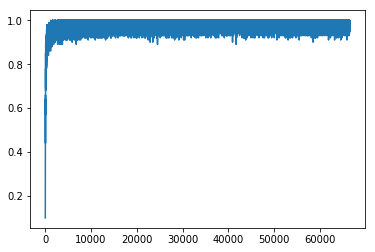

In [59]:
plt.plot(mem.classif_eval)

In [37]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [38]:
x_test, y_test = mnist.test.images, mnist.test.labels
wave_tensor = wave_tensor_data(x_test)
classif_eval = accuracy.eval(feed_dict={x_5: wave_tensor[5],\
                                        x_4: wave_tensor[4],\
                                        x_3: wave_tensor[3],\
                                        x_2: wave_tensor[2],\
                                        x_1: wave_tensor[1],\
                                        x_0: wave_tensor[0],\
                                        y: y_test,\
                                        keep_prob: 1,\
                                        batch_phase:False})
sys.stdout.write('\r classif : %.5f' \
                 % (classif_eval,))

 classif : 0.99070

## Tests single prediction

In [35]:
test_tensor = {}
test_tensor[5] = np.zeros((1, DIM_5, DIM_5, DEPTH_WAV))
test_tensor[4] = np.zeros((1, DIM_4, DIM_4, DEPTH_WAV))
test_tensor[3] = np.zeros((1, DIM_3, DIM_3, DEPTH_WAV))
test_tensor[2] = np.zeros((1, DIM_2, DIM_2, DEPTH_WAV))
test_tensor[1] = np.zeros((1, DIM_1, DIM_1, DEPTH_WAV))
test_tensor[0] = np.zeros((1, 1, 1, 1))

test = y_hat_logit.eval(feed_dict={ x_5: test_tensor[5],\
                                    x_4: test_tensor[4],\
                                    x_3: test_tensor[3],\
                                    x_2: test_tensor[2],\
                                    x_1: test_tensor[1],\
                                    x_0: test_tensor[0],\
                                    keep_prob: 1,\
                                    batch_phase:False})

print test

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


## Baseline recognition rate

In [36]:
NB_CLASSES = 10
NB_TRIALS = 100

In [60]:
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [38]:
mem_classif = []
for i in range(NB_TRIALS):
    if i % 10 == 0:
        print(i)
    pi = np.ones(10) / 10
    log_score = np.zeros(10)
    mem_pi = [pi]
    x_test = mnist.test.images[i]
    y_test = mnist.test.labels[i]
    wave_tensor_test = {}
    test_size = 16 * 16
    wave_tensor_test = init_wave_tensor(test_size)
    log_score = 0
    for i_ref in range(15):
        for j_ref in range(15):
            num_test = i_ref * 16 + j_ref
            wave_tensor_tmp = wave_tensor_data_backbone(np.reshape(x_test,(1, 28 *28)), depth = -1, i_ref = i_ref, j_ref = j_ref)
            for h in range(6):
                wave_tensor_test[h][num_test] =  wave_tensor_tmp[h][0]
            
    test = y_hat_logit.eval(feed_dict={ x_5: wave_tensor_test[5],\
                                    x_4: wave_tensor_test[4],\
                                    x_3: wave_tensor_test[3],\
                                    x_2: wave_tensor_test[2],\
                                    x_1: wave_tensor_test[1],\
                                    x_0: wave_tensor_test[0],\
                                    keep_prob: 1,\
                                    batch_phase:False})
    sum_test = np.sum(test, axis = 0)
    y_out = np.where(sum_test == max(sum_test))[0][0]
    #y_hat = np.where(y_test == max(y_test))[0][0]
    mem_classif += [y_out == y_test]


0
10


KeyboardInterrupt: 

In [70]:
np.mean(mem_classif)

0.93000000000000005

9


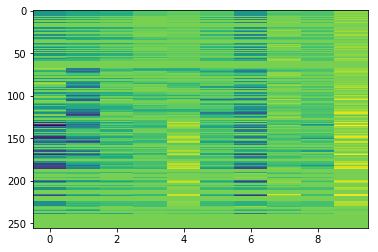

In [71]:
#plt.imshow(test, aspect = 'auto')
print(y_test)

In [ ]:
np.where(np.array(mem_classif)==True,1,0).sum()/ (NB_CLASSES * NB_TRIALS / 100.0)

# Parcours predictif

In [61]:
from scipy.stats import entropy

In [62]:
mu, Sigma, rho = pickle.load(open("mnist-waveimage-train-mu-Sigma-rho.pkl", "rb"))

In [63]:
pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map.pkl", "rb"))    
#pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map-diff-backbone-CNN-parts.pkl", "rb"))    

In [64]:
H_generic_eff = pickle.load(open("mnist-waveimage-generic-saliency-map.pkl", "rb"))    
#pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map-diff-backbone-CNN-parts.pkl", "rb"))    

In [65]:
def calcule_asc_path(h,u):
    rep = []
    for h_inf in range(h, 0, -1):
        i_inf = u[0] / (2 ** (h - h_inf))
        j_inf = u[1] / (2 ** (h - h_inf))
        rep += [(h_inf, (i_inf, j_inf))]
    # racine
    rep += [(0, (i_inf, j_inf))]
    return rep

In [66]:
def calc_pi_predictive_sorted(pi_predictive): 
    pi_predictive_sorted = {}
    for c in range(10):
        pi_predictive_sorted[c] = []
        for k in pi_predictive[c]:
            pi_predictive_sorted[c] += [(pi_predictive[c][k], k)]
        pi_predictive_sorted[c] = sorted(pi_predictive_sorted[c])
    return pi_predictive_sorted

In [67]:
def calc_H_predictive_sorted(H_predictive): 
    H_predictive_sorted = []
    for k in H_predictive:
        H_predictive_sorted += [(H_predictive[k], k)]
    H_predictive_sorted = sorted(H_predictive_sorted, reverse=True)
    return H_predictive_sorted

In [68]:
def argmax_generator(c, h, u):
    test_pred = rho[c][h][u] < .5       
    if test_pred:
        return mu[c][h][u]
    else:
        return np.zeros(3)

In [69]:
def softmax_generator(log_score, h, u):
    Z = np.sum(np.exp(log_score))
    mu_c = np.zeros(3)
    for c in range(NB_LABEL):
        pi = np.exp(log_score[0][c]) / Z
        mu_c += pi * mu[c][h][u] * (1 - rho[c][h][u])
    return mu_c

In [70]:
def predictive_search(sess, wave_tensor, z_ref, log_score, actions_set, mem_h_u, FLAG_DUAL = False):
    # actions_set ne contient que les positions de niveau 5
    h_ref = 5
    batch_size = len(actions_set)
    batch_predictive_tensor =  {} #init_wave_tensor(batch_size)
    for h in range(6):
        if h == 0:
            h_size = 1
            batch_predictive_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            batch_predictive_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
        for i in range(batch_size):
            batch_predictive_tensor[h][i] = np.copy(wave_tensor[h][0])
    ## Parcours predictif
    
    dict_u = {}
    for i, u_gen in enumerate(actions_set):
        dict_u[i] = u_gen
        liste_path = calcule_asc_path(h_ref, u_gen)
        #print(liste_path)
        for (h_path, u_path) in liste_path[:-1]:
            #print(h_path, u_path)
            if (h_path, u_path) not in mem_h_u:
                v_predictive = argmax_generator(z_ref, h_path, u_path)
                batch_predictive_tensor[h_path][i][u_path[0]][u_path[1]][:] =  v_predictive

    log_score_path = y_hat_logit.eval(feed_dict={ x_5: batch_predictive_tensor[5],\
                                    x_4: batch_predictive_tensor[4],\
                                    x_3: batch_predictive_tensor[3],\
                                    x_2: batch_predictive_tensor[2],\
                                    x_1: batch_predictive_tensor[1],\
                                    x_0: batch_predictive_tensor[0],\
                                    keep_prob: 1,\
                                    batch_phase:False})    
        
    q_pre = np.exp(log_score[0]) / np.sum(np.exp(log_score[0]))
    FEP_post = np.zeros(batch_size)
    for i, u_gen in enumerate(actions_set):
        q_post = np.exp(log_score_path[i]) / np.sum(np.exp(log_score_path[i]))  
        if not FLAG_DUAL:
            FEP_post[i] = entropy(q_post)
        else:
            delta_log_score_path = log_score_path[i] - log_score[0]
            delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
            FEP_post[i] = entropy(q_post) - np.log(delta_q_post[z_ref]) + np.log(q_pre[z_ref]) 
            #print u_gen, entropy(q_post), - np.log(delta_q_post[z_ref]), FEP_post[i] 
                
    #i_max = np.where(log_score_path[:, z_ref] == max(log_score_path[:, z_ref]))[0][0]
    i_min = np.where(FEP_post == min(FEP_post))[0][0]
    q_post = np.exp(log_score_path[i_min]) / np.sum(np.exp(log_score_path[i_min])) 
    delta_log_score_path = log_score_path[i_min] - log_score[0]
    delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
    print dict_u[i_min] , entropy(q_post), - np.log(delta_q_post[z_ref]) + np.log(q_pre[z_ref]), FEP_post[i_min]
    #pi_path = sess.run(tf.nn.softmax(log_score + log_score_path[i_max,:]))
    #pi_path = np.zeros(batch_size)
    #for i in range(batch_size):
    #    pi_path[i] = np.exp(log_score_path[i, z_ref]) / np.sum(np.exp(log_score_path[i]))
    
    ## 3 ##
    return dict_u[i_min] #, pi_path[i_max] #pi_path[i_max][z_ref]
    

In [71]:
from scipy.stats import entropy

def FEP_predictive_search(sess, wave_tensor, log_score, actions_set, mem_h_u, FLAG_DUAL = False):
    # actions_set ne contient que les positions de niveau 5
    h_ref = 5
    batch_size = len(actions_set)
    batch_predictive_tensor =  {} #init_wave_tensor(batch_size)
    for h in range(6):
        if h == 0:
            h_size = 1
            batch_predictive_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            batch_predictive_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
        for i in range(batch_size):
            batch_predictive_tensor[h][i] = np.copy(wave_tensor[h][0])
    ## Parcours predictif
    dict_u = {}
    for i, u_gen in enumerate(actions_set):
        dict_u[i] = u_gen
        liste_path = calcule_asc_path(h_ref, u_gen)
        #print(liste_path)
        for (h_path, u_path) in liste_path[:-1]:
            #print(h_path, u_path)
            if (h_path, u_path) not in mem_h_u:
                v_predictive = softmax_generator(log_score, h_path, u_path)
                batch_predictive_tensor[h_path][i][u_path[0]][u_path[1]][:] =  v_predictive

    log_score_path = y_hat_logit.eval(feed_dict={ x_5: batch_predictive_tensor[5],\
                                    x_4: batch_predictive_tensor[4],\
                                    x_3: batch_predictive_tensor[3],\
                                    x_2: batch_predictive_tensor[2],\
                                    x_1: batch_predictive_tensor[1],\
                                    x_0: batch_predictive_tensor[0],\
                                    keep_prob: 1,\
                                    batch_phase:False})    
    
    FEP_post = np.zeros(batch_size)
    q_pre = np.exp(log_score[0]) / np.sum(np.exp(log_score[0]))
    for i, u_gen in enumerate(actions_set):
        q_post = np.exp(log_score_path[i]) / np.sum(np.exp(log_score_path[i]))
        if not FLAG_DUAL:
            FEP_post[i] = entropy(q_post)
        else:
            delta_log_score_path = log_score_path[i] - log_score[0]
            delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
            FEP_post[i] = entropy(q_post) + entropy(q_pre, delta_q_post)
        
    i_min = np.where(FEP_post == min(FEP_post))[0][0]

    #pi_path = sess.run(tf.nn.softmax(log_score + log_score_path[i_max,:]))
    #pi_path = np.zeros(batch_size)
    #for i in range(batch_size):
    #    pi_path[i] = np.exp(log_score_path[i, z_ref]) / np.sum(np.exp(log_score_path[i]))
    
    ## 3 ##
    return dict_u[i_min] #, pi_path[i_max] #pi_path[i_max][z_ref]
    

In [82]:
def FEP_predictive_search_full(sess, wave_tensor, log_score, actions_set, mem_h_u, FLAG_DUAL = False):
    # actions_set ne contient que les positions de niveau 5
    h_ref = 5
    batch_ref = len(actions_set)
    batch_size = batch_ref * NB_LABEL
    batch_predictive_tensor =  {} #init_wave_tensor(batch_size)
    log_score_path = {}
    delta_log_score_path = {}
    for h in range(6):
        if h == 0:
            h_size = 1
            batch_predictive_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            batch_predictive_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
        for i in range(batch_size):
            batch_predictive_tensor[h][i] = np.copy(wave_tensor[h][0])
    ## Parcours predictif
    dict_u = {}
    for i, u_gen in enumerate(actions_set):
        dict_u[i] = u_gen
        liste_path = calcule_asc_path(h_ref, u_gen)
        #print(liste_path)
        for (h_path, u_path) in liste_path[:-1]:
            #print(h_path, u_path)
            if (h_path, u_path) not in mem_h_u:
                for c in range(NB_LABEL):
                    v_predictive = argmax_generator(c, h_path, u_path)
                    batch_predictive_tensor[h_path][c * batch_ref + i][u_path[0]][u_path[1]][:] =  v_predictive

    log_score_path = y_hat_logit.eval(feed_dict={ x_5: batch_predictive_tensor[5],\
                                    x_4: batch_predictive_tensor[4],\
                                    x_3: batch_predictive_tensor[3],\
                                    x_2: batch_predictive_tensor[2],\
                                    x_1: batch_predictive_tensor[1],\
                                    x_0: batch_predictive_tensor[0],\
                                    keep_prob: 1,\
                                    batch_phase:False})    
    delta_log_score_path = log_score_path - log_score
    
    FEP_post = np.zeros(batch_size)
    q_pre = np.exp(log_score[0]) / np.sum(np.exp(log_score[0]))
    #print q_pre
    for i, u_gen in enumerate(actions_set):
        for c in range(NB_LABEL):
            i_full = c * batch_ref + i
            q_post = np.exp(log_score_path[i_full]) / np.sum(np.exp(log_score_path[i_full]))  
            if not FLAG_DUAL:
                FEP_post[i_full] = entropy(q_post)
                #print u_gen, q_post
                #print FEP_post[i]
            else:
                delta_log_score_path = log_score_path[i_full] - log_score[0]
                delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
                #q_pre_hat = np.zeros(NB_LABEL)
                #q_pre_hat[c] = 1
                FEP_post[i_full] = entropy(q_post) - np.log(delta_q_post[c]) + np.log(q_pre[c])
                #FEP_post[i_full] = entropy(q_post) + entropy(q_pre, delta_q_post)
                #print u_gen, entropy(q_post), - np.log(delta_q_post[c]), FEP_post[i_full] 
    #ch = raw_input('')        
    FEP_post_full = np.zeros((batch_ref,))
    for c in range(NB_LABEL):
        FEP_post_full += q_pre[c] * FEP_post[c * batch_ref : (c + 1) * batch_ref]
        
    #for i, u_gen in enumerate(actions_set):
    #    print u_gen, FEP_post_full[i]
    
    i_min = np.where(FEP_post_full == min(FEP_post_full))[0][0]
    
    ## 3 ##
    return dict_u[i_min]  #pi_path[i_max][z_ref]
    

In [83]:
def prediction_based_policy(sess, wave_tensor, log_score, actions_set, mem_h_u, FLAG_DUAL = False,):
    
    ## 1 ##
    z_tilde = np.argmax(log_score)    
    u_tilde = predictive_search(sess, wave_tensor, z_tilde, log_score, actions_set, mem_h_u, FLAG_DUAL)
    
    return u_tilde

In [84]:
def FEP_prediction_based_policy(sess, wave_tensor, log_score, actions_set, mem_h_u, FLAG_DUAL = False, FLAG_FULL = False):
    
    ## 1 ##
    if not FLAG_FULL:
        u_tilde = FEP_predictive_search(sess, wave_tensor, log_score, actions_set, mem_h_u, FLAG_DUAL)
    else:
        u_tilde = FEP_predictive_search_full(sess, wave_tensor, log_score, actions_set, mem_h_u, FLAG_DUAL)
    
    return u_tilde

In [85]:
def saliency_based_policy(log_score, pi_predictive_sorted, mem_h_u):
    h = 5
    ## 1 ##
    z_tilde = np.argmax(log_score)
    u_tilde = pi_predictive_sorted[z_tilde].pop()[1]
    while (h, u_tilde) in mem_h_u:
        u_tilde = pi_predictive_sorted[z_tilde].pop()[1]
    return u_tilde
    

In [86]:
def generic_saliency_based_policy(H_predictive_sorted, mem_h_u):
    u_tilde = H_predictive_sorted.pop()[1]
    return u_tilde

In [87]:
def random_policy(log_score, mem_h_u):
    h = 5
    ## 1 ##
    z_tilde = np.argmax(log_score)
    #u_tilde = (1 + np.random.randint(14),  1 + np.random.randint(14))
    u_tilde = (np.random.randint(16),  np.random.randint(16))
    while (h, u_tilde) in mem_h_u:
        #u_tilde = (1 + np.random.randint(14),  1 + np.random.randint(14))
        u_tilde = (np.random.randint(16),  np.random.randint(16))
    return u_tilde

In [88]:
def scene_exploration(sess, wave_tensor_ref, wave_tensor, log_score, z_ref, ind_test, actions_set, mem_h_u, record, \
                      POL = 'predictive', AFF = True, THRESHOLD = 1e-4):
    
    assert POL == 'predictive' or POL == 'predictive-dual' or POL == 'saliency-based' or POL == 'random' or POL == 'full'\
    or POL == 'generic-saliency-based' or POL == 'FEP-predictive' or POL == 'FEP-predictive-dual'
    
    if POL == 'full':
        THRESHOLD = 0
        POL = 'saliency-based'
    
    TOUR = 0
    END = False
    h_ref = 5
    
    # saliency-based approach
    if POL == 'saliency-based':
        pi_predictive_sorted = calc_pi_predictive_sorted(pi_predictive_eff)
    if True : #POL == 'generic-saliency-based':
        H_predictive_sorted = calc_H_predictive_sorted(H_generic_eff)    
    while END == False:
        
        if AFF:
            print '************************************'
            print '******       TOUR    ' + str(TOUR + 1) + '        ******'
            print '************************************'
        
        # 1. CHOIX
        if POL == 'predictive':
            if TOUR == 0:
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = prediction_based_policy(sess, wave_tensor, log_score, actions_set, mem_h_u)
        elif POL == 'predictive-dual':
            if TOUR == 0:
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = prediction_based_policy(sess, wave_tensor, log_score, actions_set, mem_h_u, FLAG_DUAL = True)
        elif POL == 'FEP-predictive-dual':
            if TOUR == 0:
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = FEP_prediction_based_policy(sess, wave_tensor, log_score, actions_set, mem_h_u,\
                                                      FLAG_DUAL = True, FLAG_FULL = True)
            #print u_tilde
            #ch = raw_input('')     
        elif POL == 'FEP-predictive':
            if TOUR == 0:
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = FEP_prediction_based_policy(sess, wave_tensor, log_score, actions_set, mem_h_u,\
                                                      FLAG_DUAL = False, FLAG_FULL = True)
            #print u_tilde
            #ch = raw_input('')    
        elif POL == 'saliency-based':
            if TOUR == 0:
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = saliency_based_policy(log_score, pi_predictive_sorted, mem_h_u)
        elif POL == 'generic-saliency-based':
            u_tilde = generic_saliency_based_policy(H_predictive_sorted, mem_h_u)
        else:
            u_tilde = random_policy(log_score, mem_h_u)
        
        if AFF:
            print 'CHOIX :', u_tilde
        
        # 2. LECTURE + UPDATE
        #wave_tensor =  init_wave_tensor(1)
        liste_path = calcule_asc_path(h_ref, u_tilde)
        
        for (h_path, u_path) in reversed(liste_path):
            if (h_path, u_path) not in mem_h_u:
                wave_tensor[h_path][0][u_path[0]][u_path[1]][:] =  wave_tensor_ref[h_path][0][u_path[0]][u_path[1]][:]
                mem_h_u += [(h_path, u_path)]
                record.mem_h_u += [(h_path, u_path)]
                record.nb_coeffs += 3  
                
        log_score = y_hat_logit.eval(feed_dict={x_5: wave_tensor[5],\
                            x_4: wave_tensor[4],\
                            x_3: wave_tensor[3],\
                            x_2: wave_tensor[2],\
                            x_1: wave_tensor[1],\
                            x_0: wave_tensor[0],\
                            keep_prob: 1,\
                            batch_phase:False})  
        #log_score += delta_log_score
                
        pi = np.exp(log_score[0]) / np.sum(np.exp(log_score[0])) #sess.run(tf.nn.softmax(log_score))[0]
                
        H = entropy(pi) # sess.run(tf.nn.softmax_cross_entropy_with_logits(labels=pi,logits=log_score)) #np.sum(- pi * np.log(pi))
        out = np.argmax(pi)
                
        if AFF :
            print 'pi : ', pi
            print 'out :', out
            print 'pi[out] : ', pi[out]
            print 'H : ', H

        record.mem_pi += [pi]
        record.mem_H += [H]
        record.mem_z += [out]
                
        # 3. INHIBITION OF RETURN        
        actions_set.pop(u_tilde)
        
        record.mem_u += [u_tilde]
        record.nb_saccades += 1
                
        if AFF:
            print '****', 'z :', z_ref, ', u :',u_tilde, ' ---> ', out
              
        
        if TOUR == 16 * 16 - 1 or H < THRESHOLD:
            END = True
            if AFF :
                print '************************************'
                print '******         FINI          *******'
                print '************************************' 
            return out
        else:
            TOUR += 1   

## Main

In [89]:
from record import Record, affiche_records            

In [90]:
NB_TRIALS = 1000

In [91]:
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


    Policy : predictive, threshold : 0.03, 4 saccades, initial : 3, final : 7, classe : 7, elapsed time : 4.96038
    Policy : predictive, threshold : 0.03, 4 saccades, initial : 0, final : 2, classe : 2, elapsed time : 9.72888
    Policy : predictive, threshold : 0.03, 1 saccades, initial : 1, final : 1, classe : 1, elapsed time : 11.6165
    Policy : predictive, threshold : 0.03, 2 saccades, initial : 0, final : 0, classe : 0, elapsed time : 14.5421
    Policy : predictive, threshold : 0.03, 8 saccades, initial : 4, final : 4, classe : 4, elapsed time : 22.9571
    Policy : predictive, threshold : 0.03, 1 saccades, initial : 1, final : 1, classe : 1, elapsed time : 24.8637
    Policy : predictive, threshold : 0.03, 3 saccades, initial : 7, final : 4, classe : 4, elapsed time : 28.7859
    Policy : predictive, threshold : 0.03, 4 saccades, initial : 8, final : 9, classe : 9, elapsed time : 33.8153
    Policy : predictive, threshold : 0.03, 10 saccades, initial : 2, final : 5, classe : 5, elapsed time : 44.5951
    Policy : predictive, threshold : 0.03, 3 saccades, initial : 0, final : 9, classe : 9, elapsed time : 48.4158

In [92]:
sum = 0
for i in range(len(records)):
    print(records[i].mem_H)
print sum * 1. / len(records)

ZeroDivisionError: float division by zero

In [ ]:
# Test generic saliency map

In [93]:
import time
dict_records = {}

#file_name = "mnist-waveimage-CNN-backbone-records-rnd-parts-generic-saliency.npy"
file_name = "mnist-waveimage-CNN-backbone-records-rnd-parts-FEP-dual-H0_init.npy"

if True : #not os.path.isfile(file_name):
    
    for POL in ('FEP-predictive-dual', 'FEP-predictive', 'predictive-dual', 'predictive'): # 'FEP-predictive'): #'generic-saliency-based',): 

        dict_records[POL] = {}

        for THRESHOLD in (1, 3e-1, 1e-1, 3e-2, 1e-2):

            records = [] 
            cpt_TRIALS = 0

            tic = time.time()

            #NB_TRIALS = len(Data_test[z_ref][0][(0,0)])

            for ind_test in range(NB_TRIALS):
                if ind_test % 10 == 0:
                    print(POL, THRESHOLD, ind_test)
                x_test, z_ref = mnist.test.images[ind_test], mnist.test.labels[ind_test]
                #wave_tensor = wave_tensor_data(x_test)
                x_noise = np.copy(x_test)
                '''for _ in range(50):
                    i_1 = np.where(np.random.multinomial(1, np.ones(784)/784) == 1)[0][0]
                    i_2 = np.where(np.random.multinomial(1, np.ones(784)/784) == 1)[0][0]
                    x_noise[i_1], x_noise[i_2] = x_noise[i_2], x_noise[i_1]'''
                wave_tensor_ref = wave_tensor_data(np.reshape(x_noise,(1, 28*28)))

                # initial
                log_score = np.zeros((1,10))
                pi = np.ones(10) / 10
                H = entropy(pi) #np.sum(- pi * np.log(pi))

                record = Record()
                record.POL = POL
                record.THRESHOLD = THRESHOLD
                record.z_ref = z_ref
                record.mem_pi += [pi]
                record.mem_H += [H]
                z_tilde = -1

                # global coef --> log_score initial
                mem_h_u = []
                wave_tensor =  init_wave_tensor(1)

                # initial actions set
                actions_set = {}
                for i in range(16):
                    for j in range(16):
                        actions_set[(i, j)] = 1

                z_final = scene_exploration(sess, wave_tensor_ref, wave_tensor, log_score, z_ref, ind_test,\
                                            actions_set, mem_h_u, record, \
                                            POL = POL, AFF = False, THRESHOLD = THRESHOLD)
                record.z_final = z_final
                record.success = z_ref == z_final

                records += [record]

                toc = time.time()
                print '\rPolicy : %s, threshold : %g, %d saccades, initial : %d, final : %d, classe : %d, elapsed time : %g' \
                                    % (POL, THRESHOLD, record.nb_saccades, z_tilde, z_final, z_ref, toc - tic)   
                cpt_TRIALS  += NB_TRIALS

            dict_records[POL][THRESHOLD] = records
            print '\n'
            print 'Nb trials :', cpt_TRIALS
            #affiche_records(records)
            print '\n'
            np.save(file_name, dict_records)
else:
    dict_records = np.load(file_name)
        

('FEP-predictive-dual', 1, 0)
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 0.449919
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 0.456239
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 0.463612
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 0.469379
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 0.476078
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 0.4827
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 0.488639
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 0.843569
Policy : FEP-predictive-dual

Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 4.16369
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 4.17056
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 4.1773
('FEP-predictive-dual', 1, 80)
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 4.18541
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 4.19193
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 4.19854
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 4.20503
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 4.21166
Policy : FEP-predictive-dual, thre

Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 9.9353
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 9.94882
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 9.96226
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 9.97547
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 9.9888
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 10.0022
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 10.493
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 10.8659
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : 

Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 16.5219
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 16.5291
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 16.5357
('FEP-predictive-dual', 1, 230)
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 16.5421
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 16.5485
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 8, elapsed time : 16.5549
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 8, elapsed time : 16.5613
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 16.5676
Policy : FEP-predictive-dual, th

Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 23.7748
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 23.7831
Policy : FEP-predictive-dual, threshold : 1, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 24.7266
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 25.0471
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 25.0565
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 25.063
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 25.0783
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 25.0849
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial 

Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 29.4597
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 29.4663
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 29.7863
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 29.7931
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 4, elapsed time : 29.7997
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 29.8062
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 29.8137
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 29.82
('FEP-predictive-dual', 1, 380)
Policy : FEP-predictive-dual, thre

Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 36.5738
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 9, elapsed time : 36.5805
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 3, elapsed time : 36.5868
('FEP-predictive-dual', 1, 450)
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 36.5934
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 36.5998
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 36.6064
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 36.6147
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 36.623
Policy : FEP-predictive-dual, thr

Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 40.0257
('FEP-predictive-dual', 1, 520)
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 40.0333
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 40.0397
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 40.0464
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 40.0528
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 40.3746
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 40.3814
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 40.3878
Policy : FEP-predictive-dual, th

Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 47.0181
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 47.0247
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 4, classe : 9, elapsed time : 47.3862
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 47.3927
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 47.399
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 47.4055
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 47.4153
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 47.4228
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial 

Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 52.3735
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 52.7505
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 53.0988
('FEP-predictive-dual', 1, 670)
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 53.1055
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 53.1119
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 53.1182
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 53.1251
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 5, elapsed time : 53.1318
Policy : FEP-predictive-dual, th

Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 58.9904
('FEP-predictive-dual', 1, 740)
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 4, elapsed time : 58.9978
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 59.3447
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 59.3517
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 59.3583
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 59.3653
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 59.3722
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 59.38
Policy : FEP-predictive-dual, thre

Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 64.8753
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 64.883
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 65.3032
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 65.3162
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 65.3289
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 65.3421
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 65.3559
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 65.3689
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial 

Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 69.1579
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 69.4791
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 9, elapsed time : 69.4855
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 69.8052
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 69.8122
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 69.8185
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 69.8247
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 69.8314
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial

Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 75.8079
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 75.8146
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 75.8209
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 75.8273
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 75.8341
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 75.8404
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 2, classe : 1, elapsed time : 76.166
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 76.1725
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial 

Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 3.01291
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 3.02057
('FEP-predictive-dual', 0.3, 20)
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 3.02783
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 3.40137
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 3.40818
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 3.80901
Policy : FEP-predictive-dual, threshold : 0.3, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 5.09906
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 5.10563
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 23.0902
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 23.5037
Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 24.1983
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 24.6162
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 24.625
('FEP-predictive-dual', 0.3, 90)
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 24.9736
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 24.9846
Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 25.7039
Policy : FEP-pre

Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 48.2522
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 48.5927
Policy : FEP-predictive-dual, threshold : 0.3, 7 saccades, initial : -1, final : 3, classe : 3, elapsed time : 50.5561
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 50.8835
('FEP-predictive-dual', 0.3, 160)
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 50.8934
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 50.9012
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 50.9076
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 50.9138
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 72.5008
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 72.8298
Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 73.4547
Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 74.2343
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 74.65
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 74.6612
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 75.0398
('FEP-predictive-dual', 0.3, 230)
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 75.0468
Policy : FEP-pre

Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 96.739
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 96.7463
Policy : FEP-predictive-dual, threshold : 0.3, 6 saccades, initial : -1, final : 7, classe : 9, elapsed time : 98.4116
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 98.7336
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 98.7402
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 99.0574
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 99.064
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 99.3879
Policy : FEP-predictive-dual, threshold : 0.3, 3 s

Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 123.867
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 124.203
('FEP-predictive-dual', 0.3, 360)
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 124.214
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 124.221
Policy : FEP-predictive-dual, threshold : 0.3, 4 saccades, initial : -1, final : 7, classe : 2, elapsed time : 125.299
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 125.693
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 125.701
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 126.09
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 142.861
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 142.867
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 142.874
Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 143.594
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 143.981
('FEP-predictive-dual', 0.3, 430)
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 143.988
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 144.319
Policy : FEP-predictive-dual, threshold : 0.3, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 145.387
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 169.449
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 169.781
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 170.107
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 8, elapsed time : 170.426
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 170.75
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 171.071
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 171.423
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 171.43
('FEP-predictive-dual', 0.3, 500)
Policy : FEP-pre

Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 192.886
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 193.204
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 193.526
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 193.856
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 194.176
Policy : FEP-predictive-dual, threshold : 0.3, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 195.099
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 195.105
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 195.426
Policy : FEP-predictive-dual, threshold : 0.3, 1

Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 213.114
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 213.121
('FEP-predictive-dual', 0.3, 630)
Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 213.751
Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 214.377
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 214.383
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 214.389
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 214.716
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 214.723
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 244.146
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 244.463
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 244.784
('FEP-predictive-dual', 0.3, 700)
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 245.094
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 245.101
Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 245.718
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 246.031
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 246.038
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 263.918
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 263.925
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 263.931
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 264.252
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 264.259
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 264.265
('FEP-predictive-dual', 0.3, 770)
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 264.272
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 264.278
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 279.768
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 279.776
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 279.783
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 279.791
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 279.797
Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 280.455
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 280.781
Policy : FEP-predictive-dual, threshold : 0.3, 10 saccades, initial : -1, final : 8, classe : 8, elapsed time : 283.702
('FEP-predictive-dual', 0.3, 840)
Policy : FEP-

Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 303.135
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 303.455
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 303.461
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 303.787
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 304.107
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 304.43
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 304.437
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 304.443
Policy : FEP-predictive-dual, threshold : 0.3, 1 

Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 369.064
('FEP-predictive-dual', 0.3, 970)
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 369.386
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 369.711
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 369.717
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 369.724
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 370.044
Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 370.689
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 371.01
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 12.9263
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 13.2505
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 14.2115
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 14.2185
('FEP-predictive-dual', 0.1, 40)
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 14.5426
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 14.8687
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 14.8805
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 15.5097
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 125.973
Policy : FEP-predictive-dual, threshold : 0.1, 241 saccades, initial : -1, final : 9, classe : 9, elapsed time : 197.406
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 198.571
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 199.848
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 199.892
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 200.511
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 201.086
('FEP-predictive-dual', 0.1, 110)
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 201.606
Policy : FEP

Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 255.311
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 256.444
Policy : FEP-predictive-dual, threshold : 0.1, 6 saccades, initial : -1, final : 2, classe : 2, elapsed time : 259.043
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 259.581
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 260.098
Policy : FEP-predictive-dual, threshold : 0.1, 7 saccades, initial : -1, final : 7, classe : 7, elapsed time : 263.907
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 263.914
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 264.471
Policy : FEP-predictive-dual, threshold : 0.1, 1

Policy : FEP-predictive-dual, threshold : 0.1, 11 saccades, initial : -1, final : 9, classe : 9, elapsed time : 330.949
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 331.508
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 332.63
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 333.655
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 334.719
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 335.242
Policy : FEP-predictive-dual, threshold : 0.1, 8 saccades, initial : -1, final : 6, classe : 4, elapsed time : 338.852
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 338.865
Policy : FEP-predictive-dual, threshold : 0.1, 4

Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 445.283
('FEP-predictive-dual', 0.1, 310)
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 445.855
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 445.87
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 445.885
Policy : FEP-predictive-dual, threshold : 0.1, 11 saccades, initial : -1, final : 5, classe : 3, elapsed time : 451.467
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 451.484
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 452.036
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 452.588
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 508.399
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 508.407
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 508.414
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 508.421
('FEP-predictive-dual', 0.1, 380)
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 508.982
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 7, classe : 3, elapsed time : 510.16
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 510.731
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 511.279
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 559.045
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 560.052
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 6, elapsed time : 560.571
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 561.545
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 563.036
Policy : FEP-predictive-dual, threshold : 0.1, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 565.42
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 5, classe : 3, elapsed time : 565.432
('FEP-predictive-dual', 0.1, 450)
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 566.477
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 619.988
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 620.509
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 621.017
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 621.55
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 622.058
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 623.137
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 623.15
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 624.618
Policy : FEP-predictive-dual, threshold : 0.1, 3 s

Policy : FEP-predictive-dual, threshold : 0.1, 8 saccades, initial : -1, final : 3, classe : 3, elapsed time : 715.119
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 715.616
('FEP-predictive-dual', 0.1, 580)
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 716.599
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 717.11
Policy : FEP-predictive-dual, threshold : 0.1, 19 saccades, initial : -1, final : 2, classe : 8, elapsed time : 725.763
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 2, elapsed time : 726.852
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 727.346
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 727.358
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 5, classe : 5, elapsed time : 772.011
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 2, elapsed time : 772.339
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 772.346
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 772.676
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 772.996
('FEP-predictive-dual', 0.1, 650)
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 773.326
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 773.333
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 773.339
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 829.997
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 830.318
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 831.248
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 831.881
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 831.888
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 0, elapsed time : 832.224
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 832.54
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 832.547
('FEP-predictive-dual', 0.1, 720)
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 865.822
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 866.488
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 867.152
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 867.158
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 867.165
Policy : FEP-predictive-dual, threshold : 0.1, 6 saccades, initial : -1, final : 5, classe : 5, elapsed time : 868.729
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 869.659
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 870.293
Policy : FEP-predictive-dual, threshold : 0.1, 2

Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 906.307
('FEP-predictive-dual', 0.1, 850)
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 906.313
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 906.632
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 906.957
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 907.323
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 907.67
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 908.022
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 908.346
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 932.89
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 933.216
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 933.223
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 933.891
('FEP-predictive-dual', 0.1, 920)
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 933.899
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 934.231
Policy : FEP-predictive-dual, threshold : 0.1, 7 saccades, initial : -1, final : 2, classe : 2, elapsed time : 936.133
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 936.455
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1018.69
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1018.69
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1019.02
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1019.03
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1019.65
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1019.97
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1020.3
('FEP-predictive-dual', 0.1, 990)
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1020.61
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 27.8291
Policy : FEP-predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 28.7715
Policy : FEP-predictive-dual, threshold : 0.03, 5 saccades, initial : -1, final : 5, classe : 5, elapsed time : 30.0232
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 30.6733
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 31.3132
Policy : FEP-predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 31.3198
Policy : FEP-predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 31.3264
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 31.9555
Policy : FEP-predictive-dual, threshold 

Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 170.173
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 170.824
('FEP-predictive-dual', 0.03, 120)
Policy : FEP-predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 170.83
Policy : FEP-predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 171.784
Policy : FEP-predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 172.72
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 173.049
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 173.684
Policy : FEP-predictive-dual, threshold : 0.03, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 175.256
Policy 

Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 264.166
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 264.488
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 265.136
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 265.47
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 265.799
('FEP-predictive-dual', 0.03, 190)
Policy : FEP-predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 265.806
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 266.136
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 266.484
Policy

Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 354.198
Policy : FEP-predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 355.158
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 355.804
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 356.133
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 356.794
Policy : FEP-predictive-dual, threshold : 0.03, 11 saccades, initial : -1, final : 1, classe : 8, elapsed time : 359.939
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 360.276
Policy : FEP-predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 361.233
('FEP-predictive-dual', 0.03, 260)
Poli

Policy : FEP-predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 464.552
('FEP-predictive-dual', 0.03, 320)
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 465.192
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 7, classe : 2, elapsed time : 465.52
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 466.146
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 466.496
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 467.12
Policy : FEP-predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 468.056
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 468.682
Policy 

Policy : FEP-predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 517.781
Policy : FEP-predictive-dual, threshold : 0.03, 17 saccades, initial : -1, final : 2, classe : 2, elapsed time : 522.7
Policy : FEP-predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 522.706
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 523.357
('FEP-predictive-dual', 0.03, 390)
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 523.686
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 524.015
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 524.346
Policy : FEP-predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 524.353
Policy

Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 608.867
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 609.537
Policy : FEP-predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 609.544
Policy : FEP-predictive-dual, threshold : 0.03, 5 saccades, initial : -1, final : 2, classe : 2, elapsed time : 610.803
Policy : FEP-predictive-dual, threshold : 0.03, 10 saccades, initial : -1, final : 6, classe : 6, elapsed time : 613.67
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 614.001
Policy : FEP-predictive-dual, threshold : 0.03, 7 saccades, initial : -1, final : 0, classe : 0, elapsed time : 615.886
('FEP-predictive-dual', 0.03, 460)
Policy : FEP-predictive-dual, threshold : 0.03, 8 saccades, initial : -1, final : 5, classe : 5, elapsed time : 618.097
Polic

Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 669.356
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 669.682
Policy : FEP-predictive-dual, threshold : 0.03, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 670.952
Policy : FEP-predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 670.958
Policy : FEP-predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 671.916
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 672.248
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 672.894
Policy : FEP-predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 673.851
Policy : FEP-predictive-dual, threshold 

Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 779.812
Policy : FEP-predictive-dual, threshold : 0.03, 11 saccades, initial : -1, final : 5, classe : 5, elapsed time : 782.924
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 783.571
('FEP-predictive-dual', 0.03, 590)
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 783.901
Policy : FEP-predictive-dual, threshold : 0.03, 13 saccades, initial : -1, final : 8, classe : 8, elapsed time : 787.648
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 787.983
Policy : FEP-predictive-dual, threshold : 0.03, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 789.548
Policy : FEP-predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 789.555
Pol

Policy : FEP-predictive-dual, threshold : 0.03, 6 saccades, initial : -1, final : 5, classe : 5, elapsed time : 867.628
Policy : FEP-predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 868.572
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 868.9
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 869.539
Policy : FEP-predictive-dual, threshold : 0.03, 13 saccades, initial : -1, final : 7, classe : 7, elapsed time : 873.212
Policy : FEP-predictive-dual, threshold : 0.03, 20 saccades, initial : -1, final : 2, classe : 2, elapsed time : 879.069
('FEP-predictive-dual', 0.03, 660)
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 879.399
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 879.73
Policy

Policy : FEP-predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 946.836
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 947.175
Policy : FEP-predictive-dual, threshold : 0.03, 7 saccades, initial : -1, final : 0, classe : 0, elapsed time : 949.039
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 949.371
Policy : FEP-predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 949.381
Policy : FEP-predictive-dual, threshold : 0.03, 7 saccades, initial : -1, final : 7, classe : 7, elapsed time : 951.253
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 951.909
Policy : FEP-predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 952.848
Policy : FEP-predictive-dual, threshold 

Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 996.271
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 996.937
('FEP-predictive-dual', 0.03, 790)
Policy : FEP-predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 996.944
Policy : FEP-predictive-dual, threshold : 0.03, 13 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1000.68
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1001.33
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1002.04
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1002.36
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1002.7
Polic

Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1114.28
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1114.61
Policy : FEP-predictive-dual, threshold : 0.03, 9 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1117.1
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1117.75
Policy : FEP-predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1118.69
('FEP-predictive-dual', 0.03, 860)
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1119.01
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1119.65
Policy : FEP-predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1120.58
Policy

Policy : FEP-predictive-dual, threshold : 0.03, 8 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1164.29
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1164.63
Policy : FEP-predictive-dual, threshold : 0.03, 223 saccades, initial : -1, final : 7, classe : 2, elapsed time : 1204.4
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1204.72
Policy : FEP-predictive-dual, threshold : 0.03, 6 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1206.28
Policy : FEP-predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1206.93
Policy : FEP-predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1207.89
Policy : FEP-predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1207.89
('FEP-predictive-dual', 0.03, 930)
Poli

Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1289.19
('FEP-predictive-dual', 0.03, 990)
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1289.55
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1289.93
Policy : FEP-predictive-dual, threshold : 0.03, 31 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1298.97
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1299.28
Policy : FEP-predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1299.6
Policy : FEP-predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1299.61
Policy : FEP-predictive-dual, threshold : 0.03, 6 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1301.16
Polic

Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 53.8962
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 53.9027
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 54.5407
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 54.87
('FEP-predictive-dual', 0.01, 60)
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 54.877
Policy : FEP-predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 8, classe : 8, elapsed time : 56.4184
Policy : FEP-predictive-dual, threshold : 0.01, 20 saccades, initial : -1, final : 9, classe : 9, elapsed time : 62.1349
Policy : FEP-predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 3, classe : 3, elapsed time : 64.0149
Policy :

Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 201.287
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 201.967
Policy : FEP-predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 9, classe : 9, elapsed time : 203.923
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 0, classe : 0, elapsed time : 205.279
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 205.287
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 205.636
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 205.976
('FEP-predictive-dual', 0.01, 130)
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 206.656
Polic

Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 336.009
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 336.45
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 336.896
Policy : FEP-predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 338.934
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 339.367
Policy : FEP-predictive-dual, threshold : 0.01, 131 saccades, initial : -1, final : 3, classe : 3, elapsed time : 377.872
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 378.262
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 378.274
Policy : FEP-predictive-dual, threshold

Policy : FEP-predictive-dual, threshold : 0.01, 149 saccades, initial : -1, final : 8, classe : 8, elapsed time : 559.337
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 559.701
Policy : FEP-predictive-dual, threshold : 0.01, 8 saccades, initial : -1, final : 6, classe : 6, elapsed time : 561.846
('FEP-predictive-dual', 0.01, 260)
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 562.175
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 562.519
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 562.846
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 563.493
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 564.733
Pol

Policy : FEP-predictive-dual, threshold : 0.01, 37 saccades, initial : -1, final : 0, classe : 0, elapsed time : 751.744
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 752.676
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 753.342
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 753.671
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 754.6
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 754.606
('FEP-predictive-dual', 0.01, 330)
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 754.613
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 755.237
Policy

Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 951.623
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 951.961
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 951.967
Policy : FEP-predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 953.535
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 953.542
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 954.2
Policy : FEP-predictive-dual, threshold : 0.01, 8 saccades, initial : -1, final : 5, classe : 5, elapsed time : 956.39
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 957.021
Policy : FEP-predictive-dual, threshold : 0

Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1086.75
Policy : FEP-predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1088.66
('FEP-predictive-dual', 0.01, 460)
Policy : FEP-predictive-dual, threshold : 0.01, 9 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1091.16
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1091.49
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1092.12
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1092.13
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 9, classe : 3, elapsed time : 1092.47
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1093.11
Polic

Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1223.8
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1224.45
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1225.67
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1226.91
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1226.91
('FEP-predictive-dual', 0.01, 530)
Policy : FEP-predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1228.46
Policy : FEP-predictive-dual, threshold : 0.01, 9 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1230.96
Policy : FEP-predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1232.52
Policy

Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1371.26
Policy : FEP-predictive-dual, threshold : 0.01, 8 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1372.91
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1373.42
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1374.14
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1375.11
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1375.6
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1376.09
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1376.59
('FEP-predictive-dual', 0.01, 600)
Policy

Policy : FEP-predictive-dual, threshold : 0.01, 21 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1504.21
('FEP-predictive-dual', 0.01, 660)
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1504.46
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1504.72
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1504.96
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1504.97
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1505.46
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1505.71
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1505.96
Poli

Policy : FEP-predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1573.32
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1573.81
Policy : FEP-predictive-dual, threshold : 0.01, 8 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1575.47
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1576.43
('FEP-predictive-dual', 0.01, 730)
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1577.4
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1577.65
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1577.91
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1578.4
Policy 

Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1678.34
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1678.58
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1678.83
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1679.09
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1679.58
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1679.83
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1680.08
('FEP-predictive-dual', 0.01, 800)
Policy : FEP-predictive-dual, threshold : 0.01, 8 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1681.73
Polic

Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1804.39
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1804.89
Policy : FEP-predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1806.08
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1806.09
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1806.34
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1806.6
Policy : FEP-predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1808.02
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1808.51
Policy : FEP-predictive-dual, threshold :

Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1933.42
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1934.4
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1934.4
('FEP-predictive-dual', 0.01, 930)
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1934.89
Policy : FEP-predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1936.08
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1936.8
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1937.3
Policy : FEP-predictive-dual, threshold : 0.01, 8 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1938.96
Policy : 

Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 2018.97
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 2019.46
Policy : FEP-predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 2, classe : 2, elapsed time : 2020.65
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 2020.9
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 2021.15
Policy : FEP-predictive-dual, threshold : 0.01, 9 saccades, initial : -1, final : 9, classe : 9, elapsed time : 2023.05


Nb trials : 1000000


('FEP-predictive', 1, 0)
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 0.00583816
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 0.0113871
Pol

Policy : FEP-predictive, threshold : 1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 2.15593
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 6, elapsed time : 2.16156
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 2.16717
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 2.17312
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 0, elapsed time : 2.17833
('FEP-predictive', 1, 70)
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 2.18382
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 2.18982
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 2.19503
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 9, c

Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 2, classe : 7, elapsed time : 5.6929
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 5.69852
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 5.70395
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 5.70931
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 5.71481
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 2, elapsed time : 5.72039
('FEP-predictive', 1, 150)
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 5.72585
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 5.94663
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 5, c

Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 9.62343
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 6, elapsed time : 9.62921
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 9.63492
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 9.85723
('FEP-predictive', 1, 220)
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 9.86385
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 9.87744
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 9.88493
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 9.89038
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 1, 

Policy : FEP-predictive, threshold : 1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 14.6168
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 14.6225
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 14.845
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 14.8517
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 14.8578
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 15.0827
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 15.0891
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 0, elapsed time : 15.0947
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 2, elapsed time : 1

Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 18.7634
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 18.7707
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 18.7762
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 18.9996
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 19.0058
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 19.0115
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 19.0173
('FEP-predictive', 1, 370)
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 19.0235
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 2, 

Policy : FEP-predictive, threshold : 1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 23.3838
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 23.3897
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 8, classe : 3, elapsed time : 23.3952
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 23.4006
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 23.4059
('FEP-predictive', 1, 440)
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 23.4113
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 23.4167
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 23.4219
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, 

Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 26.4641
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 26.4699
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 26.4756
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 26.481
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 26.8118
('FEP-predictive', 1, 520)
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 26.8182
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 26.824
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 26.8295
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 1, cl

Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 31.0164
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 31.0224
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 4, classe : 9, elapsed time : 31.2437
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 31.2502
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 31.2562
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 31.2628
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 31.2692
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 31.2748
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 

Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 34.7597
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 35.0553
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 35.3212
('FEP-predictive', 1, 670)
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 35.3271
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 35.3325
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 35.338
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 35.3432
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 5, elapsed time : 35.3485
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 1, c

Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 39.0894
('FEP-predictive', 1, 740)
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 4, elapsed time : 39.0953
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 39.3195
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 39.3264
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 39.3322
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 39.3383
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 39.3444
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 39.35
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 3, cl

Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 42.8559
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 42.8617
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 43.0851
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 43.0919
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 43.0978
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 43.104
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 43.1105
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 43.1168
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 4

Policy : FEP-predictive, threshold : 1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 46.7731
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 46.7788
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 46.7843
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 46.7896
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 46.7948
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 2, elapsed time : 46.8002
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 46.8054
('FEP-predictive', 1, 890)
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 47.037
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 2, c

Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 2, classe : 1, elapsed time : 50.1126
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 50.1186
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 50.1241
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 50.3507
('FEP-predictive', 1, 960)
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 50.3571
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 50.3626
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 9, elapsed time : 50.3685
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 50.3746
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 1, 

Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 4.05082
('FEP-predictive', 0.3, 30)
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 4.28972
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 4.29651
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 4.52145
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 4.74848
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 4.7544
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 4.98166
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 5.21457
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial

Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 19.2304
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 19.4592
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 19.4665
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 19.4721
Policy : FEP-predictive, threshold : 0.3, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 20.5532
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 20.7767
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 20.7831
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 20.7887
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 

Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 31.3032
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 31.7482
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 31.9701
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 31.9764
Policy : FEP-predictive, threshold : 0.3, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 32.63
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 32.6358
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 32.8755
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 32.8819
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 8, classe : 8,

Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 44.7349
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 45.1791
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 45.6245
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 45.6302
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 6, classe : 4, elapsed time : 45.8535
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 45.8596
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 45.8657
('FEP-predictive', 0.3, 250)
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 9, classe : 4, elapsed time : 46.3142
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initi

Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 59.6935
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 59.9221
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 59.9293
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 60.3785
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 60.6029
('FEP-predictive', 0.3, 320)
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 60.8294
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 7, classe : 2, elapsed time : 61.2807
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 61.5056
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initi

Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 74.2665
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 74.495
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 74.5011
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 74.9452
('FEP-predictive', 0.3, 390)
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 74.9509
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 75.1779
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 75.1843
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 75.1901
Policy : FEP-predictive, threshold : 0.3, 4 saccades, initia

Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 89.2594
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 89.7056
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 90.1452
('FEP-predictive', 0.3, 460)
Policy : FEP-predictive, threshold : 0.3, 6 saccades, initial : -1, final : 5, classe : 5, elapsed time : 91.234
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 91.2396
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 91.245
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 91.2505
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 3, elapsed time : 91.4756
Policy : FEP-predictive, threshold : 0.3, 4 saccades, initial

Policy : FEP-predictive, threshold : 0.3, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 104.702
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 104.707
('FEP-predictive', 0.3, 530)
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 4, classe : 9, elapsed time : 105.152
Policy : FEP-predictive, threshold : 0.3, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 105.804
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 106.026
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 106.032
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 106.038
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 106.043
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initi

Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 120.096
('FEP-predictive', 0.3, 600)
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 120.102
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 120.548
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 120.554
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 120.778
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 120.784
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 120.79
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 121.017
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initia

Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 132.835
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 133.065
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 133.071
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 133.302
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 133.53
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 133.536
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 133.762
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 133.769
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9

Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 147.126
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 147.132
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 147.359
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 147.589
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 147.595
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 147.822
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 148.049
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 148.282
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 

Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 160.797
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 160.803
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 161.027
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 161.26
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 161.266
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 161.271
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 161.497
('FEP-predictive', 0.3, 820)
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 161.503
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initia

Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 173.751
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 173.757
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 173.985
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 2, elapsed time : 173.991
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 173.996
('FEP-predictive', 0.3, 890)
Policy : FEP-predictive, threshold : 0.3, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 174.652
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 174.658
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 174.884
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initi

Policy : FEP-predictive, threshold : 0.3, 4 saccades, initial : -1, final : 1, classe : 1, elapsed time : 188.385
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 188.823
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 188.829
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 189.051
('FEP-predictive', 0.3, 960)
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 189.28
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 189.286
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 189.75
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 189.756
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial

Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 7.16743
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 7.17312
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 7.17877
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 7.40164
('FEP-predictive', 0.1, 30)
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 7.64109
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 7.87059
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 8.09655
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 8.5441
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial

Policy : FEP-predictive, threshold : 0.1, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 27.733
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 27.7388
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 27.9643
('FEP-predictive', 0.1, 100)
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 28.4216
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 28.6518
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 28.6592
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 28.8896
Policy : FEP-predictive, threshold : 0.1, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 29.9991
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initia

Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 49.8371
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 50.0654
('FEP-predictive', 0.1, 170)
Policy : FEP-predictive, threshold : 0.1, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 50.9299
Policy : FEP-predictive, threshold : 0.1, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 51.5848
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 52.0219
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 52.2497
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 52.4773
Policy : FEP-predictive, threshold : 0.1, 7 saccades, initial : -1, final : 7, classe : 7, elapsed time : 53.7693
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initi

Policy : FEP-predictive, threshold : 0.1, 9 saccades, initial : -1, final : 9, classe : 9, elapsed time : 76.0261
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 76.4634
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 77.0162
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 77.4526
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 77.8976
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 78.1197
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 4, elapsed time : 78.3461
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 78.3523
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 

Policy : FEP-predictive, threshold : 0.1, 7 saccades, initial : -1, final : 3, classe : 3, elapsed time : 100.704
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 100.71
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 100.932
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 101.165
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 101.171
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 101.614
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 101.835
('FEP-predictive', 0.1, 320)
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 102.061
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initia

Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 122.813
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 123.036
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 123.043
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 123.49
('FEP-predictive', 0.1, 390)
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 123.926
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 124.15
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 124.156
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 124.162
Policy : FEP-predictive, threshold : 0.1, 4 saccades, initial

Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 144.631
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 145.068
Policy : FEP-predictive, threshold : 0.1, 6 saccades, initial : -1, final : 0, classe : 0, elapsed time : 146.143
('FEP-predictive', 0.1, 460)
Policy : FEP-predictive, threshold : 0.1, 7 saccades, initial : -1, final : 5, classe : 5, elapsed time : 147.435
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 147.657
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 147.885
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 147.891
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 3, elapsed time : 148.119
Policy : FEP-predictive, threshold : 0.1, 4 saccades, initi

Policy : FEP-predictive, threshold : 0.1, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 166.834
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 166.84
('FEP-predictive', 0.1, 530)
Policy : FEP-predictive, threshold : 0.1, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 167.925
Policy : FEP-predictive, threshold : 0.1, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 168.582
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 168.804
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 168.81
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 168.816
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 168.823
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial

Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 190.316
('FEP-predictive', 0.1, 600)
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 190.545
Policy : FEP-predictive, threshold : 0.1, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 191.413
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 191.418
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 191.86
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 191.866
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 192.3
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 192.749
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial 

Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 241.359
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 241.804
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 241.81
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 242.029
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 242.255
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 242.261
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 242.486
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 242.719
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9

Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 269.782
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 269.788
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 270.006
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 270.446
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 270.452
Policy : FEP-predictive, threshold : 0.1, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 271.101
Policy : FEP-predictive, threshold : 0.1, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 271.757
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 271.974
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 

Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 290.901
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 290.907
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 291.133
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 291.584
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 291.807
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 291.814
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 292.256
('FEP-predictive', 0.1, 820)
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 292.262
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initi

Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 313.714
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 314.158
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 314.164
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 314.391
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 2, elapsed time : 314.397
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 314.403
('FEP-predictive', 0.1, 890)
Policy : FEP-predictive, threshold : 0.1, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 315.061
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 315.499
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initi

Policy : FEP-predictive, threshold : 0.1, 41 saccades, initial : -1, final : 1, classe : 1, elapsed time : 342.318
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 342.752
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 342.757
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 343.194
('FEP-predictive', 0.1, 960)
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 343.628
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 343.847
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 344.281
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 344.287
Policy : FEP-predictive, threshold : 0.1, 1 saccades, init

Policy : FEP-predictive, threshold : 0.03, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 13.0588
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 13.2822
Policy : FEP-predictive, threshold : 0.03, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 13.2884
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 13.5163
('FEP-predictive', 0.03, 30)
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 13.742
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 13.9721
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 14.201
Policy : FEP-predictive, threshold : 0.03, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 15.0624
Policy : FEP-predictive, threshold : 0.03, 2 saccades

Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 41.9413
Policy : FEP-predictive, threshold : 0.03, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 42.6071
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 42.8343
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 43.0705
('FEP-predictive', 0.03, 100)
Policy : FEP-predictive, threshold : 0.03, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 43.5184
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 43.7419
Policy : FEP-predictive, threshold : 0.03, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 43.7493
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 43.9807
Policy : FEP-predictive, threshold : 0.03, 6 sacca

Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 118.643
Policy : FEP-predictive, threshold : 0.03, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 119.092
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 119.315
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 119.542
('FEP-predictive', 0.03, 170)
Policy : FEP-predictive, threshold : 0.03, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 120.41
Policy : FEP-predictive, threshold : 0.03, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 121.275
Policy : FEP-predictive, threshold : 0.03, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 121.712
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 121.945
Policy : FEP-predictive, threshold : 0.03, 2 saccad

Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 175.237
Policy : FEP-predictive, threshold : 0.03, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 175.243
Policy : FEP-predictive, threshold : 0.03, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 175.249
Policy : FEP-predictive, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 175.255
('FEP-predictive', 0.03, 240)
Policy : FEP-predictive, threshold : 0.03, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 175.261
Policy : FEP-predictive, threshold : 0.03, 25 saccades, initial : -1, final : 9, classe : 9, elapsed time : 180.221
Policy : FEP-predictive, threshold : 0.03, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 180.661
Policy : FEP-predictive, threshold : 0.03, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 181.31
Policy : FEP-predictive, threshold : 0.03, 3 sacca

Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 237.324
Policy : FEP-predictive, threshold : 0.03, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 237.988
Policy : FEP-predictive, threshold : 0.03, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 238.635
Policy : FEP-predictive, threshold : 0.03, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 239.074
('FEP-predictive', 0.03, 310)
Policy : FEP-predictive, threshold : 0.03, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 239.722
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 239.944
Policy : FEP-predictive, threshold : 0.03, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 239.95
Policy : FEP-predictive, threshold : 0.03, 7 saccades, initial : -1, final : 3, classe : 3, elapsed time : 241.241
Policy : FEP-predictive, threshold : 0.03, 1 saccad

Policy : FEP-predictive, threshold : 0.03, 10 saccades, initial : -1, final : 4, classe : 4, elapsed time : 270.894
Policy : FEP-predictive, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 270.9
Policy : FEP-predictive, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 270.905
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 271.133
('FEP-predictive', 0.03, 380)
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 271.362
Policy : FEP-predictive, threshold : 0.03, 3 saccades, initial : -1, final : 7, classe : 3, elapsed time : 271.822
Policy : FEP-predictive, threshold : 0.03, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 272.678
Policy : FEP-predictive, threshold : 0.03, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 273.131
Policy : FEP-predictive, threshold : 0.03, 1 saccad

Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 299.242
Policy : FEP-predictive, threshold : 0.03, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 300.103
Policy : FEP-predictive, threshold : 0.03, 8 saccades, initial : -1, final : 9, classe : 9, elapsed time : 301.589
Policy : FEP-predictive, threshold : 0.03, 1 saccades, initial : -1, final : 5, classe : 3, elapsed time : 301.594
('FEP-predictive', 0.03, 450)
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 301.843
Policy : FEP-predictive, threshold : 0.03, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 302.293
Policy : FEP-predictive, threshold : 0.03, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 302.728
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 302.956
Policy : FEP-predictive, threshold : 0.03, 4 sacca

Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 328.541
Policy : FEP-predictive, threshold : 0.03, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 328.987
Policy : FEP-predictive, threshold : 0.03, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 329.64
('FEP-predictive', 0.03, 520)
Policy : FEP-predictive, threshold : 0.03, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 330.085
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 330.311
Policy : FEP-predictive, threshold : 0.03, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 330.97
Policy : FEP-predictive, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 330.976
Policy : FEP-predictive, threshold : 0.03, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 331.418
Policy : FEP-predictive, threshold : 0.03, 2 saccade

Policy : FEP-predictive, threshold : 0.03, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 363.998
Policy : FEP-predictive, threshold : 0.03, 6 saccades, initial : -1, final : 5, classe : 5, elapsed time : 365.14
Policy : FEP-predictive, threshold : 0.03, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 365.587
('FEP-predictive', 0.03, 590)
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 365.805
Policy : FEP-predictive, threshold : 0.03, 9 saccades, initial : -1, final : 8, classe : 8, elapsed time : 367.523
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 367.748
Policy : FEP-predictive, threshold : 0.03, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 368.835
Policy : FEP-predictive, threshold : 0.03, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 368.84
Policy : FEP-predictive, threshold : 0.03, 3 saccade

Policy : FEP-predictive, threshold : 0.03, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 424.102
Policy : FEP-predictive, threshold : 0.03, 6 saccades, initial : -1, final : 7, classe : 7, elapsed time : 425.181
Policy : FEP-predictive, threshold : 0.03, 32 saccades, initial : -1, final : 2, classe : 2, elapsed time : 431.457
('FEP-predictive', 0.03, 660)
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 431.68
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 431.918
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 432.144
Policy : FEP-predictive, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 432.153
Policy : FEP-predictive, threshold : 0.03, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 432.836
Policy : FEP-predictive, threshold : 0.03, 1 sacca

Policy : FEP-predictive, threshold : 0.03, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 489.314
Policy : FEP-predictive, threshold : 0.03, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 489.96
Policy : FEP-predictive, threshold : 0.03, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 489.965
('FEP-predictive', 0.03, 730)
Policy : FEP-predictive, threshold : 0.03, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 490.614
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 490.84
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 491.077
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 491.314
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 491.542
Policy : FEP-predictive, threshold : 0.03, 2 saccade

Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 515.659
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 515.898
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 516.124
('FEP-predictive', 0.03, 800)
Policy : FEP-predictive, threshold : 0.03, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 517
Policy : FEP-predictive, threshold : 0.03, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 517.651
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 517.871
Policy : FEP-predictive, threshold : 0.03, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 517.878
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 518.107
Policy : FEP-predictive, threshold : 0.03, 2 saccades,

Policy : FEP-predictive, threshold : 0.03, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 545.125
Policy : FEP-predictive, threshold : 0.03, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 545.57
Policy : FEP-predictive, threshold : 0.03, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 545.576
('FEP-predictive', 0.03, 870)
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 545.798
Policy : FEP-predictive, threshold : 0.03, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 545.804
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 546.034
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 546.261
Policy : FEP-predictive, threshold : 0.03, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 546.919
Policy : FEP-predictive, threshold : 0.03, 1 saccad

Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 583.63
Policy : FEP-predictive, threshold : 0.03, 8 saccades, initial : -1, final : 3, classe : 3, elapsed time : 585.131
Policy : FEP-predictive, threshold : 0.03, 5 saccades, initial : -1, final : 2, classe : 2, elapsed time : 586.01
('FEP-predictive', 0.03, 940)
Policy : FEP-predictive, threshold : 0.03, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 586.016
Policy : FEP-predictive, threshold : 0.03, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 586.456
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 586.683
Policy : FEP-predictive, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 586.914
Policy : FEP-predictive, threshold : 0.03, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 587.772
Policy : FEP-predictive, threshold : 0.03, 2 saccade

Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 3.75071
Policy : FEP-predictive, threshold : 0.01, 18 saccades, initial : -1, final : 5, classe : 5, elapsed time : 7.40742
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 7.84799
('FEP-predictive', 0.01, 10)
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 8.06804
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 8.29814
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 8.74429
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 8.9691
Policy : FEP-predictive, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 8.97529
Policy : FEP-predictive, threshold : 0.01, 3 saccad

Policy : FEP-predictive, threshold : 0.01, 5 saccades, initial : -1, final : 2, classe : 2, elapsed time : 48.5326
Policy : FEP-predictive, threshold : 0.01, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 49.3935
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 49.6162
('FEP-predictive', 0.01, 80)
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 50.2848
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 50.7249
Policy : FEP-predictive, threshold : 0.01, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 50.7307
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 51.3792
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 51.8149
Policy : FEP-predictive, threshold : 0.01, 3 saccad

Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 110.772
Policy : FEP-predictive, threshold : 0.01, 256 saccades, initial : -1, final : 3, classe : 2, elapsed time : 138.227
('FEP-predictive', 0.01, 150)
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 138.663
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 139.097
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 139.319
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 139.76
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 1, classe : 1, elapsed time : 140.213
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 140.652
Policy : FEP-predictive, threshold : 0.01, 4 sacc

Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 230.179
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 230.619
('FEP-predictive', 0.01, 220)
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 230.838
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 231.069
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 231.714
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 231.945
Policy : FEP-predictive, threshold : 0.01, 5 saccades, initial : -1, final : 1, classe : 1, elapsed time : 232.816
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 233.255
Policy : FEP-predictive, threshold : 0.01, 3 sacca

Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 301.338
('FEP-predictive', 0.01, 290)
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 301.775
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 302.002
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 302.678
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 302.902
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 303.384
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 303.624
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 303.851
Policy : FEP-predictive, threshold : 0.01, 2 sacca

Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 342.879
('FEP-predictive', 0.01, 360)
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 343.316
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 343.539
Policy : FEP-predictive, threshold : 0.01, 6 saccades, initial : -1, final : 2, classe : 2, elapsed time : 344.612
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 345.06
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 345.286
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 345.943
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 346.611
Policy : FEP-predictive, threshold : 0.01, 5 saccad

Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 407.128
('FEP-predictive', 0.01, 430)
Policy : FEP-predictive, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 407.134
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 407.573
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 408.229
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 408.455
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 409.124
Policy : FEP-predictive, threshold : 0.01, 10 saccades, initial : -1, final : 8, classe : 8, elapsed time : 411.053
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 411.279
Policy : FEP-predictive, threshold : 0.01, 3 sacc

Policy : FEP-predictive, threshold : 0.01, 5 saccades, initial : -1, final : 6, classe : 6, elapsed time : 450.612
('FEP-predictive', 0.01, 500)
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 450.838
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 451.078
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 451.523
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 451.748
Policy : FEP-predictive, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 451.755
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 452.205
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 452.428
Policy : FEP-predictive, threshold : 0.01, 3 sacca

Policy : FEP-predictive, threshold : 0.01, 10 saccades, initial : -1, final : 3, classe : 3, elapsed time : 488.401
('FEP-predictive', 0.01, 570)
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 488.63
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 489.294
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 489.74
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 489.97
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 490.418
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 490.863
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 491.303
Policy : FEP-predictive, threshold : 0.01, 5 saccade

Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 563.123
('FEP-predictive', 0.01, 640)
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 1, classe : 1, elapsed time : 563.561
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 564
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 564.221
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 564.449
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 564.677
Policy : FEP-predictive, threshold : 0.01, 5 saccades, initial : -1, final : 5, classe : 5, elapsed time : 565.546
Policy : FEP-predictive, threshold : 0.01, 256 saccades, initial : -1, final : 6, classe : 2, elapsed time : 592.802
Policy : FEP-predictive, threshold : 0.01, 3 saccade

Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 687.535
('FEP-predictive', 0.01, 710)
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 688.193
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 688.418
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 688.864
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 689.095
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 689.535
Policy : FEP-predictive, threshold : 0.01, 6 saccades, initial : -1, final : 2, classe : 2, elapsed time : 690.614
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 1, classe : 1, elapsed time : 691.062
Policy : FEP-predictive, threshold : 0.01, 10 sacc

Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 720.881
('FEP-predictive', 0.01, 780)
Policy : FEP-predictive, threshold : 0.01, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 721.975
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 722.627
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 723.065
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 723.285
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 723.511
Policy : FEP-predictive, threshold : 0.01, 7 saccades, initial : -1, final : 5, classe : 5, elapsed time : 724.791
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 725.447
Policy : FEP-predictive, threshold : 0.01, 12 sacc

Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 761.612
('FEP-predictive', 0.01, 850)
Policy : FEP-predictive, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 761.62
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 761.845
Policy : FEP-predictive, threshold : 0.01, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 762.499
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 762.934
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 763.368
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 763.805
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 764.027
Policy : FEP-predictive, threshold : 0.01, 4 saccad

Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 821.777
('FEP-predictive', 0.01, 920)
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 822.003
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 822.228
Policy : FEP-predictive, threshold : 0.01, 6 saccades, initial : -1, final : 2, classe : 2, elapsed time : 823.302
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 823.746
Policy : FEP-predictive, threshold : 0.01, 256 saccades, initial : -1, final : 7, classe : 2, elapsed time : 850.97
Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 851.407
Policy : FEP-predictive, threshold : 0.01, 9 saccades, initial : -1, final : 2, classe : 2, elapsed time : 853.119
Policy : FEP-predictive, threshold : 0.01, 3 sacc

Policy : FEP-predictive, threshold : 0.01, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 928.684
('FEP-predictive', 0.01, 990)
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 928.917
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 929.142
Policy : FEP-predictive, threshold : 0.01, 10 saccades, initial : -1, final : 9, classe : 9, elapsed time : 931.085
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 931.314
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 931.543
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 931.773
Policy : FEP-predictive, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 932.006
Policy : FEP-predictive, threshold : 0.01, 2 sacc

(8, 5) 0.276595 0.339478 0.616072535515
Policy : predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 9, classe : 7, elapsed time : 0.699639
(4, 7) 0.413878 -0.492022 -0.0781445503235
Policy : predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 0.730597
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 6, elapsed time : 0.736004
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 0.741488
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 0.746787
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 0, elapsed time : 0.752114
('predictive-dual', 1, 70)
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 0.757299
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, el

Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1.51774
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1.52351
('predictive-dual', 1, 140)
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1.52916
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1.5347
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 3, elapsed time : 1.54037
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1.54783
(9, 4) 0.123241 -0.504599 -0.381357550621
(9, 9) 0.766955 -0.042632 0.724322497845
Policy : predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1.60621
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed t

(8, 7) 0.0650432 -0.512592 -0.4475492239
Policy : predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 2.34082
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 6, elapsed time : 2.34709
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 2.35267
(11, 7) 0.0703579 -0.738863 -0.668504953384
Policy : predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 2.38438
('predictive-dual', 1, 220)
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 2.38983
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 2.39495
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 2.40029
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapse

(9, 8) 0.166969 -0.095207 0.0717624425888
Policy : predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 3.21822
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 3.2241
(4, 7) 0.317075 0.343648 0.660722970963
Policy : predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 3.25505
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 3.26037
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 3.26564
(4, 7) 0.0976638 -0.770757 -0.673093080521
Policy : predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 3.29606
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 3.3013
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 5, classe :

(8, 6) 0.00804987 -0.594437 -0.58638715744
Policy : predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 4.24977
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 4.25564
(9, 10) 0.0689534 -0.521297 -0.452343761921
Policy : predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 4.28818
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 4.2937
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 4, elapsed time : 4.29945
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 4.30478
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 4.31008
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 4.31554
('predicti

(8, 6) 0.0753476 -0.587766 -0.512418150902
Policy : predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 5.31149
('predictive-dual', 1, 460)
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 5.3172
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 5.32261
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 5.32796
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 5.33354
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 3, elapsed time : 5.33875
(7, 12) 0.451347 -0.30834 0.143007338047
(3, 10) 1.02676 0.568769 1.59553313255
(12, 5) 1.05345 0.567508 1.62096118927
(11, 7) 0.644445 0.590276 1.23472189903
Policy : predictive-dual, threshold : 1, 5 saccades, initial : -1, final : 8, classe : 8, ela

Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 6.13776
(8, 7) 0.187342 -0.682964 -0.495622307062
Policy : predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 6.17301
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 6.17837
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 6.18375
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 6.18903
('predictive-dual', 1, 540)
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 6.19444
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 6.19992
(9, 5) 0.177743 -0.840697 -0.662953734398
(11, 11) 0.281823 -0.00474346 0.277079463005
Policy : predictive-dual, threshold : 1, 3 saccades,

Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 6.95436
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 6.96012
(11, 11) 0.0469938 -0.114067 -0.0670729279518
Policy : predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 6.99386
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 7.00073
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 7.00626
(8, 7) 0.144004 -0.234361 -0.090357363224
Policy : predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 7.03822
('predictive-dual', 1, 610)
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 4, elapsed time : 7.04369
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, ela

Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 7.78224
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 7.78785
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 7.79313
(4, 7) 0.323698 0.276977 0.600675404072
Policy : predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 7.82628
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 7.83205
('predictive-dual', 1, 680)
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 7.83764
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 7.8429
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 7.84815
Policy : predictive-dual, thr

(9, 10) 0.241486 -0.286029 -0.0445430278778
Policy : predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 9, classe : 4, elapsed time : 8.6394
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 8.64571
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 8.65146
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 8.65681
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 8.6621
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 8.66737
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 8.67248
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 8.67758
Policy : predictive-dual, threshold : 1, 1 saccades, i

(9, 4) 0.323242 0.977606 1.30084824562
Policy : predictive-dual, threshold : 1, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 9.50822
('predictive-dual', 1, 830)
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 9.51407
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 9.51956
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 9.52494
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 9.53031
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 9.53575
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 9.54094
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 9.54616
(11, 7) 0.154788 -0.056904 0.

Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 10.3413
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 10.3485
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 10.3544
('predictive-dual', 1, 910)
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 10.3606
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 10.3666
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 10.3721
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 10.3775
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 8, elapsed time : 10.3827
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, f

(8, 7) 0.0598244 -0.416116 -0.356291860342
Policy : predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 11.2
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 11.2057
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 11.2115
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 11.2171
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 11.2225
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 11.2278
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 11.2331
Policy : predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 11.2384
('predictive-dual', 1, 990)
Policy : predictive-dual, th

(6, 7) 0.0620049 -0.206503 -0.144498080015
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1.13331
(7, 12) 0.0698623 0.579183 0.649044930935
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1.16501
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1.17041
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1.17588
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1.18108
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1.18623
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1.19136
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1.1

(10, 9) 0.398399 1.14677 1.54516911507
(9, 8) 0.436204 1.34196 1.77816462517
(7, 12) 0.027989 0.900906 0.928894519806
(3, 10) 0.0401501 0.998487 1.03863716125
(5, 11) 0.277493 0.827622 1.10511517525
(12, 5) 0.322006 0.843884 1.16589045525
(10, 4) 0.495558 0.993229 1.48878717422
(6, 4) 0.39979 1.22449 1.62427759171
(12, 6) 0.303381 1.14749 1.45087075233
(5, 9) 0.391816 1.25166 1.64347600937
(4, 7) 0.269391 1.61637 1.88576626778
(6, 11) 0.306415 1.65707 1.96348142624
(5, 8) 0.423009 1.8411 2.26411342621
(4, 8) 0.34254 1.82774 2.17028093338
Policy : predictive-dual, threshold : 0.3, 18 saccades, initial : -1, final : 9, classe : 9, elapsed time : 3.251
(9, 10) 0.0609477 0.268273 0.329221129417
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 3.28254
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 3.28798
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, f

(8, 6) 0.0107319 -0.269438 -0.258705884218
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 5.2299
(6, 7) 0.216042 -0.669317 -0.453275024891
(8, 7) 0.00673563 0.367031 0.3737667799
(13, 7) 0.347538 1.34329 1.69082772732
(5, 6) 0.490065 0.951078 1.44114351273
(12, 4) 0.310276 1.47595 1.78622698784
(8, 6) 0.311053 1.52385 1.83490467072
(11, 7) 0.238544 1.59978 1.8383204937
Policy : predictive-dual, threshold : 0.3, 8 saccades, initial : -1, final : 3, classe : 3, elapsed time : 5.42726
(7, 7) 0.0857809 0.25962 0.345401346684
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 5.46416
('predictive-dual', 0.3, 160)
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 5.46997
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 5.47545
Policy : predictive-dual, threshold : 

(10, 8) 0.599826 0.0789068 0.678732514381
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 6.75168
(6, 6) 0.00404713 -0.345267 -0.341220319271
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 6.7848
(6, 6) 0.129038 -0.155667 -0.026628613472
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 6.81697
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 6.82241
(8, 7) 0.0650432 -0.512592 -0.4475492239
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 6.85426
(7, 12) 0.158446 0.270569 0.429014444351
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 5, classe : 6, elapsed time : 6.88603
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 5, classe : 5, elapsed t

(4, 7) 0.136461 0.796187 0.932647049427
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 8.73573
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 8.74146
(11, 11) 0.0583449 0.375101 0.433445811272
(9, 7) 0.315109 0.216166 0.531274855137
Policy : predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 8.80083
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 8.80637
(11, 7) 0.0149557 -0.121748 -0.106791973114
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 8.83903
(8, 10) 0.480277 0.47309 0.95336741209
(8, 12) 0.106908 0.39431 0.501217126846
Policy : predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 8.89872
('predictive-dual', 0.3, 270)
Policy : predictive-dual, threshol

(6, 6) 0.0336703 -0.456364 -0.422693669796
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 11.522
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 11.5277
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 11.5369
(4, 8) 0.0422839 0.108079 0.150363042951
(10, 7) 0.0335901 1.22153 1.25511622429
(9, 9) 0.385377 0.770017 1.15539395809
(12, 8) 0.527664 0.931388 1.45905184746
(4, 6) 0.0350869 1.24507 1.28015625477
Policy : predictive-dual, threshold : 0.3, 6 saccades, initial : -1, final : 7, classe : 7, elapsed time : 11.6805
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 11.6861
(6, 6) 0.143709 0.221917 0.365626007318
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 11.7178
('predictive-dual', 0.3, 310)

(8, 8) 0.130031 0.209303 0.339334517717
(5, 8) 0.0442651 1.04264 1.0869076252
(6, 10) 0.440188 1.01014 1.45032930374
Policy : predictive-dual, threshold : 0.3, 4 saccades, initial : -1, final : 7, classe : 2, elapsed time : 13.5496
(8, 7) 0.066942 -0.112333 -0.0453907847404
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 13.5828
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 13.5883
(8, 6) 0.00319461 -0.10181 -0.0986151695251
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 13.6203
(9, 5) 0.248501 0.71581 0.964311778545
(10, 11) 0.194688 0.815065 1.00975263119
Policy : predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 13.6786
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 13.684
Policy : predictive-dual, t

(8, 8) 0.344968 0.208164 0.553131878376
Policy : predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 16.6838
(9, 7) 0.107252 -0.0788142 0.0284379124641
(7, 5) 0.0572033 -0.160633 -0.103430151939
Policy : predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 16.748
(9, 10) 0.0972107 -0.266165 -0.168954253197
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 4, elapsed time : 16.7804
(3, 9) 0.236934 0.485079 0.722013473511
(7, 12) 0.174492 0.606377 0.780869603157
(12, 5) 0.372317 0.404809 0.777126073837
(11, 11) 0.0296804 -0.233339 -0.20365896821
(11, 5) 0.0937506 0.971426 1.06517696381
(5, 11) 0.552085 0.826756 1.37884140015
(8, 6) 0.161753 1.60244 1.76418876648
Policy : predictive-dual, threshold : 0.3, 8 saccades, initial : -1, final : 5, classe : 5, elapsed time : 16.9864
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe

(8, 7) 0.0961449 0.313863 0.410007357597
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 18.6491
(9, 5) 0.0126444 0.115417 0.128061175346
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 18.6825
(8, 7) 0.0959221 0.0976568 0.193578928709
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 18.7149
(8, 6) 0.0753476 -0.587766 -0.512418150902
(11, 10) 0.19915 -0.285171 -0.0860211253166
Policy : predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 18.774
('predictive-dual', 0.3, 460)
(7, 12) 0.0769573 -0.00118659 0.0757707357407
(12, 5) 0.140987 0.211801 0.35278776288
(11, 5) 0.0981399 0.415263 0.513403058052
(11, 7) 0.414344 0.66921 1.08355379105
(6, 5) 0.169595 1.11664 1.28623485565
Policy : predictive-dual, threshold : 0.3, 6 saccades, initial : -1, final : 5, classe : 5, ela

(11, 4) 0.0276445 0.810767 0.838411331177
Policy : predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 20.4077
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 20.4138
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 20.4196
(6, 5) 0.0485688 0.53428 0.582848906517
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 20.452
(7, 7) 0.342692 -0.503376 -0.160683691502
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 20.4838
('predictive-dual', 0.3, 520)
(11, 11) 0.0511433 -0.181149 -0.130005404353
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 20.5153
(4, 7) 0.0248355 0.208218 0.233053728938
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, fi

(8, 6) 0.00670329 -0.150549 -0.143846154213
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 22.6032
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 22.6091
(6, 7) 0.0848578 -0.325713 -0.240855306387
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 22.6422
('predictive-dual', 0.3, 570)
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 22.6477
(9, 9) 0.20532 -0.428742 -0.223421484232
(7, 6) 0.0228036 -0.116744 -0.0939408093691
(9, 4) 0.0887447 0.354272 0.443016529083
Policy : predictive-dual, threshold : 0.3, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 22.7333
(8, 7) 0.0829425 -0.641495 -0.558552384377
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 22.765
Policy : predictive-dual,

(8, 7) 0.0157336 0.717401 0.733134746552
(11, 11) 0.235641 -0.138423 0.0972183942795
(8, 9) 0.227575 1.08648 1.31405377388
(10, 7) 0.13513 1.44401 1.57914316654
(15, 11) 0.0924387 1.79085 1.88328564167
Policy : predictive-dual, threshold : 0.3, 7 saccades, initial : -1, final : 8, classe : 1, elapsed time : 24.4792
('predictive-dual', 0.3, 620)
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 24.4847
(11, 7) 0.0959617 0.0782597 0.174221366644
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 24.5169
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 24.5223
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 24.5279
(7, 5) 0.153638 -0.224788 -0.0711496770382
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 

(9, 6) 0.108834 0.264 0.37283462286
Policy : predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 25.8655
(9, 5) 0.0295172 0.963481 0.992998182774
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 25.8989
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 25.9046
(5, 11) 0.458892 0.730718 1.18960916996
(11, 6) 0.0636077 1.0796 1.14320421219
Policy : predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 25.9636
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 25.969
(4, 7) 0.323698 0.276977 0.600675404072
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 26.0005
(8, 8) 0.0456356 0.0137753 0.0594108551741
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, fin

(8, 5) 0.148192 0.265159 0.413351029158
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 27.5726
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 27.5784
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 27.586
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 27.5963
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 27.6023
(11, 11) 0.133331 0.196483 0.329813838005
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 27.6349
(9, 6) 0.0260855 -0.429392 -0.40330645442
(7, 12) 0.0330304 -0.117228 -0.0841978490353
(3, 10) 0.0873417 0.668308 0.75564956665
Policy : predictive-dual, threshold : 0.3, 4 saccades, initial : -1, final : 5, classe : 5, elapsed t

(3, 9) 0.421458 0.656187 1.07764494419
(11, 11) 0.172229 1.05888 1.23110556602
Policy : predictive-dual, threshold : 0.3, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 29.372
(8, 5) 0.200711 -0.20294 -0.00222855806351
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 29.4049
(11, 11) 0.0988299 0.452672 0.551502406597
(6, 7) 0.0448222 0.374152 0.418974071741
Policy : predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 29.464
('predictive-dual', 0.3, 790)
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 29.4695
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 29.4748
(7, 6) 0.00846166 0.156365 0.164826929569
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 29.5067
(11, 7) 0.194541 0.400539 0.595079

(4, 8) 0.659932 1.04012 1.70004940033
(9, 8) 0.535602 0.922647 1.45824933052
(7, 12) 0.297941 1.59782 1.89576029778
(8, 5) 0.275212 1.63072 1.90593004227
Policy : predictive-dual, threshold : 0.3, 14 saccades, initial : -1, final : 8, classe : 8, elapsed time : 31.1465
('predictive-dual', 0.3, 840)
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 31.1523
(10, 6) 0.055556 0.0231695 0.0787255764008
(5, 8) 0.649586 1.17965 1.82923567295
(10, 8) 0.26494 0.955795 1.22073531151
Policy : predictive-dual, threshold : 0.3, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 31.2383
(10, 7) 0.0154442 -0.192623 -0.177178502083
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 31.2712
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 31.2773
(9, 5) 0.00829106 0.062925 0.0712160468102
(6, 7) 0.111383 -0.68003 -0.56864

(6, 6) 0.0236337 -0.113689 -0.0900554955006
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 33.4557
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 2, elapsed time : 33.4611
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 33.4668
('predictive-dual', 0.3, 890)
(4, 12) 0.0383061 -0.52695 -0.488643586636
(8, 5) 0.529189 -0.0794811 0.449707865715
(6, 6) 0.00427836 -0.380596 -0.37631765008
Policy : predictive-dual, threshold : 0.3, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 33.557
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 33.5627
(3, 7) 0.0968823 0.289538 0.38642001152
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 33.5946
(9, 5) 0.107933 -0.0190256 0.0889078378677
Policy : predictive-dual, 

(9, 5) 0.124009 0.348251 0.472259044647
Policy : predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 35.3736
('predictive-dual', 0.3, 940)
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 35.3796
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 35.3855
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 35.3915
Policy : predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 35.3977
(5, 6) 0.017741 0.231109 0.248849645257
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 35.4299
(5, 5) 0.0254403 0.172351 0.197791352868
Policy : predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 35.4616
Policy : predictive-dual, threshold : 0.3, 1

(4, 7) 0.116686 0.2192 0.335885792971
Policy : predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 37.1539


Nb trials : 1000000


('predictive-dual', 0.1, 0)
(10, 7) 0.141878 0.771015 0.912893652916
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 0.0316029
(10, 7) 0.0164723 0.453945 0.470417499542
(7, 11) 0.173646 0.919695 1.09334146976
(11, 10) 0.0578477 1.32272 1.38057088852
Policy : predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 0.113482
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 0.118782
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 0.123601
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 0.128786
Policy : predictive-dual, threshold : 0.1, 1 sacca

(8, 6) 0.000449639 0.0105091 0.0109587796032
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1.98271
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1.98833
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1.99379
(7, 6) 0.01257 0.138584 0.151153877378
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 2.0264
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 2.03187
('predictive-dual', 0.1, 60)
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 2.03745
(11, 7) 0.00790872 -0.279568 -0.271659344435
(7, 5) 0.269465 0.484471 0.753936052322
(8, 8) 0.0517986 1.00835 1.06014478207
Policy : predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final

(6, 11) 0.0450261 1.15221 1.19723141193
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 4.14963
(9, 10) 0.238227 -0.933883 -0.695655763149
(6, 7) 0.007384 -0.896137 -0.888752818108
(11, 7) 0.706263 1.04838 1.75463914871
(10, 9) 0.398399 1.14677 1.54516911507
(9, 8) 0.436204 1.34196 1.77816462517
(7, 12) 0.027989 0.900906 0.928894519806
(3, 10) 0.0401501 0.998487 1.03863716125
(5, 11) 0.277493 0.827622 1.10511517525
(12, 5) 0.322006 0.843884 1.16589045525
(10, 4) 0.495558 0.993229 1.48878717422
(6, 4) 0.39979 1.22449 1.62427759171
(12, 6) 0.303381 1.14749 1.45087075233
(5, 9) 0.391816 1.25166 1.64347600937
(4, 7) 0.269391 1.61637 1.88576626778
(6, 11) 0.306415 1.65707 1.96348142624
(5, 8) 0.423009 1.8411 2.26411342621
(4, 8) 0.34254 1.82774 2.17028093338
(7, 9) 0.251782 2.02278 2.27456140518
(7, 4) 0.270854 2.04855 2.31940293312
(8, 10) 0.232497 2.09717 2.3296649456
(6, 6) 0.528806 1.88227 2.41107201576
(9, 5) 0.571987 1.91185 2

Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 7.40505
(8, 6) 0.00194755 0.290846 0.292793869972
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 7.43995
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 7.44561
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 7.45138
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 7.45674
('predictive-dual', 0.1, 140)
(9, 5) 0.0109955 0.219239 0.230234965682
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 7.48867
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 7.49401
(9, 10) 0.229635 0.256976 0.486610978842
Policy : predictive-dual, threshold : 0.1

(12, 4) 0.0321733 0.867164 0.89933693409
(8, 7) 0.0949998 0.286651 0.381650745869
Policy : predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 9.57549
(6, 6) 0.0262423 0.303404 0.329646289349
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 9.60847
(6, 7) 0.0635235 -0.10783 -0.0443062782288
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 9.64098
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 9.64663
(11, 10) 0.000839983 -0.297058 -0.296218395233
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 9.67819
(7, 7) 0.0258129 0.540047 0.565859913826
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 9.71168
('predictive-dual', 0.1, 190)
Policy : predictive-dual, 

(10, 7) 0.0316546 -0.0159086 0.0157459378242
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 11.9512
('predictive-dual', 0.1, 230)
(5, 6) 0.00104705 -0.0205897 -0.0195426549762
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 11.9846
(6, 7) 0.028928 -0.657522 -0.628594458103
(12, 4) 0.00094972 1.15144 1.15239179134
Policy : predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 12.0454
(7, 12) 0.109844 0.530482 0.640325427055
(11, 7) 0.0258072 1.32726 1.35306501389
Policy : predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 6, classe : 8, elapsed time : 12.1034
(4, 8) 0.0724583 0.7208 0.793258488178
(6, 10) 0.0601716 0.997748 1.0579200983
(8, 8) 0.265712 1.02159 1.28730368614
(8, 7) 0.00377185 -0.823103 -0.819331526756
Policy : predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 8, classe : 8, el

(9, 12) 0.575105 1.99979 2.57489061356
(9, 1) 0.575105 1.99979 2.57489061356
(11, 2) 0.575105 1.99979 2.57489061356
(14, 13) 0.575105 1.99979 2.57489061356
(14, 0) 0.575105 1.99979 2.57489061356
(0, 3) 0.575105 1.99979 2.57489061356
(15, 5) 0.575105 1.99979 2.57489061356
(3, 14) 0.575105 1.99979 2.57489061356
(1, 2) 0.575105 1.99979 2.57489061356
(8, 14) 0.575105 1.99979 2.57489061356
(3, 3) 0.575105 1.99979 2.57489061356
(2, 9) 0.575105 1.99979 2.57489061356
(9, 15) 0.575105 1.99979 2.57489061356
(8, 1) 0.575105 1.99979 2.57489061356
(4, 4) 0.575105 1.99979 2.57489061356
(10, 12) 0.575105 1.99979 2.57489061356
(6, 3) 0.575105 1.99979 2.57489061356
(11, 1) 0.575105 1.99979 2.57489061356
(14, 14) 0.575105 1.99979 2.57489061356
(15, 15) 0.575105 1.99979 2.57489061356
(0, 0) 0.575105 1.99979 2.57489061356
(3, 13) 0.575105 1.99979 2.57489061356
(1, 13) 0.575105 1.99979 2.57489061356
(2, 10) 0.575105 1.99979 2.57489061356
(10, 1) 0.575105 1.99979 2.57489061356
(11, 12) 0.575105 1.99979 2.57

(11, 7) 0.0525307 -0.0696846 -0.0171539187431
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 18.5928
(8, 6) 0.0459395 -0.528984 -0.483044683933
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 18.6266
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 18.6322
('predictive-dual', 0.1, 280)
(6, 7) 0.129423 -0.0807433 0.0486796200275
(12, 4) 0.0510962 0.811509 0.862605333328
(11, 9) 0.0543035 0.794087 0.848390638828
Policy : predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 18.7173
(7, 6) 0.00327189 0.269308 0.272580057383
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 18.7494
(3, 8) 0.353521 0.697882 1.0514023304
(4, 9) 0.549499 1.97629 2.52579021454
(5, 8) 0.867977 1.73306 2.60103917122
(6, 9) 0.883348 1.6875 

(8, 6) 8.45685e-05 0.0462561 0.0463406406343
Policy : predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 23.0699
(6, 7) 0.248893 -0.390239 -0.141346395016
(11, 7) 0.0128835 0.776438 0.789321422577
Policy : predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 23.136
(8, 6) 0.020023 0.281714 0.30173677206
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 23.173
('predictive-dual', 0.1, 300)
(9, 7) 0.0292346 0.177402 0.206636428833
(6, 4) 0.0157099 -0.141486 -0.125776380301
Policy : predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 23.233
(8, 7) 0.133051 0.370958 0.504008889198
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 23.2666
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time :

(5, 5) 0.0198197 1.03383 1.05365109444
Policy : predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 25.6261
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 25.6317
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 25.6376
(11, 7) 0.0329844 0.598441 0.631425857544
(6, 6) 3.48889e-05 -0.0239807 -0.0239458084106
(4, 6) 0.257416 0.584533 0.84194880724
(10, 9) 0.598489 0.0340976 0.632586181164
Policy : predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 3, classe : 5, elapsed time : 25.7527
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 25.7581
(8, 5) 0.150781 -0.0940592 0.0567214488983
(6, 6) 0.0594432 0.798349 0.857792079449
(12, 4) 0.0514372 1.21874 1.27017295361
(4, 8) 0.301304 1.4071 1.70840191841
Policy : predictive-dual, threshold : 0.1, 5 saccades, 

(3, 7) 0.626739 1.91886 2.54559922218
(2, 5) 0.626739 1.91886 2.54559922218
(1, 11) 0.626739 1.91886 2.54559922218
(4, 0) 0.626739 1.91886 2.54559922218
(15, 11) 0.626739 1.91886 2.54559922218
(0, 4) 0.626739 1.91886 2.54559922218
(1, 1) 0.626739 1.91886 2.54559922218
(8, 15) 0.626739 1.91886 2.54559922218
(3, 2) 0.626739 1.91886 2.54559922218
(2, 6) 0.626739 1.91886 2.54559922218
(9, 14) 0.626739 1.91886 2.54559922218
(10, 13) 0.626739 1.91886 2.54559922218
(6, 0) 0.626739 1.91886 2.54559922218
(14, 15) 0.626739 1.91886 2.54559922218
(12, 11) 0.626739 1.91886 2.54559922218
(15, 14) 0.626739 1.91886 2.54559922218
(13, 10) 0.626739 1.91886 2.54559922218
(0, 1) 0.626739 1.91886 2.54559922218
(3, 12) 0.626739 1.91886 2.54559922218
(1, 12) 0.626739 1.91886 2.54559922218
(8, 12) 0.626739 1.91886 2.54559922218
(4, 15) 0.626739 1.91886 2.54559922218
(3, 1) 0.626739 1.91886 2.54559922218
(2, 11) 0.626739 1.91886 2.54559922218
(5, 14) 0.626739 1.91886 2.54559922218
(10, 14) 0.626739 1.91886 2.5

(9, 8) 0.091016 -0.350193 -0.259177207947
(6, 7) 0.0625994 -0.429429 -0.366829574108
(6, 11) 0.0520796 1.36722 1.41930198669
Policy : predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 31.0708
(11, 7) 0.14434 -0.110249 0.0340914130211
(11, 11) 0.0263998 0.671101 0.697501242161
Policy : predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 31.129
('predictive-dual', 0.1, 430)
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 31.1344
(11, 11) 0.190677 0.636687 0.827364504337
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 31.1702
(8, 7) 0.12917 0.621702 0.750872671604
(11, 11) 0.214131 -0.0683081 0.145823180676
(7, 6) 0.160007 0.763855 0.923862814903
Policy : predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 31.268
(8, 6) 0.0407426 0.194

(6, 6) 0.00504734 0.011945 0.0169923752546
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 33.6763
(9, 8) 0.0108253 0.100991 0.111816264689
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 33.7254
(9, 7) 0.0808119 0.197934 0.278745859861
(8, 8) 0.0206905 0.292851 0.313541769981
Policy : predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 1, classe : 1, elapsed time : 33.7994
(7, 7) 0.00796678 -0.28514 -0.277172744274
(8, 7) 0.0154675 0.720928 0.736395597458
Policy : predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 33.8599
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 33.8654
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 33.8708
Policy : predictive-dual, threshold : 0.1, 1 saccades, initi

(12, 5) 0.0336057 1.3341 1.36770117283
Policy : predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 35.8572
(7, 7) 0.342692 -0.503376 -0.160683691502
(9, 4) 0.0326746 0.873699 0.906373500824
Policy : predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 35.9181
('predictive-dual', 0.1, 520)
(11, 11) 0.0511433 -0.181149 -0.130005404353
(4, 5) 0.00339959 0.873349 0.876748740673
Policy : predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 35.9767
(4, 7) 0.0248355 0.208218 0.233053728938
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 36.0083
(8, 8) 0.151477 0.0669816 0.218458801508
(10, 9) 0.183132 1.21186 1.39498829842
(7, 6) 0.0568339 -0.0571125 -0.000278651714325
Policy : predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 36.0971
Policy : predictiv

(9, 10) 0.121774 0.23902 0.360793590546
(6, 6) 0.0329916 0.257269 0.290260702372
Policy : predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 38.7186
(6, 5) 0.096885 0.581221 0.678106069565
(8, 6) 0.00921255 -0.324175 -0.31496244669
(8, 2) 0.053319 1.00025 1.05356907845
Policy : predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 38.806
(9, 10) 0.155959 0.364186 0.520144581795
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 38.8384
(9, 7) 0.0310704 -0.052533 -0.0214625895023
(11, 11) 0.0351941 0.292327 0.327521264553
Policy : predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 38.8987
(8, 6) 0.00855275 -0.202652 -0.194099187851
(11, 9) 0.0513404 1.0514 1.10274124146
Policy : predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 38.9646
(8, 6) 0.0650

(11, 7) 0.008638 1.1162 1.12483489513
Policy : predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 41.1285
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 41.1352
(4, 8) 0.0337688 0.58779 0.621558427811
(8, 5) 0.0611658 1.10178 1.16294324398
(10, 7) 0.18922 1.25662 1.44583976269
(4, 10) 0.63034 1.36034 1.99068164825
(8, 6) 0.192712 1.83588 2.02859115601
(4, 9) 0.114164 1.95499 2.06915259361
Policy : predictive-dual, threshold : 0.1, 7 saccades, initial : -1, final : 7, classe : 7, elapsed time : 41.3054
(11, 11) 0.0469938 -0.114067 -0.0670729279518
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 41.3398
(9, 4) 0.000495291 0.397865 0.398360729218
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 41.3745
(8, 6) 0.00374668 0.307283 0.311029493809
Policy : predictive-dual,

(8, 8) 0.0141151 0.231857 0.245972469449
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 43.3368
('predictive-dual', 0.1, 650)
(9, 4) 0.00921417 0.104778 0.113992117345
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 43.3696
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 43.3749
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 43.3804
(8, 8) 0.476721 0.0300639 0.506785035133
(5, 7) 0.0137495 0.722989 0.736738324165
Policy : predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 43.4382
(12, 5) 0.395451 0.246957 0.642407774925
(9, 8) 0.135385 0.521354 0.65673917532
(3, 10) 0.0525966 1.51467 1.56727135181
(5, 11) 0.284412 1.44317 1.72758293152
(5, 8) 0.139368 1.65396 1.79333162308
Policy : predictive-dual, thresho

(8, 8) 0.0645366 0.0553842 0.119920790195
(4, 7) 0.0427917 0.930681 0.973472356796
(5, 9) 0.0332596 0.327332 0.360591769218
(12, 8) 0.0605506 1.09086 1.15141355991
Policy : predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 46.2313
('predictive-dual', 0.1, 690)
(5, 7) 0.00156071 0.383034 0.384595215321
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 46.2641
(6, 7) 0.056381 -0.358032 -0.301650583744
(12, 5) 0.0433759 0.181706 0.225081861019
(8, 6) 0.210724 0.18087 0.391593575478
(3, 10) 0.360965 -0.232598 0.128367245197
(11, 7) 0.382132 0.353411 0.735543787479
(11, 5) 0.470128 0.750761 1.22088932991
(4, 12) 0.720903 0.934016 1.65491914749
(6, 4) 0.660497 0.987771 1.6482681036
(11, 11) 0.0450987 0.615311 0.660410046577
Policy : predictive-dual, threshold : 0.1, 10 saccades, initial : -1, final : 8, classe : 8, elapsed time : 46.5173
Policy : predictive-dual, threshold : 0.1, 1 saccad

(4, 7) 0.0733054 0.609161 0.682466328144
(9, 5) 0.016488 0.641791 0.658278644085
Policy : predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 48.3593
(9, 6) 0.0260855 -0.429392 -0.40330645442
(7, 12) 0.0330304 -0.117228 -0.0841978490353
(3, 10) 0.0873417 0.668308 0.75564956665
(6, 5) 0.020004 1.48022 1.50022304058
Policy : predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 5, classe : 5, elapsed time : 48.472
('predictive-dual', 0.1, 740)
(8, 5) 0.1693 -0.305855 -0.136555254459
(8, 8) 0.0758179 -0.385429 -0.309611141682
(4, 7) 0.348074 0.566323 0.914396345615
(7, 7) 0.0985809 0.876672 0.975253045559
Policy : predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 48.5875
(7, 6) 0.0646637 -0.312638 -0.247974395752
(8, 7) 0.00816665 0.0159706 0.0241372585297
(6, 10) 0.0831946 1.81 1.89319169521
(3, 7) 0.045042 1.52431 1.56934702396
(5, 7) 0.113807 1.88862 2.00242519379
Policy : predic

(7, 12) 0.242202 1.22801 1.47021269798
(14, 4) 0.175233 1.56778 1.74301636219
(6, 7) 0.180261 0.0405224 0.220783114433
(9, 6) 0.0691226 0.0913589 0.160481512547
Policy : predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 6, classe : 6, elapsed time : 50.807
(7, 10) 0.336976 0.758369 1.09534502029
(8, 7) 0.179302 0.715775 0.895077824593
(3, 9) 0.421458 0.656187 1.07764494419
(11, 11) 0.172229 1.05888 1.23110556602
Policy : predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 50.9196
(8, 5) 0.200711 -0.20294 -0.00222855806351
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 50.9567
(11, 11) 0.0988299 0.452672 0.551502406597
(6, 7) 0.0448222 0.374152 0.418974071741
Policy : predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 51.0172
('predictive-dual', 0.1, 790)
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial :

(5, 6) 0.0571538 0.0305225 0.0876762866974
(9, 7) 0.0501815 0.113246 0.163427621126
(11, 11) 0.189128 0.0540377 0.243165791035
(3, 7) 0.126771 -0.321326 -0.194554507732
(5, 5) 0.206804 0.178118 0.384922027588
(12, 6) 0.629512 0.668829 1.29834079742
(4, 10) 0.326512 1.22858 1.55509078503
(12, 4) 0.662169 0.915226 1.57739531994
(4, 8) 0.659932 1.04012 1.70004940033
(9, 8) 0.535602 0.922647 1.45824933052
(7, 12) 0.297941 1.59782 1.89576029778
(8, 5) 0.275212 1.63072 1.90593004227
(7, 11) 0.158078 1.78636 1.94443941116
Policy : predictive-dual, threshold : 0.1, 15 saccades, initial : -1, final : 8, classe : 8, elapsed time : 53.2997
('predictive-dual', 0.1, 840)
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 53.3053
(10, 6) 0.055556 0.0231695 0.0787255764008
(5, 8) 0.649586 1.17965 1.82923567295
(10, 8) 0.26494 0.955795 1.22073531151
Policy : predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 7, classe : 7, elapse

(9, 5) 0.103937 1.39108 1.49501681328
(4, 10) 0.0879729 1.66391 1.7518863678
Policy : predictive-dual, threshold : 0.1, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 55.5128
(0, 10) 0.324402 -0.308548 0.0158544778824
(9, 6) 0.286029 -0.127191 0.158838033676
(6, 7) 0.0135211 -0.441317 -0.427796244621
(7, 12) 0.00510287 -0.115176 -0.110073313117
(3, 9) 0.0406338 0.158136 0.198769450188
(3, 10) 0.0552486 0.340898 0.396146476269
(12, 5) 0.377753 0.581584 0.95933753252
(5, 9) 0.466818 1.30975 1.77656459808
(5, 11) 0.437227 1.33674 1.77396416664
(4, 12) 0.218886 1.66232 1.88120746613
(8, 5) 0.352863 1.54613 1.89899396896
(11, 4) 0.522012 1.51418 2.03618884087
(5, 10) 0.437662 1.70693 2.14458751678
(11, 6) 0.601535 1.75971 2.36124610901
(4, 9) 0.54423 1.83669 2.38091492653
(12, 6) 0.644344 1.76692 2.41126775742
(8, 7) 0.647848 1.69751 2.34535956383
(7, 9) 0.619 1.76185 2.38085055351
(6, 8) 0.565391 1.9356 2.50098729134
(8, 6) 0.475314 2.00528 2.48059749603
(11, 7) 0.468143 2

(9, 6) 0.173577 2.09077 2.26434826851
(5, 8) 0.16853 2.13829 2.30681538582
(13, 4) 0.111688 2.23229 2.34398174286
(4, 5) 0.613507 1.80177 2.41527676582
(6, 5) 0.410901 1.71192 2.12282347679
(6, 4) 0.393325 1.77112 2.16444945335
(6, 8) 0.310119 1.82558 2.13569664955
(6, 9) 0.363454 1.95462 2.31807041168
(4, 9) 0.356007 1.97087 2.32688069344
(6, 11) 0.321 1.97429 2.29528951645
(5, 5) 0.331585 2.0637 2.39528059959
(5, 9) 0.442249 2.02659 2.46884346008
(5, 6) 0.435971 2.05945 2.49542498589
(4, 7) 0.347066 2.01578 2.36284899712
(7, 9) 0.309318 2.13934 2.44865751266
(10, 7) 0.174209 2.26051 2.43471717834
Policy : predictive-dual, threshold : 0.1, 26 saccades, initial : -1, final : 7, classe : 2, elapsed time : 58.4977
(11, 7) 0.0839801 0.377087 0.461066961288
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 58.5324
(11, 8) 0.0215092 0.547039 0.568548321724
(3, 7) 0.00337714 1.01526 1.0186394453
Policy : predictive-dual, threshold : 0.

(6, 6) 0.00141212 -0.197718 -0.196306169033
(11, 4) 0.0331199 0.494689 0.527808487415
Policy : predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 61.383
Policy : predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 61.3886
(6, 7) 0.0265607 -0.952237 -0.925676047802
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 61.4207
('predictive-dual', 0.1, 960)
(4, 9) 0.0671131 0.373886 0.440998971462
Policy : predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 61.4524
(11, 11) 0.0262648 0.279463 0.305728286505
(6, 7) 0.0150891 0.686475 0.701564073563
Policy : predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 61.5101
(10, 7) 0.016862 0.023394 0.0402560532093
(6, 6) 0.0706567 0.514907 0.585563778877
Policy : predictive-dual, threshold : 0.1, 3 saccades, init

(5, 11) 0.0219963 1.38943 1.41143035889
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 0.206285
Policy : predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 0.212636
(11, 11) 0.0380949 0.551496 0.58959043026
(7, 6) 0.00878356 0.354521 0.363304078579
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 0.273756
(4, 7) 0.334983 -0.81659 -0.481607675552
(8, 7) 0.00624538 1.50375 1.509999156
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 0.329902
(7, 12) 0.0485645 0.632678 0.681242763996
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 0.360772
(9, 6) 0.156116 0.284508 0.440623342991
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 0.391018
('predictive-

(5, 7) 0.414532 1.19729 1.61181712151
(8, 4) 0.0117211 -0.0203759 -0.00865472853184
Policy : predictive-dual, threshold : 0.03, 7 saccades, initial : -1, final : 4, classe : 4, elapsed time : 3.86826
Policy : predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 3.8743
(8, 8) 0.0297613 0.180061 0.209821820259
(6, 10) 0.0285323 1.24954 1.27807414532
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 3.93366
(7, 10) 0.0114982 0.789896 0.801394224167
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 3.96552
Policy : predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 3.97098
(7, 7) 0.0886644 0.441688 0.530352473259
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 4.00263
('predictive-dual', 0.03, 30)
(6, 6) 0.0132369 -0.868073 

(8, 6) 0.153979 2.03725 2.19122862816
(4, 10) 0.130981 2.10786 2.23883891106
(8, 7) 0.152699 2.10175 2.25444793701
(6, 9) 0.141031 2.14102 2.28204631805
(5, 9) 0.127952 2.14086 2.26880717278
(11, 7) 0.297388 2.18276 2.48014616966
(6, 8) 0.297935 2.19694 2.49487876892
(9, 7) 0.259539 2.24713 2.50666642189
(12, 1) 0.353536 2.21215 2.56568431854
(11, 6) 0.353536 2.21215 2.56568360329
(7, 12) 0.288102 2.23513 2.52323675156
(10, 2) 0.711588 2.04679 2.75837516785
(15, 1) 0.711588 2.04679 2.75837635994
(2, 15) 0.711588 2.04679 2.75837516785
(0, 10) 0.711588 2.04679 2.75837635994
(1, 11) 0.711588 2.04679 2.75837635994
(9, 0) 0.711588 2.04679 2.75837635994
(11, 5) 0.711588 2.04679 2.75837635994
(14, 1) 0.697293 2.05375 2.75104045868
(8, 2) 0.697293 2.05375 2.75104045868
(5, 11) 0.697293 2.05375 2.75104045868
(9, 3) 0.697293 2.05375 2.75104045868
(11, 0) 0.697293 2.05375 2.75104045868
(14, 2) 0.697293 2.05375 2.75104045868
(3, 12) 0.697293 2.05375 2.75104045868
(1, 12) 0.697293 2.05375 2.7510404

(5, 1) 0.0662721 2.29022 2.35649394989
(10, 3) 0.0662721 2.29022 2.35649394989
(7, 2) 0.0662721 2.29022 2.35649394989
(6, 14) 0.0662721 2.29022 2.35649394989
(12, 2) 0.0662721 2.29022 2.35649394989
(7, 15) 0.0662721 2.29022 2.35649394989
(13, 3) 0.0662721 2.29022 2.35649394989
(15, 0) 0.0662721 2.29022 2.35649394989
(1, 5) 0.0662721 2.29022 2.35649394989
(0, 11) 0.0662721 2.29022 2.35649394989
(3, 6) 0.0662721 2.29022 2.35649394989
(2, 2) 0.0662721 2.29022 2.35649394989
(1, 10) 0.0662721 2.29022 2.35649394989
(4, 1) 0.0662721 2.29022 2.35649394989
(6, 4) 0.0662721 2.29022 2.35649394989
(11, 4) 0.0662721 2.29022 2.35649394989
(10, 4) 0.0662721 2.29022 2.35649394989
(7, 1) 0.0662721 2.29022 2.35649394989
(0, 5) 0.0662721 2.29022 2.35649394989
(1, 0) 0.0662721 2.29022 2.35649394989
(0, 8) 0.0662721 2.29022 2.35649394989
(4, 11) 0.0662721 2.29022 2.35649394989
(3, 5) 0.0747028 2.28824 2.3629462719
(2, 7) 0.0747028 2.28824 2.3629462719
(8, 3) 0.0747028 2.28824 2.3629462719
(9, 2) 0.0747028 

(7, 7) 0.0137812 0.776514 0.790295541286
(5, 7) 0.00985322 1.40375 1.41360485554
(5, 9) 0.0324384 1.6444 1.67684221268
Policy : predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 14.1879
(6, 7) 0.0822896 0.348564 0.430853337049
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 14.2196
(8, 7) 0.0282636 -0.387219 -0.358955204487
(10, 7) 0.0923144 1.72209 1.81440734863
(4, 9) 0.0761823 1.64216 1.71834027767
(6, 4) 0.014901 1.99672 2.01162171364
Policy : predictive-dual, threshold : 0.03, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 14.3312
(9, 5) 0.00252822 0.547194 0.54972243309
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 14.367
(9, 6) 0.0454304 0.272017 0.317447423935
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 14.3995
('predictive-dual',

(8, 6) 0.00462358 -0.00644669 -0.00182311236858
(10, 9) 0.0870519 0.696779 0.783831357956
(8, 12) 0.00917705 1.00384 1.01302146912
Policy : predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 17.5825
Policy : predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 17.5878
(11, 7) 0.0232161 0.756773 0.779989123344
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 17.6193
Policy : predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 17.6246
('predictive-dual', 0.03, 130)
(7, 10) 0.0568447 0.63877 0.695614814758
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 17.6584
Policy : predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 17.6637
Policy : predictive-dual, threshold : 0.03, 1 saccades, ini

(4, 12) 0.0140816 0.320352 0.334433734417
(3, 10) 0.00629409 0.67683 0.68312394619
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 20.7978
(9, 8) 0.0296633 0.326731 0.356394320726
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 20.8311
(7, 12) 0.224027 0.313793 0.537819623947
(12, 5) 0.196502 1.52186 1.71836614609
(8, 7) 0.27644 1.05142 1.32785463333
(8, 5) 0.052377 1.56659 1.61896753311
Policy : predictive-dual, threshold : 0.03, 5 saccades, initial : -1, final : 5, classe : 5, elapsed time : 20.9431
(9, 7) 0.09832 0.899526 0.997845768929
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 20.9763
(6, 7) 0.0757612 -0.637122 -0.561360836029
(5, 9) 0.0254691 0.882181 0.907650053501
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 21.044
('predictive-dual',

(6, 7) 0.00119073 0.0219338 0.0231245607138
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 24.9678
(11, 10) 0.0506758 0.745615 0.796290397644
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 25.0013
(10, 7) 0.137243 -0.676573 -0.539330124855
(4, 8) 0.034913 0.16172 0.196632727981
(6, 7) 0.0143967 0.336893 0.351289689541
(4, 10) 0.0388363 0.972317 1.0111528635
(6, 10) 0.0465636 1.12536 1.17192339897
(6, 6) 0.0694432 1.34341 1.41285729408
(4, 9) 0.0542854 1.42392 1.47820806503
(8, 6) 0.0344141 1.57993 1.61434674263
(4, 6) 0.0323386 1.72161 1.75394570827
(6, 8) 0.0900623 2.19069 2.28074884415
(5, 9) 0.0551099 2.2122 2.26730799675
(12, 7) 0.0755927 2.28639 2.36198115349
(9, 9) 0.00150757 1.50595 1.50745713711
Policy : predictive-dual, threshold : 0.03, 14 saccades, initial : -1, final : 7, classe : 7, elapsed time : 25.3563
Policy : predictive-dual, threshold : 0.03, 1 sa

(6, 7) 0.0878982 1.84239 1.93029224873
(6, 8) 0.0746949 1.87544 1.95013737679
Policy : predictive-dual, threshold : 0.03, 16 saccades, initial : -1, final : 3, classe : 5, elapsed time : 27.846
(10, 8) 0.599826 0.0789068 0.678732514381
(8, 5) 0.0464549 0.851059 0.897513508797
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 27.9069
(6, 6) 0.00404713 -0.345267 -0.341220319271
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 27.9387
(6, 6) 0.129038 -0.155667 -0.026628613472
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 27.9703
(8, 6) 0.00459353 0.374859 0.379452258348
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 28.0022
(8, 7) 0.0650432 -0.512592 -0.4475492239
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 

(13, 0) 0.12701 2.27446 2.40147018433
(15, 13) 0.12701 2.27446 2.40147018433
(13, 13) 0.12701 2.27446 2.40147018433
(0, 14) 0.12701 2.27446 2.40147018433
(3, 11) 0.12701 2.27446 2.40147018433
(2, 1) 0.12701 2.27446 2.40147018433
(1, 15) 0.12701 2.27446 2.40147018433
(2, 12) 0.12701 2.27446 2.40147018433
(5, 1) 0.12701 2.27446 2.40147018433
(10, 3) 0.12701 2.27446 2.40147018433
(7, 2) 0.12701 2.27446 2.40147018433
(12, 2) 0.12701 2.27446 2.40147018433
(14, 5) 0.12701 2.27446 2.40147018433
(13, 3) 0.12701 2.27446 2.40147018433
(12, 13) 0.12701 2.27446 2.40147018433
(15, 0) 0.12701 2.27446 2.40147018433
(1, 5) 0.12701 2.27446 2.40147018433
(0, 11) 0.12701 2.27446 2.40147018433
(3, 6) 0.12701 2.27446 2.40147018433
(2, 2) 0.16314 2.26341 2.42655515671
(1, 10) 0.16314 2.26341 2.42655515671
(4, 1) 0.16314 2.26341 2.42655515671
(6, 4) 0.16314 2.26341 2.42655515671
(6, 5) 0.176816 2.18099 2.35780763626
(10, 2) 0.235586 2.23751 2.47309494019
(5, 4) 0.235586 2.23751 2.47309756279
(5, 7) 0.301087 

(8, 8) 0.0424991 0.190581 0.233080089092
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 34.4705
(8, 6) 0.0465316 -0.455678 -0.409146100283
(7, 5) 0.00263121 -0.147908 -0.145277261734
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 34.5348
(9, 7) 0.430093 0.234997 0.665090143681
(10, 7) 0.123102 0.380709 0.50381052494
(7, 7) 0.165044 0.949847 1.11489057541
(6, 7) 0.117719 1.5868 1.70452094078
(8, 7) 0.163003 1.82488 1.98787796497
(7, 3) 0.174447 2.2629 2.43734526634
(12, 1) 0.174447 2.2629 2.43734526634
(7, 12) 0.174447 2.2629 2.43734526634
(0, 7) 0.174447 2.2629 2.43734526634
(15, 1) 0.181416 2.25784 2.4392516613
(1, 6) 0.181416 2.25784 2.4392516613
(3, 7) 0.181416 2.25784 2.4392516613
(5, 2) 0.356809 2.18156 2.53837370872
(10, 2) 0.356809 2.18156 2.53837370872
(2, 5) 0.356809 2.18157 2.53837442398
(8, 5) 0.356809 2.18157 2.53837442398
(2, 15) 0.356809 2.18156 2.5383

(6, 10) 0.93092 1.74564 2.67656230927
(4, 10) 0.854172 1.86976 2.723934412
(5, 11) 0.693407 2.05451 2.74791288376
(3, 12) 0.693407 2.05451 2.74791288376
(1, 12) 0.693407 2.05451 2.74791288376
(4, 15) 0.693407 2.05451 2.74791288376
(2, 11) 0.693407 2.05451 2.74791288376
(5, 14) 0.742745 2.01997 2.76271176338
(6, 13) 0.742745 2.01997 2.76271176338
(0, 14) 0.742745 2.01997 2.76271176338
(3, 11) 0.742745 2.01997 2.76271176338
(1, 15) 0.742745 2.01997 2.76271176338
(4, 12) 0.742745 2.01997 2.76271176338
(2, 12) 0.742745 2.01997 2.76271176338
(6, 14) 0.742745 2.01997 2.76271176338
(7, 15) 0.742745 2.01997 2.76271176338
(0, 11) 0.742745 2.01997 2.76271176338
(1, 10) 0.742745 2.01997 2.76271176338
(6, 11) 0.742745 2.01997 2.76271176338
(0, 8) 0.742745 2.01997 2.76271176338
(4, 11) 0.742745 2.01997 2.76271176338
(5, 10) 0.742745 2.01997 2.76271176338
(3, 15) 0.809958 1.98386 2.79381918907
(2, 8) 0.809958 1.98386 2.79381918907
(5, 13) 0.809958 1.98386 2.79381918907
(7, 11) 0.809958 1.98386 2.793

(13, 5) 0.07404 2.28841 2.36244606972
(15, 6) 0.07404 2.28841 2.36244606972
(0, 9) 0.07404 2.28841 2.36244606972
(9, 12) 0.07404 2.28841 2.36244606972
(8, 4) 0.07404 2.28841 2.36244606972
(10, 11) 0.07404 2.28841 2.36244606972
(11, 8) 0.117494 2.26868 2.38617396355
(9, 1) 0.0936826 2.28353 2.37720918655
(11, 2) 0.0936826 2.28353 2.37720918655
(10, 6) 0.0936826 2.28353 2.37720918655
(11, 6) 0.103612 2.28514 2.3887488842
(14, 13) 0.199866 2.25082 2.45068788528
(15, 8) 0.199866 2.25082 2.45068788528
(14, 0) 0.199866 2.25082 2.45068788528
(15, 5) 0.199866 2.25082 2.45068788528
(3, 14) 0.199866 2.25082 2.45068788528
(8, 14) 0.199866 2.25082 2.45068788528
(2, 9) 0.199866 2.25082 2.45068788528
(9, 15) 0.199866 2.25082 2.45068788528
(8, 1) 0.199866 2.25082 2.45068788528
(5, 12) 0.199866 2.25082 2.45068788528
(10, 12) 0.199866 2.25082 2.45068788528
(11, 1) 0.199866 2.25082 2.45068788528
(14, 14) 0.199866 2.25082 2.45068788528
(12, 10) 0.199866 2.25082 2.45068788528
(15, 15) 0.21427 2.24555 2.45

(6, 12) 0.0710076 2.28937 2.36038088799
(11, 12) 0.0710076 2.28937 2.36038088799
(12, 15) 0.0710076 2.28937 2.36038088799
(13, 14) 0.0710076 2.28937 2.36038088799
(0, 13) 0.0710076 2.28937 2.36038088799
(3, 8) 0.0710076 2.28937 2.36038088799
(2, 0) 0.0710076 2.28937 2.36038088799
(1, 8) 0.0710076 2.28937 2.36038088799
(4, 3) 0.0710076 2.28937 2.36038088799
(2, 15) 0.0710076 2.28937 2.36038088799
(8, 9) 0.073917 2.31727 2.39118218422
(5, 7) 0.0709947 2.3262 2.39719820023
(4, 6) 0.0635813 2.2569 2.32048583031
(7, 6) 0.025976 2.31953 2.34550666809
Policy : predictive-dual, threshold : 0.03, 157 saccades, initial : -1, final : 7, classe : 9, elapsed time : 47.1028
(11, 9) 0.181028 0.791332 0.972360610962
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 47.1429
(8, 6) 0.000700495 0.0248174 0.025517905131
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 47.1754
(4, 7) 0.09766

(4, 14) 0.0722998 2.28881 2.3611073494
(2, 10) 0.0722998 2.28881 2.3611073494
(5, 15) 0.0722998 2.28881 2.3611073494
(10, 1) 0.0722998 2.28881 2.3611073494
(6, 12) 0.0722998 2.28881 2.3611073494
(13, 1) 0.0722998 2.28881 2.3611073494
(15, 2) 0.0722998 2.28881 2.3611073494
(0, 13) 0.0722998 2.28881 2.3611073494
(3, 8) 0.0722998 2.28881 2.3611073494
(1, 8) 0.0578179 2.29214 2.34995412827
(9, 5) 0.0578179 2.29214 2.34995388985
(10, 2) 0.0578179 2.29214 2.34995388985
(2, 15) 0.0578179 2.29214 2.34995412827
(4, 12) 0.0420556 2.31154 2.35359501839
(6, 10) 0.0540271 2.31301 2.36703777313
(6, 9) 0.0292073 2.21864 2.24784255028
(6, 11) 0.0317862 2.29752 2.32930159569
(7, 11) 0.0317862 2.29752 2.32930159569
(7, 10) 0.0348533 2.29693 2.33178043365
(5, 9) 0.066096 2.23965 2.30574202538
(5, 10) 0.0592275 2.34551 2.40473937988
(8, 5) 0.0726237 2.35546 2.42808032036
(4, 10) 0.087237 2.38791 2.47514915466
(12, 6) 0.109875 2.51548 2.62534976006
(13, 7) 0.157396 2.26517 2.42256450653
(13, 6) 0.157396 2.

(14, 1) 0.445785 2.15539 2.60117816925
(0, 13) 0.445785 2.15539 2.60117793083
(13, 7) 0.445785 2.15539 2.60117816925
(0, 4) 0.445785 2.15539 2.60117816925
(15, 4) 0.445785 2.15539 2.60117936134
(1, 1) 0.445785 2.15539 2.60117936134
(3, 2) 0.445785 2.15539 2.60117936134
(2, 6) 0.445785 2.15539 2.60117936134
(8, 2) 0.445785 2.15539 2.60117936134
(5, 11) 0.445785 2.15539 2.60117936134
(9, 3) 0.445785 2.15539 2.60117936134
(6, 0) 0.445785 2.15539 2.60117936134
(11, 0) 0.445785 2.15539 2.60117936134
(14, 2) 0.445785 2.15539 2.60117936134
(0, 1) 0.445785 2.15539 2.60117936134
(3, 12) 0.445785 2.15539 2.60117936134
(1, 12) 0.445785 2.15539 2.60117936134
(4, 15) 0.445785 2.15539 2.60117936134
(3, 1) 0.445785 2.15539 2.60117936134
(2, 11) 0.445785 2.15539 2.60117936134
(5, 14) 0.445785 2.15539 2.60117936134
(6, 13) 0.445785 2.15539 2.60117936134
(13, 0) 0.445785 2.15539 2.60117936134
(0, 14) 0.445785 2.15539 2.60117936134
(3, 11) 0.445785 2.15539 2.60117936134
(2, 1) 0.445785 2.15539 2.60117936

(5, 5) 0.00584908 1.03078 1.03663253784
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 57.7265
(10, 11) 0.0060976 0.442879 0.448976099491
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 57.7617
(8, 7) 0.00688291 0.953715 0.960597515106
(9, 7) 0.0203724 1.82662 1.84699273109
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 1, classe : 1, elapsed time : 57.8218
(11, 11) 0.00281425 0.170594 0.173408702016
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 57.8543
(5, 13) 0.0060154 0.341697 0.34771245718
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 57.8864
Policy : predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 57.892
(10, 7) 0.10844 -0.124737 -0.0162968039513
(8, 8) 0.3267

(9, 7) 0.0035517 0.16736 0.170911625028
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 61.1626
(8, 5) 0.0619875 -0.0397089 0.022278636694
(5, 5) 0.244062 0.392287 0.636348605156
(9, 8) 0.00375477 0.37219 0.375944375992
(7, 7) 0.118312 0.886752 1.00506389141
(5, 9) 0.227842 1.55506 1.78290092945
(8, 7) 0.154652 0.929201 1.08385288715
(11, 7) 0.579368 1.28287 1.86223316193
(3, 7) 0.430273 1.58268 2.0129532814
(10, 4) 0.403208 1.69205 2.09525561333
(8, 8) 0.418879 1.7506 2.16947841644
(5, 11) 0.119655 1.97769 2.09734034538
(11, 6) 0.170366 1.99538 2.16574454308
(6, 11) 0.195143 1.99893 2.19407486916
(4, 7) 0.125666 2.00407 2.12973642349
(10, 11) 0.13301 1.93834 2.0713531971
(5, 7) 0.0420272 2.1124 2.15443134308
(8, 6) 0.0445956 2.15177 2.19636774063
(11, 10) 0.0466944 2.20061 2.24730014801
(6, 10) 0.126103 2.17875 2.30484962463
(10, 10) 0.118303 2.20409 2.32239675522
(11, 9) 0.161427 1.9032 2.06463170052
(10, 9) 0.0750765 2.1597

(2, 9) 0.05535 2.29319 2.34854054451
(3, 9) 0.0423082 2.43881 2.481123209
(12, 5) 0.0413619 2.9118 2.95316553116
(13, 7) 0.0780695 1.90109 1.97916257381
(12, 4) 0.0681746 2.26766 2.33583784103
(12, 6) 0.0947824 2.25003 2.34481143951
(14, 4) 0.0982217 2.28344 2.38166666031
(13, 4) 0.0982217 2.28344 2.38166666031
(15, 4) 0.0982217 2.28344 2.38166666031
(14, 5) 0.0982217 2.28344 2.38166666031
(14, 6) 0.0982217 2.28344 2.38166666031
(13, 6) 0.0982217 2.28344 2.38166666031
(15, 7) 0.0982217 2.28344 2.38166666031
(14, 7) 0.0982217 2.28344 2.38166666031
(13, 5) 0.0982217 2.28344 2.38166666031
(15, 6) 0.0982217 2.28344 2.38166666031
(15, 5) 0.0982217 2.28344 2.38166666031
(12, 7) 0.0980049 2.29184 2.38984870911
(15, 11) 0.377621 2.80073 3.17834997177
(14, 8) 0.115256 2.27862 2.39387583733
(15, 10) 0.115256 2.27862 2.39387583733
(15, 9) 0.115256 2.27862 2.39387583733
(14, 9) 0.115256 2.27862 2.39387583733
(14, 10) 0.115256 2.27862 2.39387583733
(15, 8) 0.115256 2.27862 2.39387583733
(14, 11) 0.

(11, 11) 0.0139957 0.817151 0.831146836281
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 68.4393
(11, 7) 0.0181312 -0.079036 -0.0609048306942
(6, 7) 0.00257933 0.159579 0.162158459425
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 68.4996
(11, 7) 0.107106 0.176495 0.283601015806
(8, 8) 0.344968 0.208164 0.553131878376
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 68.5585
(9, 7) 0.107252 -0.0788142 0.0284379124641
(7, 5) 0.0572033 -0.160633 -0.103430151939
(0, 10) 0.0137532 1.05668 1.07043123245
Policy : predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 68.6457
(9, 10) 0.0972107 -0.266165 -0.168954253197
(9, 6) 0.00925554 1.01714 1.02639973164
(5, 9) 0.033812 1.00206 1.03587555885
Policy : predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final :

(9, 7) 0.0175304 0.142254 0.159784451127
(4, 6) 0.00964029 -0.122403 -0.1127628088
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 71.0673
(8, 6) 0.0361874 1.24522 1.28140699863
(8, 2) 0.0032489 0.651602 0.654851317406
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 0, classe : 6, elapsed time : 71.1279
(10, 11) 0.018984 0.648565 0.66754847765
(9, 5) 0.00319308 0.208795 0.211988210678
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 71.1866
(7, 6) 0.184873 -0.679799 -0.494925618172
(9, 5) 0.179311 -0.187203 -0.007892370224
(8, 7) 0.0217165 1.67874 1.70045506954
Policy : predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 71.2766
(6, 7) 0.00975009 -0.606307 -0.596556484699
(11, 11) 0.0683044 -0.207112 -0.138807788491
(11, 7) 0.0147454 0.639051 0.653796494007
(9, 6) 0.0304226 1.35976 1.390179514

(5, 9) 0.132895 0.354544 0.487438738346
(6, 7) 0.00370452 0.301771 0.305475711823
(11, 11) 0.0854196 0.366515 0.45193451643
(8, 5) 0.0320919 0.541984 0.574075818062
Policy : predictive-dual, threshold : 0.03, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 74.1364
(8, 6) 0.0128413 0.47343 0.486271291971
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 74.1692
(9, 8) 0.166488 0.30335 0.469838112593
(7, 6) 0.14945 0.0943163 0.243766456842
(10, 7) 3.85879e-05 0.328571 0.328609615564
Policy : predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 74.2562
(7, 6) 0.0205359 -0.163504 -0.142967745662
(9, 6) 0.010676 0.295109 0.305784523487
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 74.3188
(9, 6) 0.0791269 0.245597 0.324723422527
(6, 10) 0.0406732 1.28414 1.32480919361
Policy : predictive-dual, threshold : 0.03, 

(4, 7) 0.0248355 0.208218 0.233053728938
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 77.2395
(8, 8) 0.151477 0.0669816 0.218458801508
(10, 9) 0.183132 1.21186 1.39498829842
(7, 6) 0.0568339 -0.0571125 -0.000278651714325
(7, 10) 0.026885 1.28497 1.31185925007
Policy : predictive-dual, threshold : 0.03, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 77.3567
Policy : predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 77.3621
(6, 6) 0.0824974 -0.60644 -0.52394258976
(11, 4) 6.21387e-05 0.500264 0.50032633543
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 77.4254
(8, 6) 0.00138351 0.518802 0.520185470581
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 77.4595
(6, 6) 0.00215107 -0.145069 -0.14291831851
(5, 7) 0.00865326 0.83104 0.839693009853
Pol

(9, 10) 0.11448 0.199401 0.313880860806
(7, 6) 0.018705 0.710399 0.729103922844
(6, 11) 0.0121569 1.18746 1.19961571693
Policy : predictive-dual, threshold : 0.03, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 80.3327
Policy : predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 80.3383
(9, 8) 0.0302202 0.210574 0.240793943405
(4, 7) 0.00547737 0.845205 0.850682497025
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 80.3963
(8, 5) 0.109703 0.397218 0.506920695305
(4, 7) 0.00487733 0.5404 0.545276880264
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 80.4573
(8, 5) 0.0411736 1.23648 1.27765214443
(10, 5) 0.0409392 0.162825 0.20376393199
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 80.5188
('predictive-dual', 0.03, 560)
(9, 10) 0.121774 0.23902 0

(13, 0) 0.0863737 2.286 2.3723692894
(15, 13) 0.0863737 2.286 2.3723692894
(13, 13) 0.0863737 2.286 2.3723692894
(0, 14) 0.0863737 2.286 2.3723692894
(2, 1) 0.0863737 2.286 2.3723692894
(1, 15) 0.0863737 2.286 2.3723692894
(4, 12) 0.0863737 2.286 2.3723692894
(2, 12) 0.0863737 2.286 2.3723692894
(5, 1) 0.0863737 2.286 2.3723692894
(10, 3) 0.0863737 2.286 2.3723692894
(7, 2) 0.0863737 2.286 2.3723692894
(6, 14) 0.0863737 2.286 2.3723692894
(12, 2) 0.0863737 2.286 2.3723692894
(7, 15) 0.0863737 2.286 2.3723692894
(14, 5) 0.0863737 2.286 2.3723692894
(13, 3) 0.0863737 2.286 2.3723692894
(12, 13) 0.0863737 2.286 2.3723692894
(15, 0) 0.0863737 2.286 2.3723692894
(2, 2) 0.0863737 2.286 2.3723692894
(4, 1) 0.0863737 2.286 2.3723692894
(6, 4) 0.0863737 2.286 2.3723692894
(5, 4) 0.0863737 2.286 2.3723692894
(7, 1) 0.0863737 2.286 2.3723692894
(14, 6) 0.0863737 2.286 2.3723692894
(13, 6) 0.0863737 2.286 2.3723692894
(15, 7) 0.0863737 2.286 2.3723692894
(1, 0) 0.0863737 2.286 2.3723692894
(4, 11)

(5, 9) 0.577737 -0.0110242 0.566713094711
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 86.7517
('predictive-dual', 0.03, 590)
(6, 7) 0.0395626 -0.35319 -0.31362709403
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 86.785
(9, 5) 0.155017 -1.08646 -0.9314417243
(11, 11) 0.0569949 0.581328 0.638322710991
(7, 12) 0.257807 0.972294 1.23010122776
(9, 7) 0.454595 0.95331 1.40790438652
(4, 10) 0.194249 1.47676 1.67100763321
(12, 5) 0.264641 1.44509 1.70973050594
(4, 8) 0.165492 1.52522 1.69071304798
(10, 7) 0.23704 1.48458 1.7216155529
(5, 5) 0.0211808 1.59447 1.61564970016
(6, 8) 0.0670206 1.851 1.91801798344
(3, 8) 0.0244013 1.93709 1.96148753166
(2, 11) 0.0297405 1.56719 1.59692728519
(7, 7) 0.0346418 1.86676 1.90140390396
Policy : predictive-dual, threshold : 0.03, 14 saccades, initial : -1, final : 8, classe : 8, elapsed time : 87.1389
(8, 6) 0.000221917 0.116253 0.1

(7, 10) 0.0659448 0.813955 0.879900038242
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 89.7983
(6, 7) 0.00516 -0.407117 -0.401956945658
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 89.8332
Policy : predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 89.8387
('predictive-dual', 0.03, 630)
(9, 10) 0.169699 -0.667899 -0.498200505972
(4, 7) 0.0973303 0.999341 1.09667134285
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 89.8979
(9, 10) 0.0648809 0.225743 0.290623724461
(11, 7) 0.0133934 -0.222461 -0.209067165852
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 89.9563
(11, 8) 0.00453578 0.554533 0.559068858624
(3, 7) 0.0176913 0.406175 0.423866152763
Policy : predictive-dual, threshold : 0.03, 3 saccade

(3, 8) 0.0496796 1.99504 2.044724226
(4, 8) 0.118889 2.0694 2.18829369545
(11, 10) 0.163591 2.15744 2.32103276253
(10, 11) 0.0952935 2.21715 2.31244277954
(10, 5) 0.114294 2.20495 2.31924271584
(3, 9) 0.0979493 2.23769 2.3356423378
(10, 10) 0.114152 2.2355 2.34964847565
(7, 9) 0.106963 2.24741 2.35437297821
(9, 7) 0.110101 2.2551 2.36520409584
(9, 6) 0.0843617 2.2421 2.32645726204
(8, 9) 0.0847268 2.26434 2.34906506538
(9, 9) 0.0881729 2.28051 2.36868619919
(11, 9) 0.0689773 2.21893 2.28790450096
(10, 9) 0.0453112 2.28697 2.33227992058
(11, 8) 0.053064 2.27344 2.32650065422
(5, 2) 0.0546844 2.29365 2.34833502769
(10, 2) 0.0546844 2.29365 2.34833502769
(12, 1) 0.0546844 2.29365 2.34833526611
(15, 1) 0.0546844 2.29365 2.34833526611
(2, 15) 0.0546844 2.29365 2.34833502769
(9, 0) 0.0546844 2.29365 2.34833526611
(14, 1) 0.0546844 2.29365 2.34833526611
(8, 2) 0.0546844 2.29365 2.34833526611
(4, 3) 0.0546844 2.29365 2.34833502769
(9, 3) 0.0546844 2.29365 2.34833526611
(11, 0) 0.0546844 2.2936

(9, 8) 0.0614026 0.522616 0.584018707275
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 96.2554
(9, 10) 0.206223 0.449974 0.656197547913
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 96.2915
Policy : predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 96.2971
(7, 6) 0.289559 1.00607 1.29562664032
(9, 6) 0.108834 0.264 0.37283462286
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 96.3577
(9, 5) 0.0295172 0.963481 0.992998182774
(4, 12) 0.00066455 0.736165 0.736829817295
(3, 10) 0.00309041 0.9154 0.918490350246
(5, 5) 0.0020796 1.12854 1.13062310219
Policy : predictive-dual, threshold : 0.03, 5 saccades, initial : -1, final : 5, classe : 5, elapsed time : 96.4756
Policy : predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed

(14, 6) 0.0431972 2.29527 2.33846616745
(0, 5) 0.0431972 2.29527 2.33846616745
(15, 7) 0.0431972 2.29527 2.33846616745
(1, 0) 0.0431972 2.29527 2.33846616745
(0, 8) 0.0431972 2.29527 2.33846616745
(3, 5) 0.0431972 2.29527 2.33846616745
(2, 6) 0.0246899 2.07192 2.09661269188
(3, 7) 0.0353189 2.28116 2.3164806366
(11, 9) 0.0538302 2.28562 2.33945059776
(3, 6) 0.0496626 2.29393 2.34359383583
(2, 7) 0.0475893 2.29437 2.34196281433
(9, 13) 0.0475893 2.29437 2.34196281433
(8, 3) 0.0475893 2.29437 2.34196281433
(10, 10) 0.0475893 2.29437 2.34196281433
(9, 2) 0.0520606 2.29344 2.34549641609
(6, 1) 0.0520606 2.29344 2.34549641609
(11, 3) 0.0520606 2.29344 2.34549641609
(7, 4) 0.0520606 2.29344 2.34549641609
(14, 12) 0.0847082 2.28595 2.37066078186
(12, 4) 0.0847082 2.28595 2.37066078186
(15, 9) 0.0847082 2.28595 2.37066078186
(14, 3) 0.0847082 2.28595 2.37066078186
(0, 2) 0.0847082 2.28595 2.37066078186
(3, 15) 0.0847082 2.28595 2.37066078186
(1, 3) 0.0847082 2.28595 2.37066078186
(8, 13) 0.084

Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 102.431
('predictive-dual', 0.03, 710)
(8, 6) 0.000115668 -0.00336444 -0.00324877351522
(11, 7) 0.00423243 0.628525 0.632757425308
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 102.494
(12, 5) 0.0363463 1.33564 1.37198412418
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 102.526
(7, 7) 0.0343297 -0.16242 -0.128090322018
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 102.558
(8, 6) 0.00297894 0.072018 0.0749969109893
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 102.589
(11, 11) 0.131875 0.788089 0.919963598251
(11, 7) 0.0361208 0.148901 0.185021400452
(4, 5) 0.0327093 0.361436 0.394145190716
Policy : predictive-dual, threshold : 0.03, 4 s

(8, 6) 0.0125544 0.593947 0.60650151968
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 105.071
(7, 12) 0.0350273 0.312043 0.347069889307
(11, 7) 0.0700459 0.882905 0.952951312065
(12, 5) 0.141959 1.10532 1.24727737904
(0, 10) 0.215919 1.29635 1.51226782799
(11, 4) 0.209167 1.6088 1.81796658039
(4, 9) 0.122123 1.73644 1.85856032372
(5, 11) 0.0535503 1.71794 1.7714881897
Policy : predictive-dual, threshold : 0.03, 8 saccades, initial : -1, final : 5, classe : 5, elapsed time : 105.265
(9, 8) 0.0226655 0.430319 0.452984839678
(8, 4) 0.00525395 0.37659 0.381843477488
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 105.329
(6, 6) 0.00934937 -0.17034 -0.160990148783
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 105.362
Policy : predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, e

(5, 9) 0.355929 1.81905 2.17498040199
(12, 9) 0.515267 1.33925 1.85451841354
(5, 10) 0.0572742 1.85284 1.91011095047
Policy : predictive-dual, threshold : 0.03, 9 saccades, initial : -1, final : 5, classe : 5, elapsed time : 107.735
(7, 6) 0.00846166 0.156365 0.164826929569
(8, 7) 0.0020625 0.461705 0.463767588139
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 107.795
(11, 7) 0.194541 0.400539 0.595079541206
(11, 11) 0.0194457 0.127452 0.146898150444
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 107.854
(8, 6) 0.000264491 0.101174 0.10143879056
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 107.889
(6, 6) 0.00807833 -0.333667 -0.325588494539
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 107.922
(4, 10) 0.03102 1.4182 1.4492212534
Policy : predi

Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 110.428
Policy : predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 110.436
Policy : predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 110.446
(11, 7) 0.154788 -0.056904 0.0978844165802
(11, 11) 0.0121111 0.0962577 0.108368754387
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 110.508
(8, 7) 0.0627726 1.01164 1.07440948486
(11, 11) 0.0077499 0.786098 0.793847858906
(5, 9) 0.0192136 0.641212 0.66042548418
Policy : predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 110.593
(6, 7) 0.00225299 -0.0916427 -0.0893897488713
(5, 6) 0.0571538 0.0305225 0.0876762866974
(9, 7) 0.0501815 0.113246 0.163427621126
(11, 11) 0.189128 0.0540377 0.243165791035
(3, 7) 0.126771 -0.321326 -0.194554507

(15, 11) 0.00814233 0.744458 0.752600133419
Policy : predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 113.116
(11, 11) 0.0278463 0.161337 0.189183115959
(3, 8) 0.283757 1.54136 1.8251209259
(5, 9) 0.297743 1.74913 2.04686951637
(7, 10) 0.199991 1.48292 1.68291044235
(4, 11) 0.250959 1.94045 2.19141173363
(7, 12) 0.149829 2.32917 2.4789955616
(13, 8) 0.185683 2.26618 2.45186686516
(4, 5) 0.00833342 2.24396 2.25229215622
(4, 7) 0.8091 1.32478 2.13387727737
(10, 7) 4.94802e-05 -0.334363 -0.33431366086
Policy : predictive-dual, threshold : 0.03, 11 saccades, initial : -1, final : 8, classe : 8, elapsed time : 113.394
(11, 7) 0.103736 -0.63473 -0.530994772911
Policy : predictive-dual, threshold : 0.03, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 113.429
(11, 11) 0.207417 -0.165086 0.0423311591148
(8, 7) 0.0332383 0.00952792 0.0427662134171
(5, 5) 0.013112 0.228226 0.241337716579
Policy : predictive-dual, threshold : 0.03,

(0, 12) 0.0967969 2.28271 2.37950396538
(2, 3) 0.0967969 2.28271 2.37950396538
(1, 9) 0.0967969 2.28271 2.37950396538
(4, 2) 0.0967969 2.28271 2.37950396538
(2, 14) 0.0967969 2.28271 2.37950396538
(6, 5) 0.0967969 2.28271 2.37950396538
(5, 3) 0.0967969 2.28271 2.37950396538
(10, 5) 0.0967969 2.28271 2.37950396538
(7, 0) 0.0967969 2.28271 2.37950396538
(12, 0) 0.0967969 2.28271 2.37950396538
(7, 13) 0.0967969 2.28271 2.37950396538
(14, 7) 0.0967969 2.28271 2.37950396538
(13, 5) 0.0967969 2.28271 2.37950396538
(0, 6) 0.0967969 2.28271 2.37950396538
(15, 6) 0.0967969 2.28271 2.37950396538
(1, 7) 0.0967969 2.28271 2.37950396538
(0, 9) 0.0967969 2.28271 2.37950396538
(3, 4) 0.0967969 2.28271 2.37950396538
(2, 4) 0.0967969 2.28271 2.37950396538
(9, 12) 0.0967969 2.28271 2.37950396538
(8, 4) 0.0967969 2.28271 2.37950396538
(9, 1) 0.0967969 2.28271 2.37950396538
(11, 2) 0.0967969 2.28271 2.37950396538
(10, 6) 0.0967969 2.28271 2.37950396538
(14, 13) 0.0967969 2.28271 2.37950396538
(14, 0) 0.09

(6, 10) 0.0370861 1.96929 2.00637531281
(9, 10) 0.0466985 2.19338 2.24007987976
(11, 8) 0.0854032 1.96965 2.05505156517
(8, 10) 0.0554903 2.1245 2.17999434471
(11, 7) 0.0385293 2.27446 2.3129928112
(8, 9) 0.0382732 2.29331 2.33158755302
(8, 8) 0.0462836 2.21674 2.26301956177
(12, 1) 0.0530735 2.29321 2.34628605843
(11, 11) 0.0530735 2.29321 2.34628605843
(4, 7) 0.011062 2.23091 2.24197077751
Policy : predictive-dual, threshold : 0.03, 15 saccades, initial : -1, final : 7, classe : 7, elapsed time : 119.748
('predictive-dual', 0.03, 910)
(9, 10) 0.0174684 1.08348 1.1009478569
(9, 5) 0.0424426 1.07128 1.11371922493
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 119.811
(8, 8) 0.494119 0.21376 0.707878351212
(5, 9) 0.0887761 1.11804 1.2068156004
(11, 7) 0.0767906 1.55816 1.63495099545
Policy : predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 119.896
(6, 7) 0.00283542 -0.00407564 

(4, 10) 0.0165641 0.882925 0.89948874712
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 123.541
(8, 10) 0.153914 0.176572 0.330485910177
(6, 6) 0.0322396 0.50459 0.536830127239
(9, 9) 0.0227009 1.69813 1.72083342075
(5, 8) 0.0227308 1.72154 1.74426841736
Policy : predictive-dual, threshold : 0.03, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 123.66
Policy : predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 123.665
('predictive-dual', 0.03, 930)
(6, 7) 0.188991 0.30747 0.496460914612
(10, 7) 0.0157544 0.460722 0.476476043463
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 123.724
(6, 7) 0.401383 -0.698111 -0.296727895737
(6, 10) 0.687858 0.70873 1.39658856392
(7, 4) 0.802552 1.37318 2.1757273674
(5, 7) 0.57521 1.50014 2.07534575462
(5, 9) 0.105607 0.116122 0.221728384495
(11, 11) 0.0166376 0.368204 0.

(8, 6) 0.0577316 2.02552 2.08324766159
(12, 9) 0.0584201 2.15801 2.21643471718
(6, 8) 0.0508037 2.1954 2.24620509148
(6, 6) 0.352077 2.03985 2.39192843437
(5, 10) 0.46112 2.03107 2.49219083786
(10, 11) 0.456988 2.09596 2.55295276642
(15, 11) 0.564693 2.07983 2.64451909065
(9, 14) 0.564693 2.07983 2.64451909065
(8, 2) 0.564693 2.07983 2.64451909065
(5, 11) 0.564693 2.07983 2.64451909065
(4, 5) 0.564693 2.07983 2.64451909065
(10, 13) 0.564693 2.07983 2.64451909065
(9, 3) 0.564693 2.07983 2.64451909065
(6, 0) 0.564693 2.07983 2.64451909065
(11, 0) 0.564693 2.07983 2.64451909065
(14, 15) 0.564693 2.07983 2.64451909065
(12, 11) 0.564693 2.07983 2.64451909065
(15, 14) 0.564693 2.07983 2.64451909065
(14, 2) 0.564693 2.07983 2.64451909065
(13, 10) 0.564693 2.07983 2.64451909065
(0, 1) 0.564693 2.07983 2.64451909065
(3, 12) 0.564693 2.07983 2.64451909065
(1, 12) 0.564693 2.07983 2.64451909065
(8, 12) 0.564693 2.07983 2.64451909065
(4, 15) 0.564693 2.07983 2.64451909065
(3, 1) 0.564693 2.07983 2

(9, 8) 0.0114913 0.845654 0.857145249844
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 129.923
('predictive-dual', 0.03, 960)
(4, 9) 0.0671131 0.373886 0.440998971462
(6, 6) 0.0164687 0.677339 0.693807780743
(10, 7) 0.00074826 0.104494 0.105242572725
Policy : predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 130.01
(11, 11) 0.0262648 0.279463 0.305728286505
(6, 7) 0.0150891 0.686475 0.701564073563
Policy : predictive-dual, threshold : 0.03, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 130.07
(10, 7) 0.016862 0.023394 0.0402560532093
(6, 6) 0.0706567 0.514907 0.585563778877
(6, 10) 0.0157233 1.06909 1.08481514454
Policy : predictive-dual, threshold : 0.03, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 130.159
Policy : predictive-dual, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 130.165
(8, 7) 0.0131439 0

(1, 12) 0.683916 1.7369 2.4208137989
(8, 12) 0.683916 1.7369 2.4208137989
(4, 15) 0.683916 1.7369 2.4208137989
(3, 1) 0.683916 1.7369 2.4208137989
(2, 11) 0.683916 1.7369 2.4208137989
(5, 14) 0.683916 1.7369 2.4208137989
(10, 14) 0.683916 1.7369 2.4208137989
(6, 13) 0.683916 1.7369 2.4208137989
(11, 15) 0.683916 1.7369 2.4208137989
(14, 8) 0.683916 1.7369 2.4208137989
(15, 13) 0.683916 1.7369 2.4208137989
(13, 13) 0.683916 1.7369 2.4208137989
(0, 14) 0.683916 1.7369 2.4208137989
(3, 11) 0.683916 1.7369 2.4208137989
(2, 1) 0.683916 1.7369 2.4208137989
(1, 15) 0.683916 1.7369 2.4208137989
(4, 12) 0.683916 1.7369 2.4208137989
(2, 12) 0.683916 1.7369 2.4208137989
(5, 1) 0.683916 1.7369 2.4208137989
(7, 2) 0.683916 1.7369 2.4208137989
(6, 14) 0.683916 1.7369 2.4208137989
(11, 10) 0.683916 1.7369 2.4208137989
(7, 15) 0.683916 1.7369 2.4208137989
(12, 13) 0.683916 1.7369 2.4208137989
(1, 5) 0.683916 1.7369 2.4208137989
(0, 11) 0.683916 1.7369 2.4208137989
(3, 6) 0.683916 1.7369 2.4208137989
(

(8, 5) 0.207053 2.19207 2.39912056923
(7, 7) 0.291594 2.13623 2.4278254509
(12, 7) 0.311324 2.18453 2.49585032463
(12, 5) 0.338024 2.16797 2.50599360466
(7, 3) 0.344881 2.19097 2.53585243225
(7, 10) 0.283697 2.21143 2.49513149261
(12, 1) 0.0607716 2.29196 2.35272789001
(7, 12) 0.0607716 2.29196 2.35272789001
(14, 4) 0.0607716 2.29196 2.35272789001
(13, 4) 0.0607716 2.29196 2.35272789001
(12, 12) 0.0607716 2.29196 2.35272789001
(0, 7) 0.0726179 2.28968 2.36229538918
(15, 1) 0.0726179 2.28968 2.36229538918
(1, 6) 0.0726179 2.28968 2.36229538918
(2, 5) 0.0726179 2.28968 2.36229538918
(9, 5) 0.161552 2.26504 2.42659139633
(5, 2) 0.154413 2.26675 2.42116189003
(4, 0) 0.317869 2.20297 2.52084255219
(9, 0) 0.317869 2.20297 2.52084255219
(10, 7) 0.317869 2.20297 2.52084255219
(2, 15) 0.367074 2.17723 2.54430675507
(10, 2) 0.367074 2.17723 2.54430675507
(15, 11) 0.367074 2.17723 2.5443072319
(4, 3) 0.367074 2.17723 2.54430675507
(14, 1) 0.46233 2.11504 2.57737016678
(0, 4) 0.46233 2.11504 2.577

(9, 8) 0.00110146 0.0973452 0.098446637392
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 6.17571
(9, 5) 0.0524917 -0.32947 -0.276977837086
(7, 12) 0.000790525 0.774992 0.775782525539
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 6.2354
(6, 7) 0.269891 -0.792904 -0.523013293743
(6, 10) 0.605763 0.673102 1.27886450291
(5, 5) 0.59406 1.14952 1.74358296394
(7, 4) 0.539223 1.40172 1.94093966484
(5, 7) 0.414532 1.19729 1.61181712151
(8, 4) 0.0117211 -0.0203759 -0.00865472853184
(5, 9) 0.000889335 0.419612 0.420501470566
Policy : predictive-dual, threshold : 0.01, 8 saccades, initial : -1, final : 4, classe : 4, elapsed time : 6.4366
Policy : predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 6.44203
(8, 8) 0.0297613 0.180061 0.209821820259
(6, 10) 0.0285323 1.24954 1.27807414532
(9, 10) 0.0180191 1.58729 1.60530555248
(11,

(7, 6) 0.01257 0.138584 0.151153877378
(9, 10) 0.00264857 0.1867 0.189348384738
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 9.15688
(8, 5) 0.0146969 0.962386 0.977082788944
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 9.18945
('predictive-dual', 0.01, 60)
Policy : predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 9.19498
(11, 7) 0.00790872 -0.279568 -0.271659344435
(7, 5) 0.269465 0.484471 0.753936052322
(8, 8) 0.0517986 1.00835 1.06014478207
(8, 7) 0.0106244 1.33148 1.34210407734
(6, 7) 0.00725095 1.52617 1.53342306614
Policy : predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 8, classe : 8, elapsed time : 9.33788
(9, 10) 0.101318 0.391641 0.492959558964
(8, 5) 0.152946 1.3503 1.50324428082
(4, 7) 0.0667767 0.853421 0.920197963715
(5, 11) 0.133314 1.69712 1.83043181896
(8, 6) 0.0987585 1.8529 

(5, 6) 0.0515927 2.00469 2.05628371239
(7, 3) 0.0304141 2.29778 2.32819700241
(12, 1) 0.0304141 2.29778 2.32819700241
(7, 12) 0.0304141 2.29778 2.32819700241
(0, 7) 0.0304141 2.29778 2.32819700241
(15, 1) 0.0304141 2.29778 2.32819700241
(1, 6) 0.0304141 2.29778 2.32819700241
(0, 10) 0.0304141 2.29778 2.32819700241
(3, 7) 0.0304141 2.29778 2.32819700241
(2, 5) 0.0304141 2.29778 2.32819700241
(1, 11) 0.0304141 2.29778 2.32819700241
(4, 0) 0.0304141 2.29778 2.32819700241
(9, 0) 0.0304141 2.29778 2.32819700241
(11, 5) 0.0304141 2.29778 2.32819700241
(9, 7) 0.050712 2.14319 2.1939022541
(5, 8) 0.0522392 2.19248 2.24471998215
(7, 9) 0.0387719 2.18463 2.22340130806
(14, 1) 0.0415109 2.2956 2.33711361885
(0, 4) 0.0415109 2.2956 2.33711361885
(1, 1) 0.0415109 2.2956 2.33711361885
(3, 2) 0.0415109 2.2956 2.33711361885
(2, 6) 0.0415109 2.2956 2.33711361885
(8, 2) 0.0415109 2.2956 2.33711361885
(5, 11) 0.0415109 2.2956 2.33711361885
(5, 2) 0.0662721 2.29022 2.35649371147
(11, 6) 0.0662721 2.29022 

(11, 7) 0.00456634 0.730686 0.735252261162
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 17.4801
(11, 11) 0.0137907 0.158195 0.171985477209
(7, 6) 0.296851 0.673855 0.970705509186
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 17.5409
(10, 7) 0.289384 0.0954603 0.384844779968
(5, 9) 0.00182094 0.580655 0.582475543022
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 17.5998
(6, 7) 0.0623842 -0.753986 -0.691602170467
(5, 6) 0.00672153 1.00893 1.01565241814
(3, 7) 0.00298604 0.67826 0.681245565414
Policy : predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 17.6955
(8, 8) 0.0189594 0.0210754 0.0400348454714
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 17.7286
(8, 7) 0.00574873 0.669818 0.675566494465
P

(6, 5) 0.110077 -0.202308 -0.0922314524651
(10, 7) 0.000998975 0.598259 0.599258244038
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 20.9339
(5, 6) 0.0310371 0.269208 0.300245463848
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 20.9661
(7, 6) 0.00793548 -0.00646265 0.0014728307724
(9, 10) 0.00588704 0.647782 0.653669238091
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 21.0247
(8, 7) 0.141535 -0.237932 -0.0963976979256
(4, 9) 0.148705 0.82715 0.97585439682
(11, 7) 0.163875 0.992285 1.15615952015
(11, 9) 0.0682251 1.22969 1.297919631
Policy : predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 21.1399
(8, 7) 0.218082 -0.137008 0.081073641777
(6, 7) 0.211496 -0.0801752 0.131321191788
(5, 9) 0.223571 -0.170234 0.0533376932144
(8, 10) 0.199204 -0.000409633 0.198

(12, 1) 0.00402204 1.07922 1.08324253559
Policy : predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 23.8616
Policy : predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 23.8675
(8, 6) 0.0039389 -0.0259925 -0.0220536068082
(7, 12) 0.00115629 0.849015 0.850171029568
(7, 10) 0.00396161 1.07915 1.08311593533
Policy : predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 23.9543
(6, 6) 0.0213617 -0.193245 -0.171883657575
(5, 7) 0.0989384 -0.0685889 0.0303495228291
(10, 7) 0.000504911 0.706133 0.706637740135
(8, 6) 0.17748 1.45201 1.62949359417
(4, 5) 0.128994 1.52305 1.65204668045
(3, 8) 0.128274 1.69716 1.82543551922
(4, 8) 0.300224 1.85643 2.15665459633
(8, 7) 0.319118 1.92949 2.2486114502
(10, 8) 0.141178 2.14933 2.29050707817
(9, 11) 0.299743 1.93131 2.23105287552
(11, 8) 0.206707 2.02796 2.23466873169
(11, 9) 0.206363 2.07416 2.28052759171
(14, 4)

(11, 7) 0.118036 2.19661 2.31465029716
(5, 6) 0.137885 2.18631 2.32419991493
(4, 7) 0.116536 2.2374 2.35393404961
(4, 11) 0.103742 2.26829 2.37202692032
(4, 10) 0.0936224 2.21638 2.31000423431
(7, 3) 0.0943127 2.2846 2.37891554832
(12, 1) 0.0943127 2.2846 2.37891554832
(9, 5) 0.0966337 2.28405 2.38067984581
(5, 2) 0.0966337 2.28405 2.38067984581
(10, 2) 0.0966337 2.28405 2.38067984581
(7, 12) 0.0966337 2.28405 2.38068008423
(5, 10) 0.0911857 2.26906 2.36024689674
(0, 7) 0.0861929 2.28668 2.3728723526
(15, 1) 0.0861929 2.28668 2.3728723526
(1, 6) 0.0861929 2.28668 2.3728723526
(0, 10) 0.0861929 2.28668 2.3728723526
(3, 7) 0.0861929 2.28668 2.3728723526
(2, 5) 0.0861929 2.28668 2.3728723526
(1, 11) 0.0861929 2.28668 2.3728723526
(4, 0) 0.0861929 2.28668 2.3728723526
(9, 0) 0.0861929 2.28668 2.3728723526
(11, 5) 0.0861929 2.28668 2.3728723526
(14, 1) 0.08123 2.28898 2.37020492554
(0, 4) 0.08123 2.28898 2.37020492554
(1, 1) 0.08123 2.28898 2.37020492554
(3, 2) 0.08123 2.28898 2.37020492554

(7, 6) 0.0144276 2.30073 2.31515336037
(15, 11) 0.0144276 2.30073 2.31515336037
(14, 1) 0.0144276 2.30073 2.31515336037
(0, 4) 0.0144276 2.30073 2.31515336037
(15, 4) 0.0144276 2.30073 2.31515336037
(1, 1) 0.0144276 2.30073 2.31515336037
(8, 15) 0.0144276 2.30073 2.31515336037
(3, 2) 0.0144276 2.30073 2.31515336037
(2, 6) 0.0144276 2.30073 2.31515336037
(9, 14) 0.0144276 2.30073 2.31515336037
(8, 2) 0.0144276 2.30073 2.31515336037
(10, 13) 0.0144276 2.30073 2.31515336037
(9, 3) 0.0144276 2.30073 2.31515336037
(6, 0) 0.0144276 2.30073 2.31515336037
(11, 0) 0.0144276 2.30073 2.31515455246
(14, 15) 0.0144276 2.30073 2.31515455246
(12, 11) 0.0144276 2.30073 2.31515455246
(15, 14) 0.0144276 2.30073 2.31515455246
(14, 2) 0.0144276 2.30073 2.31515455246
(13, 10) 0.0144276 2.30073 2.31515455246
(0, 1) 0.0144276 2.30073 2.31515455246
(3, 12) 0.0144276 2.30073 2.31515455246
(1, 12) 0.0144276 2.30073 2.31515455246
(8, 12) 0.0144276 2.30073 2.31515455246
(4, 15) 0.0144276 2.30073 2.31515455246
(3,

(9, 7) 0.00134854 0.543296 0.544644057751
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 35.2668
(11, 7) 0.102921 -0.27459 -0.171669781208
(11, 11) 0.00112881 0.538691 0.539819896221
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 35.3301
Policy : predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 35.3354
(11, 11) 0.0470362 0.650288 0.697324037552
(6, 11) 0.00779774 1.01217 1.01997160912
(15, 11) 0.0143032 1.28654 1.30084061623
(8, 7) 0.00045801 0.858126 0.858584344387
(7, 12) 0.00457804 1.55592 1.56050145626
(5, 8) 0.00460046 1.58228 1.58687925339
(6, 9) 0.0119422 1.85042 1.86236107349
(12, 6) 0.00737678 2.04672 2.05409550667
(10, 7) 0.011689 1.76465 1.7763440609
(5, 9) 0.00742953 2.07482 2.08224773407
(13, 7) 0.00986511 2.12029 2.13015604019
(9, 6) 0.0126855 2.16423 2.17691731453
(6, 8) 0.0148283 2.18907 2.20390272141

(14, 8) 0.0447186 2.29517 2.33988499641
(13, 0) 0.0447186 2.29517 2.33988499641
(14, 11) 0.0447186 2.29517 2.33988428116
(15, 13) 0.0447186 2.29517 2.33988499641
(13, 13) 0.0447186 2.29517 2.33988499641
(0, 14) 0.0447186 2.29517 2.33988499641
(2, 1) 0.0447186 2.29517 2.33988499641
(1, 15) 0.0447186 2.29517 2.33988499641
(4, 12) 0.0447186 2.29517 2.33988499641
(2, 12) 0.0447186 2.29517 2.33988499641
(9, 4) 0.0447186 2.29517 2.33988499641
(5, 1) 0.0447186 2.29517 2.33988499641
(10, 3) 0.0447186 2.29517 2.33988499641
(7, 2) 0.0447186 2.29517 2.33988499641
(6, 14) 0.0447186 2.29517 2.33988499641
(12, 2) 0.0447186 2.29517 2.33988499641
(7, 15) 0.0447186 2.29517 2.33988499641
(14, 5) 0.0447186 2.29517 2.33988499641
(13, 3) 0.0447186 2.29517 2.33988499641
(12, 13) 0.0447186 2.29517 2.33988499641
(15, 0) 0.0447186 2.29517 2.33988499641
(1, 5) 0.0447186 2.29517 2.33988499641
(2, 2) 0.0447186 2.29517 2.33988499641
(4, 1) 0.0447186 2.29517 2.33988499641
(9, 7) 0.0447186 2.29517 2.33988499641
Poli

(8, 5) 0.0103434 1.25679 1.26713740826
(11, 7) 0.021158 0.884305 0.905463159084
(12, 7) 0.0124912 1.22762 1.24011552334
(6, 5) 0.0010761 1.38968 1.39075148106
Policy : predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 5, classe : 5, elapsed time : 43.2776
(11, 7) 0.0703579 -0.738863 -0.668504953384
(12, 5) 0.361204 0.506787 0.867991328239
(7, 12) 0.279986 0.532422 0.81240773201
(9, 7) 0.18871 0.973885 1.16259479523
(11, 4) 0.157844 1.48472 1.64256596565
(5, 9) 0.291108 1.76218 2.05328774452
(9, 4) 0.270504 1.9322 2.20270729065
(8, 5) 0.211056 1.98247 2.1935274601
(6, 10) 0.213415 2.0367 2.25011610985
(12, 6) 0.0262317 2.09485 2.12108230591
(6, 9) 0.0231649 2.12857 2.1517367363
(5, 10) 0.0156635 1.6741 1.68976449966
Policy : predictive-dual, threshold : 0.01, 13 saccades, initial : -1, final : 5, classe : 5, elapsed time : 43.6134
('predictive-dual', 0.01, 220)
(9, 8) 0.0114121 0.166845 0.178257495165
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -

(3, 6) 0.12701 2.27446 2.40147018433
(2, 2) 0.16314 2.26341 2.42655515671
(1, 10) 0.16314 2.26341 2.42655515671
(4, 1) 0.16314 2.26341 2.42655515671
(6, 4) 0.16314 2.26341 2.42655515671
(6, 5) 0.176816 2.18099 2.35780763626
(10, 2) 0.235586 2.23751 2.47309494019
(5, 4) 0.235586 2.23751 2.47309756279
(5, 7) 0.301087 2.14435 2.44543385506
(5, 2) 0.320412 2.19991 2.52031946182
(11, 4) 0.320413 2.19991 2.52032399178
(10, 4) 0.324526 2.19786 2.52238535881
(2, 15) 0.370775 2.17301 2.54378271103
(7, 1) 0.370776 2.17301 2.54378581047
(14, 6) 0.370776 2.17301 2.54378581047
(0, 5) 0.370776 2.17301 2.54378581047
(4, 3) 0.370775 2.17301 2.54378271103
(15, 7) 0.370776 2.17301 2.54378581047
(1, 0) 0.370776 2.17301 2.54378581047
(0, 8) 0.370776 2.17301 2.54378581047
(1, 8) 0.370775 2.17301 2.54378271103
(3, 5) 0.370776 2.17301 2.54378581047
(2, 7) 0.370776 2.17301 2.54378581047
(9, 13) 0.370776 2.17301 2.54378581047
(2, 0) 0.370775 2.17301 2.54378271103
(8, 3) 0.370776 2.17301 2.54378581047
(9, 2) 0.

(7, 7) 0.165044 0.949847 1.11489057541
(6, 7) 0.117719 1.5868 1.70452094078
(8, 7) 0.163003 1.82488 1.98787796497
(7, 3) 0.174447 2.2629 2.43734526634
(12, 1) 0.174447 2.2629 2.43734526634
(7, 12) 0.174447 2.2629 2.43734526634
(0, 7) 0.174447 2.2629 2.43734526634
(15, 1) 0.181416 2.25784 2.4392516613
(1, 6) 0.181416 2.25784 2.4392516613
(3, 7) 0.181416 2.25784 2.4392516613
(5, 2) 0.356809 2.18156 2.53837370872
(10, 2) 0.356809 2.18156 2.53837370872
(2, 5) 0.356809 2.18157 2.53837442398
(8, 5) 0.356809 2.18157 2.53837442398
(2, 15) 0.356809 2.18156 2.53837370872
(9, 5) 0.356809 2.18156 2.53837370872
(4, 0) 0.356809 2.18157 2.53837442398
(9, 0) 0.356809 2.18157 2.53837442398
(4, 3) 0.356809 2.18156 2.53837370872
(5, 5) 0.356809 2.18157 2.53837442398
(11, 5) 0.356809 2.18157 2.53837442398
(7, 6) 0.356809 2.18157 2.53837442398
(6, 10) 0.406899 2.15249 2.55938649178
(14, 1) 0.406899 2.15249 2.55938649178
(0, 4) 0.406899 2.15249 2.55938649178
(1, 1) 0.406899 2.15249 2.55938649178
(4, 10) 0.4

(11, 11) 0.0583449 0.375101 0.433445811272
(9, 7) 0.315109 0.216166 0.531274855137
(5, 5) 0.09764 1.14901 1.24665021896
(7, 5) 0.158499 1.06384 1.22233724594
(8, 8) 0.0492029 1.17202 1.22122490406
(5, 9) 0.0179132 1.49937 1.51728820801
Policy : predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 8, classe : 8, elapsed time : 54.5858
Policy : predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 54.5912
(11, 7) 0.0149557 -0.121748 -0.106791973114
(7, 5) 0.204734 1.26647 1.47120404243
(7, 10) 0.0372487 1.5752 1.61245298386
(12, 5) 0.0604139 1.82112 1.8815318346
(3, 10) 0.0429878 1.94505 1.98803341389
(6, 7) 0.0384365 1.9965 2.03493976593
Policy : predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 8, classe : 8, elapsed time : 54.767
(8, 10) 0.480277 0.47309 0.95336741209
(8, 12) 0.106908 0.39431 0.501217126846
(8, 6) 0.00383999 0.409168 0.413008362055
(8, 2) 0.0130358 1.26185 1.27488231659
Policy : predictive

(10, 7) 0.0564931 2.29246 2.34895420074
(14, 1) 0.0624624 2.2911 2.35356688499
(13, 7) 0.0624624 2.2911 2.35356688499
(15, 4) 0.0624624 2.2911 2.35356688499
(8, 15) 0.0624624 2.2911 2.35356688499
(9, 14) 0.0624624 2.2911 2.35356688499
(8, 2) 0.0624624 2.2911 2.35356688499
(10, 13) 0.0624624 2.2911 2.35356688499
(9, 3) 0.0624624 2.2911 2.35356688499
(11, 0) 0.0624624 2.2911 2.35356688499
(14, 15) 0.0624624 2.2911 2.35356688499
(12, 11) 0.0624624 2.2911 2.35356688499
(15, 14) 0.0710375 2.28911 2.36014914513
(10, 2) 0.0710375 2.28911 2.36014842987
(14, 2) 0.0710375 2.28911 2.36014914513
(13, 10) 0.0710375 2.28911 2.36014914513
(3, 12) 0.0710375 2.28911 2.36014914513
(9, 5) 0.0710375 2.28911 2.36014842987
(1, 12) 0.0710375 2.28911 2.36014914513
(8, 12) 0.0710375 2.28911 2.36014914513
(4, 15) 0.0710375 2.28911 2.36014914513
(2, 15) 0.0710375 2.28911 2.36014842987
(2, 11) 0.0710375 2.28911 2.36014914513
(5, 14) 0.0710375 2.28911 2.36014914513
(10, 14) 0.0710375 2.28911 2.36014914513
(6, 13) 

(1, 12) 0.104379 2.28111 2.38548874855
(8, 12) 0.104379 2.28111 2.38548874855
(4, 15) 0.104379 2.28111 2.38548874855
(3, 1) 0.104379 2.28111 2.38548874855
(2, 11) 0.104379 2.28111 2.38548874855
(5, 14) 0.104379 2.28111 2.38548874855
(10, 14) 0.104379 2.28111 2.38548874855
(6, 13) 0.104379 2.28111 2.38548874855
(11, 15) 0.104379 2.28111 2.38548874855
(15, 13) 0.104379 2.28111 2.38548874855
(13, 13) 0.104379 2.28111 2.38548874855
(0, 14) 0.104379 2.28111 2.38548874855
(3, 11) 0.104379 2.28111 2.3854868412
(2, 1) 0.104379 2.28111 2.3854868412
(1, 15) 0.104379 2.28111 2.3854868412
(4, 12) 0.104379 2.28111 2.3854868412
(2, 12) 0.104379 2.28111 2.3854868412
(5, 1) 0.104379 2.28111 2.3854868412
(7, 2) 0.104379 2.28111 2.3854868412
(6, 14) 0.104379 2.28111 2.3854868412
(11, 10) 0.104379 2.28111 2.3854868412
(11, 9) 0.0681675 2.20948 2.27764725685
(10, 9) 0.0700188 2.28502 2.35503983498
(7, 15) 0.0685364 2.28995 2.35848236084
(12, 13) 0.0685364 2.28995 2.35848236084
(1, 5) 0.0685364 2.28995 2.3

(5, 1) 0.0241575 2.29893 2.32308793068
(10, 3) 0.0241575 2.29893 2.32308793068
(7, 2) 0.0241575 2.29893 2.32308793068
(6, 14) 0.0241575 2.29893 2.32308793068
(12, 2) 0.0241575 2.29893 2.32308793068
(7, 15) 0.0241575 2.29893 2.32308793068
(14, 5) 0.0241575 2.29893 2.32308793068
(13, 3) 0.0241575 2.29893 2.32308793068
(15, 0) 0.0241575 2.29893 2.32308793068
(0, 11) 0.0241575 2.29893 2.32308793068
(2, 2) 0.0241575 2.29893 2.32308793068
(1, 10) 0.0241575 2.29893 2.32308793068
(4, 1) 0.0241575 2.29893 2.32308793068
(6, 4) 0.0241575 2.29893 2.32308793068
(7, 1) 0.0241575 2.29893 2.32308793068
(6, 11) 0.0241575 2.29893 2.32308793068
(14, 6) 0.0359691 2.2967 2.33267188072
(13, 6) 0.0359691 2.2967 2.33267188072
(15, 7) 0.0359691 2.2967 2.33267188072
(1, 0) 0.0359691 2.2967 2.33267188072
(0, 8) 0.0359691 2.2967 2.33267188072
(4, 11) 0.0359691 2.2967 2.33267188072
(8, 3) 0.0216532 2.29937 2.32102036476
(9, 2) 0.0216532 2.29937 2.32102036476
(6, 1) 0.0216532 2.29937 2.32102036476
(11, 3) 0.0216532

(8, 7) 0.0825522 2.28289 2.36544466019
(12, 1) 0.0729097 2.28867 2.36157774925
(14, 4) 0.0729097 2.28867 2.36157774925
(13, 4) 0.0729097 2.28867 2.36157774925
(15, 1) 0.0729097 2.28867 2.36157774925
(0, 10) 0.0729097 2.28867 2.36157774925
(1, 11) 0.0729097 2.28867 2.36157774925
(9, 0) 0.0729097 2.28867 2.36157774925
(10, 7) 0.0729097 2.28867 2.36157774925
(14, 1) 0.0729097 2.28867 2.36157774925
(15, 4) 0.0729097 2.28867 2.36157774925
(8, 2) 0.0729097 2.28867 2.36157774925
(9, 3) 0.0729097 2.28867 2.36157774925
(11, 0) 0.0729097 2.28867 2.36157774925
(14, 2) 0.0729097 2.28867 2.36157774925
(3, 12) 0.0729097 2.28867 2.36157774925
(1, 12) 0.0729097 2.28867 2.36157774925
(4, 15) 0.0729097 2.28867 2.36157774925
(2, 11) 0.0729097 2.28867 2.36157774925
(5, 14) 0.0729097 2.28867 2.36157774925
(6, 13) 0.0729097 2.28867 2.36157774925
(13, 0) 0.0729097 2.28867 2.36157774925
(0, 14) 0.0729097 2.28867 2.36157774925
(3, 11) 0.0729097 2.28867 2.36157774925
(1, 15) 0.0729097 2.28867 2.36157774925
(2, 

(7, 2) 0.0366488 2.29658 2.33322405815
(0, 13) 0.0366488 2.29657 2.3332233429
(3, 8) 0.0366488 2.29657 2.3332233429
(6, 14) 0.0366488 2.29658 2.33322405815
(12, 2) 0.0366488 2.29658 2.33322405815
(15, 2) 0.0366488 2.29657 2.3332233429
(7, 15) 0.0366488 2.29658 2.33322405815
(13, 3) 0.0366488 2.29658 2.33322405815
(15, 0) 0.0366488 2.29658 2.33322405815
(1, 5) 0.0366488 2.29658 2.33322405815
(0, 11) 0.0366488 2.29658 2.33322405815
(3, 6) 0.0366488 2.29658 2.33322405815
(2, 2) 0.0366488 2.29658 2.33322405815
(1, 10) 0.0366488 2.29658 2.33322405815
(4, 1) 0.0366488 2.29658 2.33322405815
(9, 7) 0.0366488 2.29658 2.33322405815
(11, 4) 0.0196463 2.29971 2.31935691833
(10, 4) 0.0196463 2.29971 2.31935691833
(7, 1) 0.0196463 2.29971 2.31935691833
(0, 5) 0.0196463 2.29971 2.31935691833
(1, 0) 0.0196463 2.29971 2.31935691833
(0, 8) 0.0196463 2.29971 2.31935691833
(4, 11) 0.0196463 2.29971 2.31935691833
(3, 5) 0.0196463 2.29971 2.31935691833
(2, 7) 0.0196463 2.29971 2.31935691833
(8, 3) 0.0196463

(10, 7) 0.0121957 0.55681 0.569005310535
(6, 7) 4.55858e-05 -0.301919 -0.301873087883
(10, 11) 0.0047733 0.993739 0.998511910439
Policy : predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 78.626
(8, 6) 7.55518e-05 0.214905 0.214980453253
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 78.6634
(10, 7) 0.0763746 0.374127 0.450501143932
(4, 8) 0.0142816 0.458486 0.472767174244
(4, 11) 0.0164864 1.87327 1.88975536823
Policy : predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 78.7509
Policy : predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 78.7564
('predictive-dual', 0.01, 330)
Policy : predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 78.7619
(6, 7) 0.238029 -0.333393 -0.0953645706177
(5, 6) 0.0476832 1.51382 1.56150555611
(6, 10) 0.042

(9, 6) 0.419243 2.1501 2.56933999062
(6, 5) 0.419243 2.1501 2.56933999062
(5, 3) 0.419243 2.1501 2.56933999062
(10, 5) 0.419243 2.1501 2.56933999062
(11, 4) 0.323034 2.12139 2.44442224503
(7, 0) 0.318426 2.20464 2.52306389809
(12, 0) 0.318426 2.20464 2.52306389809
(7, 13) 0.318426 2.20464 2.52306389809
(14, 7) 0.318426 2.20464 2.52306389809
(13, 5) 0.318426 2.20464 2.52306389809
(0, 6) 0.318426 2.20464 2.52306389809
(15, 6) 0.318426 2.20464 2.52306389809
(1, 7) 0.318426 2.20464 2.52306389809
(0, 9) 0.318426 2.20464 2.52306389809
(3, 4) 0.318426 2.20464 2.52306389809
(2, 4) 0.318426 2.20464 2.52306389809
(8, 4) 0.318426 2.20464 2.52306389809
(9, 1) 0.318426 2.20464 2.52306389809
(11, 2) 0.318426 2.20464 2.52306389809
(10, 6) 0.318426 2.20464 2.52306389809
(14, 0) 0.260399 2.22992 2.4903190136
(0, 3) 0.260399 2.22992 2.4903190136
(15, 5) 0.260399 2.22992 2.4903190136
(3, 14) 0.260399 2.22992 2.4903190136
(1, 2) 0.260399 2.22992 2.4903190136
(3, 3) 0.260399 2.22992 2.4903190136
(2, 9) 0.2

(14, 15) 0.223555 2.24591 2.4694621563
(15, 14) 0.223555 2.24591 2.4694621563
(3, 12) 0.223555 2.24591 2.4694621563
(1, 12) 0.223555 2.24591 2.4694621563
(8, 12) 0.223555 2.24591 2.4694621563
(4, 15) 0.223555 2.24591 2.4694621563
(2, 11) 0.223555 2.24591 2.4694621563
(5, 14) 0.235821 2.24157 2.47739005089
(10, 14) 0.235821 2.24157 2.47739005089
(6, 13) 0.235821 2.24157 2.47739005089
(11, 15) 0.235821 2.24157 2.47739005089
(15, 13) 0.235821 2.24157 2.47739005089
(13, 13) 0.235821 2.24157 2.47739005089
(0, 14) 0.235821 2.24157 2.47739005089
(3, 11) 0.235821 2.24157 2.47739005089
(1, 15) 0.235821 2.24157 2.47739005089
(4, 12) 0.235821 2.24157 2.47739005089
(2, 12) 0.235821 2.24157 2.47739005089
(6, 14) 0.235821 2.24157 2.47739005089
(11, 10) 0.235821 2.24157 2.47739005089
(7, 15) 0.235821 2.24157 2.47739005089
(12, 13) 0.235821 2.24157 2.47739005089
(0, 11) 0.235821 2.24157 2.47739005089
(1, 10) 0.235821 2.24157 2.47739005089
(0, 8) 0.235821 2.24157 2.47739005089
(9, 13) 0.235821 2.24157 

(4, 8) 0.0391617 2.3579 2.39706611633
(8, 4) 0.0422915 2.46211 2.50439691544
Policy : predictive-dual, threshold : 0.01, 98 saccades, initial : -1, final : 0, classe : 0, elapsed time : 90.9135
(11, 11) 0.0522244 0.650871 0.703094899654
(7, 5) 0.00776772 1.2407 1.24846434593
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 90.9722
(9, 10) 0.0689534 -0.521297 -0.452343761921
(11, 7) 0.0244749 0.519582 0.544056892395
(12, 9) 0.00347325 1.18627 1.18974018097
Policy : predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 91.0564
(7, 12) 0.0106624 0.626029 0.636691689491
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 91.0885
(8, 8) 0.146358 -0.134683 0.0116747319698
(4, 7) 0.109608 -0.316642 -0.207033991814
(7, 6) 0.526764 0.616 1.14276409149
(7, 10) 0.306254 0.909213 1.21546709538
(5, 11) 0.620758 0.949229 1.56998646259
(9, 6) 

(5, 12) 0.14147 2.27164 2.41311502457
(4, 4) 0.14147 2.27164 2.41311502457
(10, 12) 0.23539 2.23972 2.47511172295
(6, 3) 0.23539 2.23972 2.47511172295
(11, 1) 0.266987 2.22705 2.4940366745
(14, 14) 0.266987 2.22705 2.4940366745
(15, 15) 0.266987 2.22705 2.4940366745
(0, 0) 0.266987 2.22705 2.4940366745
(3, 13) 0.266987 2.22705 2.4940366745
(1, 13) 0.266987 2.22705 2.4940366745
(4, 14) 0.266987 2.22705 2.4940366745
(5, 15) 0.266987 2.22705 2.4940366745
(10, 1) 0.266987 2.22705 2.4940366745
(6, 12) 0.266987 2.22705 2.4940366745
(11, 12) 0.266987 2.22705 2.4940366745
(11, 4) 0.293636 2.24307 2.53670215607
(8, 9) 0.287433 2.26085 2.54828286171
(4, 9) 0.0810768 2.33625 2.41732954979
(5, 10) 0.0813559 2.35671 2.43806838989
(4, 10) 0.0741973 2.37866 2.4528594017
(7, 9) 0.0779088 2.42088 2.49879097939
(11, 5) 0.0716784 2.41825 2.48992562294
(6, 9) 0.0662731 2.42864 2.49491024017
(6, 8) 0.0453239 2.41868 2.46400141716
(4, 8) 0.0488892 2.4655 2.51439332962
(11, 8) 0.0528709 2.49357 2.54644083977

(9, 5) 0.00119866 0.178887 0.180085718632
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 98.1649
(8, 6) 0.00509227 -0.404148 -0.399055600166
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 98.1978
(9, 5) 0.00340081 0.640108 0.643508970737
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 98.2302
Policy : predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 98.2356
(8, 5) 0.175344 -0.465251 -0.289906799793
(9, 10) 0.0153963 0.576016 0.591412782669
(8, 9) 0.0188916 1.21172 1.23061060905
(5, 6) 0.0172891 1.67922 1.69650650024
Policy : predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 98.3486
Policy : predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 98.3542
(8, 15) 0.0012

(9, 8) 0.091016 -0.350193 -0.259177207947
(6, 7) 0.0625994 -0.429429 -0.366829574108
(6, 11) 0.0520796 1.36722 1.41930198669
(9, 5) 0.00922023 1.62048 1.62969696522
(5, 9) 0.00445408 1.35547 1.35992622375
Policy : predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 101.082
(11, 7) 0.14434 -0.110249 0.0340914130211
(11, 11) 0.0263998 0.671101 0.697501242161
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 101.141
('predictive-dual', 0.01, 430)
Policy : predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 101.146
(11, 11) 0.190677 0.636687 0.827364504337
(6, 11) 0.0209768 1.5563 1.57727229595
(3, 8) 0.0263081 1.40279 1.42909443378
(5, 11) 0.0157558 2.00685 2.02260231972
(4, 11) 0.0118708 2.04935 2.06121778488
(6, 9) 0.0117775 2.10564 2.1174185276
(5, 10) 0.0132742 2.22289 2.2361600399
(6, 8) 0.0098709 2.22943 2.23929738998
(6, 10) 0.00977

(12, 5) 0.140987 0.211801 0.35278776288
(11, 5) 0.0981399 0.415263 0.513403058052
(11, 7) 0.414344 0.66921 1.08355379105
(6, 5) 0.169595 1.11664 1.28623485565
(12, 6) 0.013704 0.964875 0.978579461575
(9, 4) 0.0198409 1.68956 1.70939683914
(10, 10) 0.0203914 1.82487 1.84525811672
Policy : predictive-dual, threshold : 0.01, 9 saccades, initial : -1, final : 5, classe : 5, elapsed time : 104.64
(10, 8) 0.0213001 0.366942 0.388241648674
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 104.675
(10, 11) 0.00627623 0.428523 0.434799432755
(7, 10) 0.00436645 1.0058 1.01016438007
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 104.739
Policy : predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 104.745
(9, 6) 0.0513789 0.345521 0.396899431944
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 9, classe : 

(11, 11) 0.0289115 -0.0366689 -0.00775739550591
(6, 7) 0.0326536 0.0486025 0.0812561511993
(5, 10) 0.0730742 1.21468 1.28775477409
(5, 6) 0.362548 1.54847 1.91102027893
(8, 15) 0.0155226 1.92879 1.94431447983
(11, 9) 0.305657 1.70397 2.00962901115
(4, 5) 0.122434 1.91108 2.03350996971
(4, 7) 0.159047 2.04187 2.20092082024
(0, 10) 0.23168 1.97292 2.20459699631
(7, 10) 0.0283278 2.12322 2.15154981613
(8, 10) 0.103787 1.91877 2.02255487442
(11, 10) 0.148213 2.00876 2.15697431564
(12, 6) 0.0366817 2.25309 2.28976964951
Policy : predictive-dual, threshold : 0.01, 14 saccades, initial : -1, final : 2, classe : 2, elapsed time : 108.05
(6, 7) 0.0296264 -0.333613 -0.303986907005
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 108.083
(10, 7) 0.0685323 0.737311 0.805843710899
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 108.115
(8, 8) 0.0866263 -0.219089 -0.132462799549
(6,

(5, 7) 0.00865326 0.83104 0.839693009853
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 111.194
(11, 11) 0.0575721 0.0635641 0.121136158705
(6, 7) 0.270284 -0.256773 0.0135113596916
(10, 7) 0.0123792 0.435983 0.448362201452
(7, 10) 0.0193304 1.3026 1.32192802429
Policy : predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 111.309
(5, 6) 0.438224 -0.456396 -0.0181713104248
(6, 7) 0.393016 -0.13496 0.258056223392
(8, 7) 1.26343e-05 0.797029 0.797041535378
(12, 4) 0.000113721 0.482556 0.482669323683
(11, 7) 0.00132496 0.625891 0.62721580267
Policy : predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 111.454
Policy : predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 111.46
('predictive-dual', 0.01, 530)
(7, 7) 0.210007 -0.617145 -0.407138228416
(9, 10) 0.118417 0.524784 0.643201291561
(8,

(6, 4) 0.0126599 2.30087 2.31353187561
(5, 4) 0.0126599 2.30087 2.31353187561
(7, 1) 0.0126599 2.30087 2.31353187561
(0, 5) 0.0126599 2.30087 2.31353187561
(1, 0) 0.0126599 2.30087 2.31353187561
(0, 8) 0.0126599 2.30087 2.31353187561
(4, 11) 0.0126599 2.30087 2.31353187561
(7, 10) 0.0194603 2.2937 2.31316447258
(3, 5) 0.0337632 2.29716 2.33091902733
(2, 7) 0.0337632 2.29716 2.33091902733
(6, 1) 0.0337632 2.29716 2.33091902733
(7, 4) 0.0337632 2.29716 2.33091902733
(0, 2) 0.0337632 2.29716 2.33091902733
(3, 15) 0.0337632 2.29716 2.33091902733
(1, 3) 0.0337632 2.29716 2.33091902733
(3, 0) 0.0337632 2.29716 2.33091902733
(2, 8) 0.0337632 2.29716 2.33091902733
(5, 13) 0.0337632 2.29716 2.33091902733
(6, 2) 0.0337632 2.29716 2.33091902733
(7, 11) 0.0337632 2.29716 2.33091902733
(0, 15) 0.0337632 2.29716 2.33091902733
(1, 14) 0.0337632 2.29716 2.33091902733
(4, 13) 0.0337632 2.29716 2.33091902733
(2, 13) 0.0337632 2.29716 2.33091902733
(5, 0) 0.0337632 2.29716 2.33091902733
(6, 15) 0.0337632

(7, 6) 0.0228036 -0.116744 -0.0939408093691
(9, 4) 0.0887447 0.354272 0.443016529083
Policy : predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 118.692
(8, 7) 0.0829425 -0.641495 -0.558552384377
(11, 11) 0.0183444 0.826166 0.844509899616
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 118.752
(6, 6) 0.00595211 0.0948008 0.100752934813
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 118.785
(6, 7) 0.0101583 -0.0886985 -0.0785401314497
(5, 6) 0.00384814 1.11738 1.1212297678
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 118.853
(11, 5) 0.123093 0.506332 0.629424929619
(7, 4) 0.0124166 1.23123 1.24364435673
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 118.922
(5, 6) 0.0222292 0.0462529 0.0684821158648

(1, 13) 0.107291 2.2807 2.38799548149
(4, 14) 0.107291 2.2807 2.38799548149
(5, 15) 0.107291 2.2807 2.38799548149
(10, 1) 0.107291 2.2807 2.38799548149
(6, 12) 0.107291 2.2807 2.38799548149
(13, 1) 0.107291 2.2807 2.38799548149
(12, 15) 0.107291 2.2807 2.38799548149
(15, 2) 0.107291 2.2807 2.38799548149
(13, 14) 0.107291 2.2807 2.38799548149
(0, 13) 0.107291 2.2807 2.38799548149
(2, 0) 0.107291 2.2807 2.38799548149
(4, 9) 0.107721 2.30198 2.40970182419
(7, 9) 0.108605 2.29432 2.40292406082
(10, 8) 0.184201 2.33346 2.51765823364
(5, 9) 0.186302 2.33197 2.51827549934
(6, 10) 0.16611 2.3431 2.50920772552
(11, 7) 0.182097 2.3327 2.51479744911
(0, 10) 0.121761 2.28568 2.40743803978
(10, 6) 0.15336 2.22133 2.3746881485
(11, 6) 0.158513 2.24328 2.40179228783
(10, 7) 0.114414 2.27668 2.39109015465
(1, 11) 0.113344 2.27951 2.39285540581
(0, 11) 0.113344 2.27951 2.39285540581
(1, 10) 0.113344 2.27951 2.39285540581
(0, 8) 0.113344 2.27951 2.39285540581
(1, 9) 0.113344 2.27951 2.39285540581
(0, 9)

(14, 12) 0.0418522 2.29561 2.33745861053
(12, 4) 0.0418522 2.29561 2.33745861053
(15, 9) 0.0418522 2.29561 2.33745861053
(14, 3) 0.0418522 2.29561 2.33745861053
(13, 9) 0.0418522 2.29561 2.33745861053
(0, 2) 0.0418522 2.29561 2.33745861053
(3, 15) 0.0418522 2.29561 2.33745861053
(1, 3) 0.0418522 2.29561 2.33745861053
(8, 13) 0.0418522 2.29561 2.33745861053
(3, 0) 0.0418522 2.29561 2.33745861053
(2, 8) 0.0418522 2.29561 2.33745861053
(8, 0) 0.0418522 2.29561 2.33745861053
(5, 13) 0.0418522 2.29561 2.33745861053
(10, 15) 0.0418522 2.29561 2.33745861053
(6, 2) 0.0418522 2.29561 2.33745861053
(11, 14) 0.0418522 2.29561 2.33745861053
(7, 11) 0.0418522 2.29561 2.33745861053
(14, 9) 0.0426754 2.29545 2.3381228447
(12, 9) 0.0426754 2.29545 2.3381228447
(15, 12) 0.0426754 2.29545 2.3381228447
(13, 12) 0.0426754 2.29545 2.3381228447
(0, 15) 0.0426754 2.29545 2.3381228447
(1, 14) 0.0426754 2.29545 2.3381228447
(4, 13) 0.0426754 2.29545 2.3381228447
(2, 13) 0.0426754 2.29545 2.3381228447
(5, 0) 0.

(6, 6) 0.0436016 0.0794025 0.123004063964
(5, 6) 0.00614095 0.653133 0.659274399281
(8, 7) 9.37705e-06 0.897123 0.897132635117
Policy : predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 129.055
(8, 7) 0.00318249 0.0183468 0.0215293392539
(8, 8) 0.00154208 0.261754 0.263296455145
(2, 11) 0.00744537 1.30357 1.31101357937
Policy : predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 129.142
(8, 6) 0.00601006 0.0666115 0.0726215541363
(11, 10) 0.00552798 1.11207 1.11759734154
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 129.2
(9, 6) 0.0242685 0.508367 0.532635509968
(4, 7) 0.00243263 1.13513 1.13756537437
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 129.262
(9, 10) 0.217246 0.0693224 0.286568522453
(4, 7) 0.0358992 2.01421 2.05010557175
Policy : predictive-dual, threshold 

(7, 10) 0.0659448 0.813955 0.879900038242
(9, 10) 0.0123218 1.16458 1.1769040823
Policy : predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 132.521
(6, 7) 0.00516 -0.407117 -0.401956945658
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 132.559
(11, 8) 0.000227185 0.259306 0.259533286095
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 132.592
('predictive-dual', 0.01, 630)
(9, 10) 0.169699 -0.667899 -0.498200505972
(4, 7) 0.0973303 0.999341 1.09667134285
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 132.652
(9, 10) 0.0648809 0.225743 0.290623724461
(11, 7) 0.0133934 -0.222461 -0.209067165852
(15, 11) 0.00236732 1.11295 1.11531555653
Policy : predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 132.752
(11, 8) 0.00

(15, 9) 0.374714 2.18969 2.56440162659
(14, 3) 0.374714 2.18969 2.56440162659
(13, 9) 0.374714 2.18969 2.56440162659
(3, 15) 0.374714 2.18969 2.56440162659
(8, 13) 0.374714 2.18969 2.56440162659
(8, 0) 0.374714 2.18969 2.56440162659
(5, 13) 0.374714 2.18969 2.56440162659
(10, 15) 0.374714 2.18969 2.56440162659
(11, 14) 0.374714 2.18969 2.56440162659
(14, 9) 0.374714 2.18969 2.56440162659
(12, 9) 0.374714 2.18969 2.56440162659
(15, 12) 0.374714 2.18969 2.56440162659
(13, 12) 0.374714 2.18969 2.56440162659
(0, 15) 0.374714 2.18969 2.56440162659
(3, 10) 0.374714 2.18969 2.56440162659
(1, 14) 0.374714 2.18969 2.56440162659
(4, 13) 0.374714 2.18969 2.56440162659
(2, 13) 0.374714 2.18969 2.56440162659
(10, 0) 0.374714 2.18969 2.56440162659
(6, 15) 0.374714 2.18969 2.56440162659
(12, 3) 0.374714 2.18969 2.56440162659
(11, 13) 0.374714 2.18969 2.56440162659
(7, 14) 0.374714 2.18969 2.56440162659
(14, 10) 0.374714 2.18969 2.56440162659
(13, 2) 0.374714 2.18969 2.56440162659
(12, 14) 0.374714 2.

(7, 10) 0.512854 1.80093 2.31378793716
(10, 8) 0.41983 1.90996 2.32979202271
(6, 7) 0.589672 1.74429 2.3339650631
(13, 8) 0.501821 1.89388 2.39570236206
(5, 5) 0.397532 2.00428 2.40181612968
(9, 8) 0.226519 2.06507 2.29158449173
(6, 10) 0.259228 2.18943 2.44865489006
(8, 10) 0.304221 2.14125 2.44547176361
(6, 9) 0.278985 2.19734 2.47632598877
(5, 9) 0.310239 2.17777 2.48800897598
(5, 8) 0.302017 2.18966 2.4916779995
(5, 7) 0.268964 2.21628 2.48524165154
(6, 4) 0.388683 2.03665 2.42533612251
(6, 5) 0.430289 1.99957 2.4298620224
(6, 6) 0.436289 2.11278 2.54907298088
(6, 11) 0.412078 2.15022 2.56229686737
(7, 3) 0.449303 2.12817 2.57747459412
(11, 11) 0.449303 2.12817 2.57747459412
(7, 12) 0.513568 2.06905 2.58261537552
(12, 12) 0.513568 2.06905 2.58261537552
(0, 7) 0.513568 2.06905 2.58261537552
(1, 6) 0.513568 2.06905 2.58261537552
(0, 10) 0.513568 2.06905 2.58261537552
(3, 7) 0.517732 2.07764 2.59536719322
(2, 5) 0.517732 2.07764 2.59536719322
(1, 11) 0.517732 2.07764 2.59536719322
(4,

(11, 4) 0.035876 2.53358 2.56945562363
(11, 7) 0.0333551 2.55477 2.58812475204
(8, 6) 0.0429721 2.60492 2.64789438248
(3, 10) 0.0884531 2.84151 2.9299595356
(2, 10) 0.0558463 2.29322 2.34906291962
(2, 11) 0.0558463 2.29322 2.34906339645
(3, 11) 0.0558463 2.29322 2.34906339645
(8, 5) 0.19752 3.17126 3.3687813282
(9, 5) 0.0510342 2.19359 2.24462461472
(8, 4) 0.0558463 2.29322 2.34906339645
(9, 4) 0.0821608 2.63749 2.71964740753
(13, 7) 0.247913 4.3434 4.59131479263
(14, 4) 0.153728 2.26713 2.42085886002
(15, 4) 0.153728 2.26713 2.42085886002
(14, 5) 0.153728 2.26713 2.42085886002
(14, 6) 0.153728 2.26713 2.42085886002
(13, 6) 0.153728 2.26713 2.42085886002
(15, 7) 0.153728 2.26713 2.42085886002
(14, 7) 0.153728 2.26713 2.42085886002
(15, 6) 0.153728 2.26713 2.42086005211
(15, 5) 0.153728 2.26713 2.42085909843
(12, 6) 0.104706 2.33389 2.43859624863
(12, 7) 0.122251 2.55061 2.67285895348
(13, 4) 0.108553 3.02538 3.13393473625
(12, 5) 0.106184 2.28801 2.39418935776
(12, 4) 0.16506 2.2637 2.

(7, 5) 0.0928809 1.90953 2.00241231918
(7, 7) 0.0963446 1.92302 2.01936364174
(9, 8) 0.0502872 1.9816 2.03188323975
(3, 8) 0.0354879 2.06626 2.10174751282
(15, 11) 0.0176639 2.10373 2.12139248848
(0, 7) 0.305961 2.0079 2.31385707855
(8, 8) 0.412913 1.96433 2.37724637985
(3, 9) 0.437191 2.0126 2.44978809357
(10, 7) 0.390163 2.10929 2.49945449829
(9, 7) 0.388746 2.10178 2.49053025246
(11, 6) 0.268096 2.16644 2.4345395565
(6, 8) 0.273766 2.17331 2.44707250595
(6, 9) 0.394178 2.10517 2.49934506416
(8, 7) 0.445898 2.12078 2.56667613983
(7, 3) 0.204893 2.24939 2.45428156853
(12, 7) 0.141147 2.04474 2.18588328362
(5, 7) 0.183891 2.18425 2.36814188957
(5, 6) 0.169218 2.2206 2.38981723785
(6, 5) 0.152948 2.28191 2.43485736847
(10, 2) 0.13949 2.27088 2.41036677361
(12, 1) 0.13949 2.27088 2.41036748886
(2, 15) 0.13949 2.27088 2.41036677361
(5, 2) 0.13949 2.27088 2.41036677361
(7, 12) 0.0857033 2.28562 2.37131977081
(14, 4) 0.0960458 2.28296 2.37900114059
(13, 4) 0.0960458 2.28296 2.37900114059
(1

(5, 4) 0.205244 2.24887 2.4541144371
(13, 6) 0.469999 3.09208 3.56207680702
(13, 8) 0.449255 3.19437 3.64362025261
(12, 9) 0.169928 2.13959 2.30951309204
(12, 8) 0.20986 2.24363 2.4534933567
(13, 9) 0.127178 2.27434 2.40152239799
Policy : predictive-dual, threshold : 0.01, 256 saccades, initial : -1, final : 8, classe : 8, elapsed time : 149.578
Policy : predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 149.584
(8, 7) 0.0279565 0.925372 0.95332878828
(11, 11) 0.00068308 0.307568 0.308251559734
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 149.642
(12, 5) 0.448773 0.786559 1.23533177376
(8, 5) 0.387989 1.05613 1.4441151619
(11, 7) 0.202193 0.740566 0.942759633064
Policy : predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 149.729
(9, 7) 0.00469709 1.70378 1.70847225189
Policy : predictive-dual, threshold : 0.01, 2 saccades, initia

(9, 7) 0.0256495 -0.771399 -0.745749413967
(11, 11) 0.0176417 0.441627 0.459268599749
(3, 7) 0.00113128 0.476541 0.477672755718
(8, 15) 0.00236303 0.847973 0.850336074829
(7, 10) 0.0134708 1.70151 1.71498334408
(0, 10) 0.0164883 1.55856 1.57504749298
(5, 7) 0.0103837 1.85685 1.86723005772
Policy : predictive-dual, threshold : 0.01, 8 saccades, initial : -1, final : 2, classe : 2, elapsed time : 152.456
(10, 7) 0.00120475 0.348314 0.349518805742
(7, 10) 0.0807745 1.25771 1.33848404884
(11, 5) 0.0204497 1.54664 1.56709313393
(9, 5) 0.00748847 1.62571 1.63319981098
Policy : predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 6, classe : 6, elapsed time : 152.58
('predictive-dual', 0.01, 730)
(10, 6) 0.277617 0.00344366 0.281060874462
(6, 10) 0.0292157 1.02121 1.05042648315
(13, 9) 0.0348236 0.689305 0.724128544331
(5, 8) 0.0103891 1.37192 1.38230574131
Policy : predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 152.698
(3, 7

(7, 13) 0.0199778 2.30012 2.32009339333
(0, 6) 0.0199778 2.30012 2.32009339333
(1, 7) 0.0199778 2.30012 2.32009339333
(0, 9) 0.0199778 2.30012 2.32009339333
(3, 4) 0.0199778 2.30012 2.32009339333
(2, 4) 0.0196959 2.30016 2.31985211372
(9, 1) 0.0196959 2.30016 2.31985211372
(6, 6) 0.0196959 2.30016 2.31985211372
(11, 2) 0.0196959 2.30016 2.31985211372
(7, 7) 0.0196959 2.30016 2.31985211372
(14, 0) 0.0196959 2.30016 2.31985211372
(0, 3) 0.0196959 2.30016 2.31985211372
(3, 14) 0.0196959 2.30016 2.31985211372
(1, 2) 0.0196959 2.30016 2.31985211372
(3, 3) 0.0196959 2.30016 2.31985211372
(2, 9) 0.0196959 2.30016 2.31985211372
(8, 1) 0.0196959 2.30016 2.31985211372
(5, 12) 0.0196959 2.30016 2.31985211372
(6, 3) 0.0196959 2.30016 2.31985211372
(11, 1) 0.0196959 2.30016 2.31985211372
(0, 0) 0.0196959 2.30016 2.31985211372
(3, 13) 0.0196959 2.30016 2.31985211372
(1, 13) 0.0196959 2.30016 2.31985211372
(4, 14) 0.0196959 2.30016 2.31985211372
(5, 15) 0.0196959 2.30016 2.31985211372
(10, 1) 0.01969

(6, 11) 0.00874224 0.964723 0.973464846611
(9, 5) 0.00883264 1.41762 1.42644834518
Policy : predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 159.673
Policy : predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 159.679
(8, 7) 0.0634294 0.602144 0.665573298931
(6, 9) 0.0232192 1.36936 1.39258396626
(10, 7) 0.0081599 1.60418 1.61234009266
(0, 10) 0.00610441 1.21905 1.22515070438
(5, 9) 0.0110705 1.98569 1.99675941467
Policy : predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 1, classe : 1, elapsed time : 159.818
Policy : predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 159.823
(8, 5) 0.00120597 0.614308 0.615514338017
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 159.857
('predictive-dual', 0.01, 770)
Policy : predictive-dual, threshold : 0.01, 1 saccades, initial 

(8, 7) 0.157826 0.380606 0.538432121277
(11, 11) 0.00468828 0.565245 0.569933474064
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 162.703
(9, 7) 0.0285568 0.345761 0.374318122864
(11, 11) 0.00041518 0.446273 0.446688354015
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 162.762
(6, 6) 0.0717296 -0.228293 -0.15656375885
(3, 8) 0.00453571 0.225695 0.230230987072
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 162.82
(6, 6) 0.00161782 0.203745 0.205363303423
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 162.852
(9, 7) 0.00590938 0.310591 0.316499888897
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 162.887
('predictive-dual', 0.01, 810)
(8, 10) 0.0957935 0.356911 0.452704161406
(5, 7) 0.21

(7, 2) 0.122398 2.27571 2.39810943604
(6, 14) 0.122398 2.27571 2.39810943604
(12, 2) 0.122398 2.27571 2.39810943604
(11, 10) 0.692411 1.64726 2.33966970444
(7, 15) 0.692411 1.64726 2.33966970444
(14, 5) 0.692411 1.64726 2.33966970444
(13, 3) 0.692411 1.64726 2.33966970444
(12, 13) 0.692411 1.64726 2.33966970444
(15, 0) 0.692411 1.64726 2.33966970444
(1, 5) 0.692411 1.64726 2.33966970444
(3, 6) 0.692411 1.64726 2.33966970444
(2, 2) 0.692411 1.64726 2.33966970444
(4, 1) 0.692411 1.64726 2.33966970444
(6, 4) 0.692411 1.64726 2.33966970444
(11, 4) 0.692411 1.64726 2.33966970444
(12, 9) 0.129474 0.682342 0.811815738678
(3, 10) 0.171389 1.43383 1.60521996021
(3, 9) 0.591411 1.44085 2.03226566315
(5, 5) 0.432348 1.85359 2.28594112396
(9, 8) 0.632829 1.7334 2.36622428894
(9, 9) 0.597887 1.8586 2.45648646355
(13, 8) 0.557998 1.95261 2.51060819626
(9, 11) 0.556828 1.97504 2.53186583519
(4, 11) 0.506466 2.03425 2.54071712494
(12, 7) 0.518829 2.03328 2.55211210251
(0, 10) 0.524078 2.057 2.58107280

(6, 7) 0.00225299 -0.0916427 -0.0893897488713
(5, 6) 0.0571538 0.0305225 0.0876762866974
(9, 7) 0.0501815 0.113246 0.163427621126
(11, 11) 0.189128 0.0540377 0.243165791035
(3, 7) 0.126771 -0.321326 -0.194554507732
(5, 5) 0.206804 0.178118 0.384922027588
(12, 6) 0.629512 0.668829 1.29834079742
(4, 10) 0.326512 1.22858 1.55509078503
(12, 4) 0.662169 0.915226 1.57739531994
(4, 8) 0.659932 1.04012 1.70004940033
(9, 8) 0.535602 0.922647 1.45824933052
(7, 12) 0.297941 1.59782 1.89576029778
(8, 5) 0.275212 1.63072 1.90593004227
(7, 11) 0.158078 1.78636 1.94443941116
(13, 7) 0.0127536 1.96574 1.978489995
(6, 9) 0.0190918 1.99438 2.01346969604
(5, 11) 0.0231663 2.02213 2.04529976845
(6, 5) 0.0127704 2.01358 2.02635264397
(7, 5) 0.0351651 2.01842 2.05358743668
(4, 6) 0.0372645 2.09189 2.12915086746
(7, 7) 0.0560411 2.09481 2.15085053444
(7, 9) 0.0599376 2.134 2.19393849373
(9, 5) 0.0342454 2.17982 2.21406698227
(13, 6) 0.023279 2.13634 2.15962004662
(5, 7) 0.0512847 2.15 2.20128655434
(0, 10) 0

(12, 9) 0.428812 2.4123 2.84111070633
(15, 11) 0.531845 2.04907 2.58091568947
(12, 11) 0.531845 2.04907 2.58091568947
(14, 11) 0.533877 2.04695 2.58083033562
(13, 10) 0.533876 2.04695 2.58083081245
(14, 8) 0.533876 2.04695 2.58083081245
(15, 10) 0.533876 2.04695 2.58083081245
(13, 11) 0.533877 2.04695 2.58083033562
(15, 9) 0.533876 2.04695 2.58083081245
(13, 9) 0.533876 2.04695 2.58083081245
(14, 9) 0.533876 2.04695 2.58083081245
(12, 10) 0.533877 2.04695 2.58083033562
(14, 10) 0.539383 2.04112 2.58049845695
(15, 8) 0.539383 2.04112 2.58049845695
(13, 8) 0.511998 2.07177 2.58377194405
(12, 8) 0.53877 2.12076 2.65952944756
(12, 5) 0.601678 2.26622 2.86789631844
(3, 10) 0.685841 1.99232 2.67816209793
(3, 9) 0.219901 0.784692 1.00459265709
(3, 8) 0.325701 1.52421 1.8499083519
(10, 4) 0.251488 1.78403 2.03552079201
(11, 4) 0.610394 1.89595 2.50634145737
(2, 11) 0.589323 1.97935 2.56867480278
(10, 5) 0.589323 1.97935 2.56867456436
(2, 9) 0.625713 1.91917 2.54488158226
(2, 10) 0.625713 1.919

(8, 7) 0.0685713 -0.357613 -0.289041399956
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 175.898
(3, 7) 0.138564 -0.082462 0.0561023950577
(5, 7) 0.115915 0.787125 0.903040230274
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 175.961
(7, 6) 0.084902 -0.977564 -0.892662227154
(9, 9) 0.0357458 0.221231 0.256977051497
(5, 11) 0.00668795 1.18266 1.18935251236
Policy : predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 176.054
(11, 8) 0.000609022 0.571095 0.571703970432
(0, 7) 0.000135112 0.866463 0.8665984869
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 176.123
(9, 7) 0.0244165 0.347423 0.371839135885
(11, 11) 0.0301845 0.706371 0.736555457115
(15, 11) 0.00814233 0.744458 0.752600133419
(6, 11) 0.00591844 1.14821 1.15413272381
Policy : predictive-dual, thresho

(11, 3) 0.0967969 2.28271 2.37950396538
(7, 4) 0.0967969 2.28271 2.37950396538
(14, 12) 0.0967969 2.28271 2.37950396538
(14, 3) 0.0967969 2.28271 2.37950396538
(0, 2) 0.0967969 2.28271 2.37950396538
(3, 15) 0.0967969 2.28271 2.37950396538
(1, 3) 0.0967969 2.28271 2.37950396538
(8, 13) 0.0967969 2.28271 2.37950396538
(3, 0) 0.0967969 2.28271 2.37950396538
(2, 8) 0.0967969 2.28271 2.37950396538
(9, 8) 0.0967969 2.28271 2.37950396538
(8, 0) 0.0967969 2.28271 2.37950396538
(5, 13) 0.0967969 2.28271 2.37950396538
(10, 15) 0.0967969 2.28271 2.37950396538
(6, 2) 0.0967969 2.28271 2.37950396538
(11, 14) 0.0967969 2.28271 2.37950396538
(15, 12) 0.0967969 2.28271 2.37950396538
(13, 12) 0.0967969 2.28271 2.37950396538
(0, 15) 0.0967969 2.28271 2.37950396538
(1, 14) 0.0967969 2.28271 2.37950396538
(4, 13) 0.0967969 2.28271 2.37950396538
(2, 13) 0.0967969 2.28271 2.37950396538
(5, 0) 0.0967969 2.28271 2.37950396538
(10, 0) 0.0967969 2.28271 2.37950396538
(6, 15) 0.0967969 2.28271 2.37950396538
(12,

Policy : predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 182.507
(11, 11) 0.0695335 0.877731 0.947264492512
(6, 7) 0.0218458 0.915175 0.937020540237
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 182.576
(4, 7) 0.0813719 0.0806103 0.161982238293
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 182.61
(6, 7) 0.00439832 0.941625 0.946022927761
(11, 8) 0.0186988 0.915493 0.934192299843
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 182.673
(10, 6) 0.00226838 0.066328 0.0685963481665
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 182.705
(9, 10) 0.0310582 0.079826 0.11088424921
(11, 9) 0.0507876 1.54302 1.59380733967
(6, 10) 0.0200309 1.61205 1.63208281994
(4, 7) 0.000670081 1.42605 1.42671942711
Polic

(4, 14) 0.178429 2.2583 2.43672633171
(2, 5) 0.178429 2.2583 2.4367275238
(13, 11) 0.178429 2.2583 2.43672633171
(0, 0) 0.178429 2.2583 2.43672633171
(3, 13) 0.178429 2.2583 2.43672633171
(1, 11) 0.178429 2.2583 2.4367275238
(14, 14) 0.178429 2.2583 2.43672633171
(12, 10) 0.178429 2.2583 2.43672633171
(15, 15) 0.178429 2.2583 2.43672633171
(8, 5) 0.178429 2.2583 2.4367275238
(10, 12) 0.178429 2.2583 2.43672633171
(6, 3) 0.178429 2.2583 2.43672633171
(11, 1) 0.16317 2.26335 2.42651963234
(4, 0) 0.16317 2.26335 2.42652010918
(8, 1) 0.16317 2.26335 2.42651963234
(5, 12) 0.16317 2.26335 2.42651963234
(9, 0) 0.170342 2.26103 2.43136978149
(11, 5) 0.170342 2.26103 2.43136978149
(2, 9) 0.104193 2.28077 2.38496351242
(9, 15) 0.104193 2.28077 2.38496351242
(4, 4) 0.104193 2.28077 2.38496351242
(7, 6) 0.104193 2.28077 2.38496375084
(1, 2) 0.104193 2.28077 2.38496351242
(8, 14) 0.104193 2.28077 2.38496351242
(3, 3) 0.104193 2.28077 2.38496351242
(14, 1) 0.104193 2.28077 2.38496375084
(0, 3) 0.104

(6, 7) 0.188991 0.30747 0.496460914612
(10, 7) 0.0157544 0.460722 0.476476043463
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 189.165
(6, 7) 0.401383 -0.698111 -0.296727895737
(6, 10) 0.687858 0.70873 1.39658856392
(7, 4) 0.802552 1.37318 2.1757273674
(5, 7) 0.57521 1.50014 2.07534575462
(5, 9) 0.105607 0.116122 0.221728384495
(11, 11) 0.0166376 0.368204 0.384841829538
(8, 5) 0.000166957 0.62851 0.628677248955
Policy : predictive-dual, threshold : 0.01, 8 saccades, initial : -1, final : 4, classe : 4, elapsed time : 189.362
(8, 6) 0.00481554 -0.302444 -0.297628283501
(5, 11) 0.0185541 1.57464 1.59319210052
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 189.422
(6, 7) 0.0143956 -0.571189 -0.556793570518
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 189.454
(7, 12) 0.0161952 0.872889 0.8890838027
(12, 5) 

(11, 5) 0.559663 2.11758 2.67724537849
(7, 6) 0.559663 2.11758 2.67724537849
(14, 1) 0.559663 2.11758 2.67724537849
(13, 7) 0.559663 2.11758 2.67724537849
(0, 4) 0.559663 2.11758 2.67724537849
(15, 4) 0.559663 2.11758 2.67724537849
(1, 1) 0.559663 2.11758 2.67724537849
(8, 15) 0.559663 2.11758 2.67724537849
(4, 10) 0.559663 2.11758 2.67724537849
(3, 2) 0.559663 2.11758 2.67724537849
(2, 6) 0.559663 2.11758 2.67724537849
(12, 8) 0.20949 0.936271 1.14576077461
(8, 10) 0.486132 0.88245 1.36858165264
(5, 6) 0.0496258 1.7624 1.81202197075
(9, 9) 0.0407808 1.84825 1.88902759552
(8, 6) 0.0577316 2.02552 2.08324766159
(12, 9) 0.0584201 2.15801 2.21643471718
(6, 8) 0.0508037 2.1954 2.24620509148
(6, 6) 0.352077 2.03985 2.39192843437
(5, 10) 0.46112 2.03107 2.49219083786
(10, 11) 0.456988 2.09596 2.55295276642
(15, 11) 0.564693 2.07983 2.64451909065
(9, 14) 0.564693 2.07983 2.64451909065
(8, 2) 0.564693 2.07983 2.64451909065
(5, 11) 0.564693 2.07983 2.64451909065
(4, 5) 0.564693 2.07983 2.644519

(6, 7) 0.0265607 -0.952237 -0.925676047802
(9, 8) 0.0114913 0.845654 0.857145249844
(9, 10) 0.0149603 1.11894 1.13389742374
(9, 4) 0.0116375 1.8921 1.90373516083
(7, 10) 0.00749903 1.9336 1.94109427929
(10, 8) 0.00775794 1.9993 2.00705623627
Policy : predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 4, classe : 4, elapsed time : 196.488
('predictive-dual', 0.01, 960)
(4, 9) 0.0671131 0.373886 0.440998971462
(6, 6) 0.0164687 0.677339 0.693807780743
(10, 7) 0.00074826 0.104494 0.105242572725
Policy : predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 196.579
(11, 11) 0.0262648 0.279463 0.305728286505
(6, 7) 0.0150891 0.686475 0.701564073563
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 196.638
(10, 7) 0.016862 0.023394 0.0402560532093
(6, 6) 0.0706567 0.514907 0.585563778877
(6, 10) 0.0157233 1.06909 1.08481514454
(8, 6) 0.00477172 1.35358 1.35835516453
Policy 

(5, 11) 0.0243651 1.88449 1.90885365009
(14, 4) 0.0112099 2.00448 2.01568722725
Policy : predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 200.608
Policy : predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 200.613
(11, 11) 0.189215 0.416579 0.605794370174
(7, 6) 0.00980344 0.405159 0.414962619543
Policy : predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 200.676
(8, 10) 0.154848 -0.29761 -0.142762482166
(9, 5) 0.0422839 0.342775 0.385058760643
(6, 7) 0.00531953 0.692838 0.698157668114
(7, 5) 0.00392373 1.23611 1.24003577232
(6, 11) 0.00809122 1.49996 1.50805461407
(12, 6) 0.00818594 1.73547 1.74365699291
Policy : predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 4, classe : 4, elapsed time : 200.846
('predictive-dual', 0.01, 970)
(7, 12) 0.0570897 0.583959 0.64104872942
(11, 7) 0.0160677 0.627918 0.643985569477
(6, 5) 0.00

(0, 11) 0.683916 1.7369 2.4208137989
(3, 6) 0.683916 1.7369 2.4208137989
(2, 2) 0.64499 1.87788 2.52286815643
(1, 10) 0.64499 1.87788 2.52286815643
(4, 1) 0.64499 1.87788 2.52286815643
(7, 1) 0.64499 1.87788 2.52286815643
(15, 10) 0.64499 1.87788 2.52286815643
(0, 5) 0.64499 1.87788 2.52286815643
(1, 0) 0.64499 1.87788 2.52286815643
(0, 8) 0.64499 1.87788 2.52286815643
(3, 5) 0.64499 1.87788 2.52286815643
(2, 7) 0.64499 1.87788 2.52286815643
(9, 13) 0.64499 1.87788 2.52286815643
(10, 10) 0.64499 1.87788 2.52286815643
(6, 1) 0.654351 1.85385 2.50820326805
(7, 4) 0.654351 1.85385 2.50820326805
(9, 6) 0.000482435 -0.185249 -0.184766113758
Policy : predictive-dual, threshold : 0.01, 98 saccades, initial : -1, final : 9, classe : 9, elapsed time : 204.616
(8, 6) 0.000386916 0.300186 0.30057284236
Policy : predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 204.647
(7, 7) 0.0146483 0.582629 0.59727704525
Policy : predictive-dual, threshold : 0.0

Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 0.425999
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 0.433075
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 0.438753
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 0.444361
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 0.449929
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 0.455467
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 0.460381
('predictive', 1, 60)
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 0.465411
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 0.4703

Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1.27488
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1.28074
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 3, elapsed time : 1.28651
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1.29215
(9, 4) 0.123241 -0.504599 0.12324141711
(7, 6) 0.677317 0.446381 0.677316606045
Policy : predictive, threshold : 1, 3 saccades, initial : -1, final : 3, classe : 7, elapsed time : 1.34364
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1.34879
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1.35405
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1.35935
Policy : predictive, threshold : 1, 1 saccades, initial 

Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 2.10987
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 2.11555
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 2.12136
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 2.12705
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 2.1325
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 2.13809
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 8, elapsed time : 2.14335
(9, 10) 0.205444 -0.208664 0.205443561077
Policy : predictive, threshold : 1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 2.17187
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed ti

(4, 7) 0.0976638 -0.770757 0.0976638197899
Policy : predictive, threshold : 1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 2.95388
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 2.95976
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 0, elapsed time : 2.96536
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 2, elapsed time : 2.97131
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 2.97709
('predictive', 1, 300)
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 4, elapsed time : 2.98309
(8, 7) 0.133051 0.370958 0.133050829172
Policy : predictive, threshold : 1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 3.01307
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 3.01842
(9, 10) 0.292064 -0.432462 0.2

Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 3.80041
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 3.80651
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 3.81233
('predictive', 1, 370)
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 3.81878
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 3.82437
(8, 6) 0.00804987 -0.594437 0.00804987363517
Policy : predictive, threshold : 1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 3.85397
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 3.85937
(9, 10) 0.0689534 -0.521297 0.0689533799887
Policy : predictive, threshold : 1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 3.88864
Policy : predictive, thr

(9, 4) 0.122061 0.0438074 0.122061103582
Policy : predictive, threshold : 1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 4.8289
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 9, elapsed time : 4.83487
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 3, elapsed time : 4.84075
('predictive', 1, 450)
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 4.84627
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 4.85182
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 4.85729
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 4.86293
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 4.86847
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 1, 

(6, 6) 0.0648307 -0.795284 0.0648307129741
Policy : predictive, threshold : 1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 5.68258
(6, 7) 0.570502 1.59451 0.570501565933
Policy : predictive, threshold : 1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 5.71659
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 5.72277
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 5.72858
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 5.73463
(8, 7) 0.187342 -0.682964 0.187342017889
Policy : predictive, threshold : 1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 5.7646
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 5.77033
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 5.77594
Policy : predi

(11, 11) 0.0469938 -0.114067 0.0469938367605
Policy : predictive, threshold : 1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 6.52488
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 6.53458
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 6.54098
(11, 9) 0.12541 0.532529 0.125410273671
Policy : predictive, threshold : 1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 6.5702
('predictive', 1, 610)
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 4, elapsed time : 6.57601
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 6.58135
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 6.5867
(11, 11) 0.100467 -0.183595 0.100466646254
(8, 7) 0.177824 -0.388073 0.177824318409
(6, 7) 0.120649 0.335646 0.120648786426
Policy : predi

Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 7.33688
(8, 7) 0.42619 -0.417156 0.426190495491
Policy : predictive, threshold : 1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 7.37017
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 8, elapsed time : 7.37564
(12, 4) 0.0236046 1.16307 0.0236045923084
(6, 6) 0.0178635 -0.374796 0.0178635008633
Policy : predictive, threshold : 1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 7.4308
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 7.43625
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 7.44162
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 7.44691
('predictive', 1, 690)
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time

(4, 7) 0.0842358 0.0402499 0.0842357650399
Policy : predictive, threshold : 1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 8.19595
(4, 7) 0.14757 0.190572 0.147569984198
Policy : predictive, threshold : 1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 8.22693
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 8.23223
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 4, elapsed time : 8.23773
(6, 7) 0.311252 0.612276 0.31125202775
Policy : predictive, threshold : 1, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 8.26698
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 8.27238
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 8.27768
('predictive', 1, 780)
(6, 7) 0.0563507 -0.290705 0.0563506633043
Policy : predictive, threshold : 1, 2 saccades, initial :

(12, 5) 0.0168656 1.51168 0.0168656297028
Policy : predictive, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 9.08643
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 9.09608
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 9.10312
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 9.10843
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 9.11362
('predictive', 1, 860)
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 9.11915
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 9.12433
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 9.12953
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 2

(8, 6) 0.00481554 -0.302444 0.00481554027647
Policy : predictive, threshold : 1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 9.98604
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 9.99184
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 9.99739
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 10.0031
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 8, elapsed time : 10.0085
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 10.0138
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 5, classe : 3, elapsed time : 10.0191
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final : 9, classe : 2, elapsed time : 10.0245
('predictive', 1, 940)
Policy : predictive, threshold : 1, 1 saccades, initial : -1, final 

(4, 7) 0.0693949 0.410523 0.0693949460983
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 0.233057
(10, 7) 0.123707 0.819233 0.123707309365
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 0.261349
(11, 5) 0.0356898 -0.161206 0.0356898382306
(8, 7) 0.0769919 1.08926 0.0769919008017
Policy : predictive, threshold : 0.3, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 0.312604
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 0.317912
('predictive', 0.3, 20)
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 0.323455
(9, 5) 0.00851271 0.450836 0.00851270835847
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 0.351545
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed tim

(8, 6) 0.329837 0.151282 0.329837173223
(8, 15) 0.0763276 1.26251 0.0763276219368
Policy : predictive, threshold : 0.3, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1.79501
(11, 7) 0.0332911 -0.133502 0.0332911014557
(7, 6) 0.0226821 0.614975 0.0226821061224
Policy : predictive, threshold : 0.3, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1.85069
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1.85643
('predictive', 0.3, 80)
(11, 7) 0.035815 0.94645 0.0358149856329
(5, 5) 0.282724 1.81179 0.282723665237
(6, 11) 0.412884 0.530576 0.412884294987
(8, 10) 0.496619 2.58797 0.496619075537
(5, 6) 0.263575 1.10776 0.263575106859
Policy : predictive, threshold : 0.3, 6 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1.98669
(9, 5) 0.0270656 1.74455 0.0270656496286
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 2.02528
Policy : predicti

(8, 15) 0.149745 2.99799 0.149745315313
(3, 8) 0.628951 3.63708 0.628951072693
(15, 11) 0.763972 1.67632 0.763972401619
(3, 6) 0.636544 0.857197 0.636543571949
(5, 5) 0.63553 1.59254 0.635529994965
(8, 7) 0.0202615 1.04933 0.0202614925802
Policy : predictive, threshold : 0.3, 8 saccades, initial : -1, final : 3, classe : 3, elapsed time : 4.08009
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 4.08555
(9, 4) 0.123241 -0.504599 0.12324141711
(7, 6) 0.677317 0.446381 0.677316606045
(8, 9) 0.036333 0.600291 0.0363329835236
Policy : predictive, threshold : 0.3, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 4.16466
(6, 7) 0.0471679 0.509986 0.0471679195762
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 4.19757
(8, 7) 0.0793569 1.22882 0.0793568640947
(13, 8) 0.176379 5.69302 0.176379352808
Policy : predictive, threshold : 0.3, 3 saccades, initial : -1, final : 8, cl

(6, 6) 0.00615756 -0.317869 0.00615756353363
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 5.66743
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 9, classe : 9, elapsed time : 5.67322
(6, 7) 0.0478276 0.123762 0.0478276014328
(8, 8) 0.12369 0.480406 0.123689725995
(7, 6) 0.448803 1.75811 0.44880259037
(15, 11) 0.403206 1.41872 0.403206020594
(3, 9) 0.48921 3.16931 0.489209860563
(5, 8) 0.395835 2.47775 0.395835340023
Policy : predictive, threshold : 0.3, 7 saccades, initial : -1, final : 5, classe : 5, elapsed time : 5.82806
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 5.83369
(8, 6) 0.0979199 0.208526 0.0979198813438
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 5.86353
('predictive', 0.3, 210)
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time :

(9, 4) 0.158665 0.32364 0.158665195107
Policy : predictive, threshold : 0.3, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 7.40559
('predictive', 0.3, 260)
(8, 7) 0.00295423 0.184976 0.00295422505587
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 7.44473
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 7.45063
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 7.4566
(11, 7) 0.0932283 -0.0747274 0.0932283326983
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 7.48566
(4, 7) 0.136461 0.796187 0.136460542679
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 7.516
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 7.52144
(10, 7) 0.0434972 1.41031 0.043497152626

(7, 6) 0.0541753 0.529638 0.0541752614081
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 8.86827
(9, 5) 0.0156129 0.214825 0.015612940304
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 8.90047
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 8.90606
(9, 5) 0.0456214 2.56914 0.0456213839352
(7, 6) 0.131695 0.222558 0.131695330143
Policy : predictive, threshold : 0.3, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 8.95957
(8, 7) 0.0060175 1.87329 0.0060174963437
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 8.98905
('predictive', 0.3, 320)
(7, 6) 0.0656678 0.31693 0.0656677857041
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 9.01855
(6, 6) 0.0249024 0.563115 0.0249023959041
Policy : predictive, thresh

(5, 9) 0.0902987 0.797346 0.0902987271547
Policy : predictive, threshold : 0.3, 7 saccades, initial : -1, final : 4, classe : 4, elapsed time : 10.4249
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 10.431
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 10.4374
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 10.4435
('predictive', 0.3, 380)
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 10.4494
(8, 5) 0.0619875 -0.0397089 0.0619875267148
(5, 5) 0.244062 0.392287 0.244061976671
Policy : predictive, threshold : 0.3, 3 saccades, initial : -1, final : 7, classe : 3, elapsed time : 10.5049
(12, 5) 0.0105749 0.300317 0.0105748809874
(7, 12) 0.519868 1.75358 0.519867777824
(9, 11) 0.55286 2.10793 0.552859902382
(11, 7) 0.0028805 0.365273 0.00288049760275
Policy : predictive, thr

(6, 7) 0.0175813 -0.811724 0.0175812505186
(9, 8) 0.567573 1.34415 0.567572712898
(4, 6) 0.482123 0.804725 0.482122957706
(9, 10) 0.296571 2.27038 0.296570718288
(4, 8) 0.236487 1.84387 0.23648712039
Policy : predictive, threshold : 0.3, 6 saccades, initial : -1, final : 9, classe : 8, elapsed time : 12.0058
(8, 7) 0.031582 0.18333 0.0315819606185
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 12.0362
(9, 6) 0.114166 -0.168169 0.114165708423
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 12.0662
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 12.0716
(9, 5) 0.0110902 0.131191 0.0110902301967
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 12.1006
('predictive', 0.3, 440)
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 

(10, 7) 0.0171022 2.82153 0.0171022433788
(11, 9) 0.384828 0.255807 0.384828299284
(6, 7) 0.154622 -0.378246 0.15462204814
(8, 8) 0.14132 0.755999 0.141319587827
(4, 6) 0.228564 1.95275 0.228564143181
Policy : predictive, threshold : 0.3, 6 saccades, initial : -1, final : 8, classe : 8, elapsed time : 13.9031
(4, 7) 0.075544 0.377426 0.0755439847708
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 13.9332
(7, 7) 0.158049 0.418541 0.158048853278
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 13.9636
(8, 6) 0.00142808 -0.0453619 0.00142808421515
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 13.9932
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 13.9989
('predictive', 0.3, 500)
(11, 5) 0.00437722 0.349523 0.00437722261995
Policy : predictive, threshold : 0.3, 2 saccades, in

Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 15.5388
('predictive', 0.3, 550)
(9, 10) 0.161277 -0.323565 0.1612765342
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 15.5703
(7, 6) 0.279234 -1.03402 0.27923360467
(10, 7) 0.0894648 -0.755479 0.0894648432732
Policy : predictive, threshold : 0.3, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 15.6254
(8, 6) 0.0368973 0.159013 0.0368973016739
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 15.6555
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 8, elapsed time : 15.661
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 15.6663
(6, 7) 0.057872 0.964483 0.0578720420599
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 15.6959


(11, 11) 0.100467 -0.183595 0.100466646254
(8, 7) 0.177824 -0.388073 0.177824318409
(6, 7) 0.120649 0.335646 0.120648786426
(10, 13) 0.0611073 0.954566 0.0611073412001
(15, 11) 0.103483 1.13105 0.103482507169
(0, 10) 0.185377 1.97815 0.185377433896
Policy : predictive, threshold : 0.3, 7 saccades, initial : -1, final : 2, classe : 2, elapsed time : 17.3842
(9, 7) 0.717419 1.08326 0.717418670654
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 17.4142
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 17.4202
(4, 7) 0.0156961 0.631266 0.0156960971653
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 17.4561
(8, 7) 0.110874 0.911939 0.11087423563
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 17.4932
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 5, classe

(9, 7) 0.816227 0.644274 0.816226959229
(6, 6) 0.000190597 -0.0581268 0.000190596518223
Policy : predictive, threshold : 0.3, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 19.0241
('predictive', 0.3, 670)
(9, 5) 0.052137 0.594143 0.0521370097995
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 19.0549
(4, 7) 0.160561 0.844145 0.160560980439
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 19.0892
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 19.0954
(9, 6) 0.137091 1.71829 0.137091383338
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 19.1296
(9, 5) 0.0295172 0.963481 0.0295171830803
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 19.1596
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, f

(11, 7) 0.108986 -0.5117 0.108985595405
(8, 8) 0.154509 -0.191763 0.154508724809
Policy : predictive, threshold : 0.3, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 20.7826
(8, 7) 0.00939143 1.45483 0.0093914270401
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 20.8117
(11, 7) 0.0222203 -0.766725 0.0222203489393
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 8, classe : 2, elapsed time : 20.8413
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 20.8466
('predictive', 0.3, 730)
(11, 7) 0.268885 0.0153307 0.26888525486
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 20.8758
(9, 4) 0.0148219 4.27593 0.0148219075054
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 20.905
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, fin

(4, 12) 0.00412353 0.0381857 0.00412352802232
(3, 10) 0.0559355 0.265159 0.05593547225
(6, 5) 0.112618 1.64079 0.112617693841
Policy : predictive, threshold : 0.3, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 22.3427
(8, 6) 0.167357 1.67431 0.167357385159
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 22.3724
(4, 7) 0.194259 1.37225 0.19425880909
(9, 10) 0.214558 1.45748 0.21455809474
Policy : predictive, threshold : 0.3, 3 saccades, initial : -1, final : 3, classe : 8, elapsed time : 22.4293
(6, 6) 0.142714 0.235579 0.14271377027
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 22.4601
(9, 8) 0.0628217 0.633633 0.0628216937184
(7, 7) 0.0576369 0.620632 0.0576369091868
Policy : predictive, threshold : 0.3, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 22.5234
('predictive', 0.3, 790)
Policy : predictive, threshold : 0.3, 1 saccades, initial : 

(6, 7) 0.00225299 -0.0916427 0.00225298642181
(3, 7) 0.0198798 0.195122 0.0198798011988
(12, 4) 0.0556127 0.220211 0.0556126944721
(5, 6) 0.143044 -0.11982 0.143043935299
Policy : predictive, threshold : 0.3, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 24.0792
('predictive', 0.3, 840)
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 24.0848
(10, 6) 0.055556 0.0231695 0.0555560477078
(4, 7) 0.338639 1.53806 0.338638603687
(11, 8) 0.0378971 0.0621991 0.037897080183
Policy : predictive, threshold : 0.3, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 24.1637
(11, 7) 0.0146547 -0.185841 0.0146546661854
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 24.1941
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 24.1996
(9, 5) 0.00829106 0.062925 0.00829106476158
(6, 7) 0.111383 -0.68003 0.111383154988
(

(8, 7) 0.00246398 -0.49758 0.00246398057789
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 26.2314
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 26.2372
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 26.2431
(8, 7) 0.00711057 1.21278 0.00711057474837
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 26.2759
(8, 7) 0.107699 -1.11765 0.10769867897
(10, 7) 0.0948086 1.27197 0.0948086157441
Policy : predictive, threshold : 0.3, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 26.3305
(10, 7) 0.0265929 1.12397 0.0265929419547
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 26.36
('predictive', 0.3, 900)
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 26.36

(9, 6) 0.492215 1.19377 0.492215484381
(6, 10) 0.182722 1.71706 0.18272203207
Policy : predictive, threshold : 0.3, 5 saccades, initial : -1, final : 9, classe : 8, elapsed time : 27.9347
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 27.9404
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 27.9462
('predictive', 0.3, 950)
(8, 15) 0.206802 0.180894 0.20680218935
(8, 6) 0.335832 -1.00774 0.335831701756
Policy : predictive, threshold : 0.3, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 27.9998
Policy : predictive, threshold : 0.3, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 28.0054
(10, 5) 0.00880814 0.520503 0.00880813598633
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 28.0349
(9, 5) 0.077839 0.237022 0.0778390467167
Policy : predictive, threshold : 0.3, 2 saccades, initial : -1, final :

(8, 7) 0.00225268 1.5897 0.00225267512724
(12, 5) 0.00438333 2.21568 0.00438332743943
(11, 6) 0.00491266 1.74785 0.00491266371682
(12, 6) 0.069913 2.06893 0.0699129849672
(11, 5) 0.136816 1.95763 0.136816114187
(0, 10) 0.144136 2.64952 0.144136369228
Policy : predictive, threshold : 0.1, 7 saccades, initial : -1, final : 5, classe : 5, elapsed time : 0.344515
(11, 7) 0.137506 0.5942 0.137505918741
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 0.373177
('predictive', 0.1, 10)
(8, 6) 0.00239921 0.348598 0.00239920546301
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 0.401647
(10, 11) 0.00500126 0.278247 0.00500125996768
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 0.436187
(6, 6) 0.0577889 0.447601 0.0577888712287
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 0.465804

(9, 10) 0.101318 0.391641 0.101318269968
(8, 5) 0.152946 1.3503 0.152945935726
(5, 11) 0.0593965 1.46079 0.0593964606524
Policy : predictive, threshold : 0.1, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1.96941
(10, 7) 0.00838371 0.709877 0.00838370621204
(6, 7) 0.00391095 -0.124921 0.00391094572842
(8, 6) 0.00344127 1.06885 0.00344126787968
Policy : predictive, threshold : 0.1, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 2.05114
(11, 7) 0.266434 0.493987 0.266433596611
(15, 11) 0.0152672 10.513 0.0152672128752
(7, 6) 0.021026 1.80234 0.0210260003805
Policy : predictive, threshold : 0.1, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 2.14378
(4, 7) 0.413878 -0.492022 0.41387757659
(9, 7) 0.0195354 0.257837 0.0195354484022
(9, 8) 0.0131893 0.448695 0.0131892692298
(5, 9) 0.0956685 0.492128 0.0956685394049
Policy : predictive, threshold : 0.1, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 2.25392
(9, 8) 0.0688923 

(5, 6) 0.0310371 0.269208 0.0310371145606
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 4.12066
(7, 6) 0.00793548 -0.00646265 0.00793547742069
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 4.15475
(8, 7) 0.141535 -0.237932 0.141534745693
(10, 7) 0.10126 0.983807 0.101260170341
Policy : predictive, threshold : 0.1, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 4.21281
(8, 7) 0.218082 -0.137008 0.218081817031
(7, 7) 0.197437 0.0339223 0.197437286377
(9, 10) 0.283505 -0.427833 0.283504843712
(4, 8) 0.363704 1.39449 0.363703846931
(4, 9) 0.312329 1.55238 0.312328755856
(5, 7) 0.403359 1.18755 0.403359174728
(10, 7) 0.33872 1.77335 0.338719546795
(5, 11) 0.102888 1.64415 0.102887913585
(10, 8) 0.102931 2.66238 0.102930754423
(5, 9) 0.212228 1.5023 0.212228015065
(8, 5) 0.25499 1.13416 0.254989624023
(12, 6) 0.0844714 1.63535 0.0844713672996
Policy : predictive, t

(14, 4) 0.432358 1.4683 0.432357519865
(8, 7) 0.0465192 0.444999 0.0465192347765
(9, 9) 0.349526 0.42825 0.349526375532
(12, 9) 0.362469 0.253138 0.362468510866
(11, 7) 0.125397 1.9239 0.125397115946
Policy : predictive, threshold : 0.1, 10 saccades, initial : -1, final : 3, classe : 3, elapsed time : 6.37778
(7, 7) 0.0857809 0.25962 0.0857809260488
(9, 8) 0.0123169 0.152547 0.0123168621212
Policy : predictive, threshold : 0.1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 6.43255
('predictive', 0.1, 160)
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 6.43829
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 6.4438
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 6.44944
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 6.45479
(10, 7) 0.00117909 1.86493 0.001

(6, 7) 0.000618577 -0.120885 0.000618576945271
(9, 11) 0.280677 4.88366 0.280677050352
(11, 7) 0.269061 1.39552 0.269060760736
(4, 8) 0.0530074 1.22222 0.0530073717237
(3, 9) 0.0683121 1.54629 0.0683120936155
(4, 10) 0.0695816 2.24943 0.0695816278458
(4, 6) 0.0630482 0.82298 0.063048183918
(3, 7) 0.163657 0.842475 0.163656890392
(5, 5) 0.231771 1.39632 0.231770738959
(6, 8) 0.280772 1.82595 0.280772387981
(3, 8) 0.0825579 2.17824 0.0825579166412
(10, 11) 0.0956214 2.42344 0.0956214144826
(4, 7) 0.0978564 2.03481 0.0978564172983
(7, 7) 0.114464 2.10331 0.114463992417
(5, 6) 0.119339 2.33495 0.119339033961
(9, 9) 0.121671 2.41383 0.121670871973
(12, 10) 0.122686 3.80785 0.122686430812
(11, 6) 0.169039 1.74565 0.169039070606
(8, 8) 0.171417 2.00369 0.171417206526
(5, 8) 0.173132 2.2348 0.173132151365
(6, 10) 0.152939 2.56493 0.152938917279
Policy : predictive, threshold : 0.1, 24 saccades, initial : -1, final : 3, classe : 5, elapsed time : 8.64633
(10, 6) 0.257031 0.499747 0.257030934095

(8, 7) 0.0417079 -0.441589 0.0417078584433
(6, 7) 0.00128089 -0.172106 0.00128088588826
Policy : predictive, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 10.5679
(9, 7) 0.430093 0.234997 0.430092722178
(10, 7) 0.123102 0.380709 0.123101711273
(6, 7) 0.154856 1.07069 0.154856190085
(7, 7) 0.109591 1.51844 0.109590947628
(14, 4) 0.154761 2.84514 0.154761299491
(4, 9) 0.124885 2.12997 0.124885328114
(3, 9) 0.189095 2.24703 0.189094856381
(4, 8) 0.320826 2.10195 0.320825845003
(7, 9) 0.2538 1.92995 0.253800272942
(5, 9) 0.269566 2.0959 0.269565999508
(8, 7) 0.174957 1.86116 0.174956917763
(6, 9) 0.176759 2.4283 0.176758959889
(10, 9) 0.505123 4.91951 0.505123138428
Policy : predictive, threshold : 0.1, 14 saccades, initial : -1, final : 8, classe : 8, elapsed time : 10.8986
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 10.9041
(7, 6) 0.0332544 0.398129 0.0332543663681
(9, 4) 0.158665 0.32364 0.15866

(10, 7) 0.0335901 1.22153 0.0335901342332
(7, 5) 0.061746 2.34176 0.0617459528148
(12, 4) 0.0221652 1.53266 0.0221651755273
(9, 9) 0.104461 0.243413 0.104460582137
(4, 6) 0.0264058 2.88246 0.0264057554305
Policy : predictive, threshold : 0.1, 7 saccades, initial : -1, final : 7, classe : 7, elapsed time : 12.773
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 12.7786
(6, 7) 0.142581 0.272241 0.142580673099
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 12.8086
('predictive', 0.1, 310)
(6, 7) 0.00583538 -0.43954 0.00583538180217
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 12.8384
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 12.8441
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 12.8496
(4, 12) 0.106222 -0.301602 

(1, 5) 0.299929 2.21071 0.299928873777
(0, 11) 0.299929 2.21071 0.299928873777
(2, 2) 0.299929 2.21071 0.299928873777
(1, 10) 0.299929 2.21071 0.299928873777
(4, 1) 0.299929 2.21071 0.299928873777
(9, 7) 0.299929 2.21071 0.299928873777
(6, 4) 0.299929 2.21071 0.299928873777
(5, 4) 0.299929 2.21071 0.299928873777
(10, 4) 0.299929 2.21071 0.299928873777
(7, 1) 0.272935 2.22297 0.272934645414
(14, 6) 0.272935 2.22297 0.272934645414
(13, 6) 0.272935 2.22297 0.272934645414
(0, 5) 0.272935 2.22297 0.272934645414
(15, 7) 0.272935 2.22297 0.272934645414
(1, 0) 0.272935 2.22297 0.272934645414
(0, 8) 0.272935 2.22297 0.272934645414
(4, 11) 0.272935 2.22297 0.272934645414
(3, 5) 0.272935 2.22297 0.272934645414
(2, 7) 0.272935 2.22297 0.272934645414
(8, 3) 0.272935 2.22297 0.272934645414
(9, 2) 0.272935 2.22297 0.272934645414
(6, 1) 0.272935 2.22297 0.272934645414
(11, 3) 0.272935 2.22297 0.272934645414
(7, 4) 0.272935 2.22297 0.272934645414
(14, 3) 0.272935 2.22297 0.272934645414
(0, 2) 0.272935 

(8, 6) 0.00804987 -0.594437 0.00804987363517
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 18.3898
(11, 7) 0.0199439 1.01906 0.0199438985437
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 18.4201
(9, 10) 0.0689534 -0.521297 0.0689533799887
(10, 7) 0.0210786 0.606998 0.0210786219686
Policy : predictive, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 18.4742
(9, 7) 0.00538091 1.79677 0.00538091175258
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 18.5061
(11, 7) 0.0854998 0.36833 0.0854997560382
(4, 7) 0.0639306 0.617791 0.0639306232333
(7, 10) 0.412069 0.866873 0.412068605423
(13, 8) 0.443873 4.21766 0.443872869015
(9, 8) 0.186339 0.406591 0.186339378357
(5, 9) 0.0902987 0.797346 0.0902987271547
Policy : predictive, threshold : 0.1, 7 saccades, initial : -1, final : 4, classe : 4, elapsed t

(7, 7) 0.0770704 -0.551206 0.0770704299212
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 20.3418
(11, 7) 0.0176799 0.392091 0.0176799166948
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 20.3719
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 20.3776
(9, 8) 0.091016 -0.350193 0.09101600945
(7, 6) 0.0528653 -0.393105 0.0528652518988
(8, 4) 0.00714569 1.55969 0.00714569119737
Policy : predictive, threshold : 0.1, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 20.4558
(9, 6) 0.114206 -0.00474656 0.114206284285
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 20.4858
('predictive', 0.1, 430)
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 20.4913
(8, 7) 0.0260799 1.10797 0.0260798670352
Policy : predictive

(7, 12) 0.00526483 0.2628 0.00526483170688
(8, 7) 0.00745367 0.312122 0.00745366699994
Policy : predictive, threshold : 0.1, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 22.5472
(8, 7) 0.176477 -0.398364 0.176476761699
(7, 6) 0.0491871 2.56219 0.0491870976985
Policy : predictive, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 22.6033
('predictive', 0.1, 480)
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 22.6091
(4, 7) 0.0224748 0.471411 0.0224748384207
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 22.6382
(10, 7) 0.0210611 1.48356 0.0210610870272
(8, 8) 0.0308728 0.736426 0.0308728348464
Policy : predictive, threshold : 0.1, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 22.6918
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 22.6972
(7, 7) 0.602048 1.40

(13, 7) 0.387478 2.46621 0.387477695942
(3, 8) 0.621358 1.63889 0.621358036995
(13, 6) 0.661652 2.48388 0.661651611328
(15, 11) 0.701715 2.23927 0.701714992523
(6, 7) 0.124761 -0.429575 0.124761119485
Policy : predictive, threshold : 0.1, 10 saccades, initial : -1, final : 3, classe : 3, elapsed time : 24.5458
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 24.5514
('predictive', 0.1, 530)
(7, 7) 0.210007 -0.617145 0.2100071311
(9, 10) 0.118417 0.524784 0.118417076766
(8, 5) 0.028022 0.864629 0.0280220247805
(4, 8) 0.0987615 1.32608 0.0987615138292
Policy : predictive, threshold : 0.1, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 24.6572
(8, 6) 0.0365682 -0.181031 0.0365682095289
(6, 6) 0.0648307 -0.795284 0.0648307129741
(11, 10) 0.00948418 1.75686 0.00948417931795
Policy : predictive, threshold : 0.1, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 24.7373
(6, 7) 0.570502 1.59451 0.570501565933
P

(10, 7) 0.0238854 0.684979 0.023885410279
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 26.5888
(8, 6) 0.0018652 0.136773 0.00186519953422
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 26.6188
(8, 7) 0.0484957 1.5109 0.0484956912696
(10, 8) 0.0130508 0.592838 0.0130508113652
(7, 5) 0.0248407 0.814209 0.0248406678438
(8, 15) 0.0589327 1.10988 0.0589327439666
(3, 7) 0.153441 3.33223 0.153441250324
(4, 7) 0.162291 1.24479 0.162290647626
(0, 10) 0.167938 2.30668 0.16793808341
(8, 9) 0.093208 2.39765 0.0932079553604
(4, 5) 0.150984 1.63865 0.150984495878
(12, 6) 0.154507 1.62401 0.154507026076
(3, 6) 0.234513 1.98258 0.234513282776
(9, 4) 0.248131 1.89804 0.248130500317
(6, 10) 0.259356 1.87997 0.259356170893
(12, 5) 0.278085 1.7844 0.278085142374
(5, 10) 0.287533 1.80548 0.287532567978
(4, 8) 0.233082 1.95283 0.233081668615
Policy : predictive, threshold : 0.1, 17 saccades, initi

(9, 5) 0.00395405 0.138851 0.00395404873416
(6, 7) 0.202049 0.477855 0.20204949379
(8, 10) 0.0639395 4.67153 0.0639394596219
(11, 5) 0.0337066 1.8092 0.033706638962
(7, 10) 0.0266073 1.64056 0.0266072768718
Policy : predictive, threshold : 0.1, 6 saccades, initial : -1, final : 6, classe : 6, elapsed time : 29.2834
(8, 6) 0.0238494 1.47093 0.0238493904471
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 29.3134
(8, 5) 0.399102 0.232989 0.399102449417
(7, 10) 0.0659448 0.813955 0.0659447535872
Policy : predictive, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 29.3675
(6, 7) 0.00516 -0.407117 0.00516000203788
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 29.4072
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 29.4135
('predictive', 0.1, 630)
(9, 10) 0.169699 -0.667899 0.169698834419
(8, 5) 0.0

Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 31.142
(9, 6) 0.137091 1.71829 0.137091383338
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 31.1738
(9, 5) 0.0295172 0.963481 0.0295171830803
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 31.2104
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 31.2159
(11, 7) 0.136959 1.27047 0.136958688498
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 31.245
(8, 5) 0.00262729 0.249466 0.00262728706002
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 31.2746
(4, 7) 0.323698 0.276977 0.323698252439
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 31.3042
(10, 7) 0.0252923 0.286427 

(6, 6) 0.00781764 -0.153209 0.00781764369458
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 4, elapsed time : 33.9238
(6, 7) 0.0136917 0.259642 0.0136916656047
(11, 11) 0.0100117 0.662386 0.0100116562098
Policy : predictive, threshold : 0.1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 33.9794
(10, 7) 0.0485096 1.25762 0.0485096424818
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 34.0092
('predictive', 0.1, 710)
(8, 6) 0.000115668 -0.00336444 0.000115668110084
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 34.0381
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 34.0435
(7, 6) 0.0335289 -0.101098 0.0335289128125
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 34.0727
(8, 6) 0.00297894 0.072018 0.00297893630341
Policy

(11, 7) 0.0250627 0.105677 0.0250627174973
(7, 6) 0.0240884 1.14937 0.024088377133
(8, 10) 0.013192 1.93686 0.0131920222193
Policy : predictive, threshold : 0.1, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 35.9264
('predictive', 0.1, 760)
(9, 10) 0.241486 -0.286029 0.241486102343
(6, 6) 0.15165 -0.12764 0.151650011539
(9, 5) 0.0174734 -0.17499 0.0174733735621
(10, 7) 0.336404 2.45078 0.336403667927
(14, 4) 0.268389 1.83044 0.268389463425
(7, 10) 0.111295 1.13942 0.111295491457
Policy : predictive, threshold : 0.1, 7 saccades, initial : -1, final : 4, classe : 4, elapsed time : 36.0777
(10, 8) 0.0315958 0.473651 0.0315958410501
(7, 5) 0.0284057 1.09473 0.0284056905657
Policy : predictive, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 36.1356
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 36.1411
(8, 6) 0.000214169 0.0643751 0.000214168758248
Policy : predictive, threshold : 0.1,

(8, 7) 5.98582e-05 0.571011 5.98582046223e-05
Policy : predictive, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 37.9946
(6, 7) 0.00154121 0.20445 0.00154120789375
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 38.0305
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 38.036
('predictive', 0.1, 810)
(8, 10) 0.0957935 0.356911 0.095793530345
(7, 3) 0.156445 2.48218 0.156444787979
(3, 7) 0.367209 0.959493 0.367208689451
(9, 5) 0.434128 2.78186 0.434128493071
(5, 6) 0.21451 0.299609 0.214510068297
(3, 8) 0.450471 2.08125 0.45047095418
(11, 9) 0.515666 0.996511 0.5156660676
(12, 6) 0.249268 2.24587 0.249268352985
(12, 8) 0.00487891 0.770412 0.00487890699878
Policy : predictive, threshold : 0.1, 10 saccades, initial : -1, final : 7, classe : 7, elapsed time : 38.2676
(6, 6) 0.0184897 -0.418764 0.0184897053987
(8, 7) 0.00212314 1.13477 0.00212313816883

(6, 7) 0.0325287 1.49357 0.0325286723673
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 40.3392
(8, 6) 0.0160597 -0.0617225 0.016059724614
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 40.3711
(12, 5) 0.0168656 1.51168 0.0168656297028
(6, 7) 0.0152607 -0.20184 0.015260652639
Policy : predictive, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 40.4261
(8, 7) 0.0184997 1.34755 0.0184997282922
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 40.4554
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 40.4612
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 40.4667
(11, 7) 0.00775716 0.464951 0.00775716314092
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, 

(8, 7) 0.107699 -1.11765 0.10769867897
(10, 7) 0.0948086 1.27197 0.0948086157441
Policy : predictive, threshold : 0.1, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 42.7883
(10, 7) 0.0265929 1.12397 0.0265929419547
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 42.8187
('predictive', 0.1, 900)
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 42.8244
(6, 7) 0.0240103 1.35108 0.0240102857351
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 42.8542
(4, 7) 0.0813719 0.0806103 0.0813718885183
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 42.8836
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 42.8889
(8, 6) 0.00162253 0.0715191 0.00162253109738
(10, 3) 0.00798204 0.327663 0.00798203609884
(10, 6) 0.0203549 

(6, 10) 0.182722 1.71706 0.18272203207
(9, 9) 0.0570294 1.42039 0.0570294335485
(6, 5) 0.0822424 0.999492 0.0822423696518
Policy : predictive, threshold : 0.1, 7 saccades, initial : -1, final : 9, classe : 8, elapsed time : 45
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 45.0057
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 45.0113
('predictive', 0.1, 950)
(8, 15) 0.206802 0.180894 0.20680218935
(8, 6) 0.335832 -1.00774 0.335831701756
Policy : predictive, threshold : 0.1, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 45.0652
(4, 12) 0.0135633 0.460636 0.0135633489117
(6, 5) 0.0254753 1.91177 0.0254753269255
Policy : predictive, threshold : 0.1, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 45.123
(10, 5) 0.00880814 0.520503 0.00880813598633
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time 

(10, 7) 0.0614625 0.599702 0.0614625103772
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 47.3628
(8, 8) 0.0944905 0.0366151 0.0944905355573
(5, 9) 0.0160263 1.04044 0.0160262547433
(10, 6) 0.01611 3.94917 0.0161100309342
(6, 6) 0.0811264 1.70925 0.0811263918877
(9, 10) 0.199415 0.788111 0.199414670467
(14, 4) 0.0378925 1.53605 0.0378925427794
(8, 6) 0.0824786 1.47645 0.0824785754085
Policy : predictive, threshold : 0.1, 8 saccades, initial : -1, final : 9, classe : 9, elapsed time : 47.5403
(8, 6) 0.000386916 0.300186 0.00038691618829
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 47.5725
(8, 8) 0.00559929 0.597882 0.00559928826988
Policy : predictive, threshold : 0.1, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 47.6046
Policy : predictive, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 47.6102
(8, 15) 0.0831359 1.39857 0.0

(7, 7) 0.0511371 0.817384 0.051137149334
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1.99941
(9, 5) 0.0746907 0.169795 0.0746906772256
(5, 7) 0.0225704 -0.571156 0.0225703585893
(8, 7) 0.0246757 0.786528 0.0246756672859
Policy : predictive, threshold : 0.03, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 2.07956
Policy : predictive, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 2.08524
('predictive', 0.03, 40)
(8, 7) 0.0049977 0.33164 0.00499769533053
(7, 7) 0.00638871 1.51151 0.00638870755211
(8, 8) 0.0316739 0.577284 0.0316739343107
Policy : predictive, threshold : 0.03, 4 saccades, initial : -1, final : 1, classe : 1, elapsed time : 2.16396
(11, 7) 0.0315981 -0.057141 0.0315980799496
(8, 8) 0.00959276 0.407887 0.0095927612856
(5, 8) 0.00374511 1.35601 0.00374511256814
Policy : predictive, threshold : 0.03, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 2.2

(11, 7) 0.00445988 0.715083 0.0044598756358
(8, 8) 0.0153213 0.363135 0.0153213310987
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 4.39884
(11, 7) 0.0149651 0.456653 0.0149650694802
(11, 11) 0.00488959 0.240113 0.00488959020004
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 4.45444
(9, 10) 0.00202105 0.196095 0.00202104612254
(7, 6) 0.0115231 1.13363 0.0115230958909
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 4.50867
(8, 6) 0.24658 0.262027 0.246580481529
(9, 10) 0.00252233 1.64426 0.002522329567
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 4.56352
(6, 7) 0.0623842 -0.753986 0.0623842477798
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 4.59934
(10, 7) 0.00299264 1.56905 0.00299264281057
Policy : predict

(7, 7) 0.044355 1.91465 0.0443549528718
(6, 11) 0.168221 1.34682 0.16822104156
(7, 4) 0.219812 1.11187 0.219812095165
(4, 10) 0.0834787 2.04785 0.083478666842
(4, 8) 0.0845859 1.84959 0.0845858976245
Policy : predictive, threshold : 0.03, 8 saccades, initial : -1, final : 9, classe : 9, elapsed time : 7.09816
(8, 6) 0.00462358 -0.00644669 0.00462357513607
(11, 10) 0.0625081 0.75136 0.0625080838799
(8, 12) 0.0146519 1.21344 0.0146519290283
Policy : predictive, threshold : 0.03, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 7.17648
Policy : predictive, threshold : 0.03, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 7.18201
(10, 7) 0.019381 0.832904 0.0193809662014
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 7.21596
Policy : predictive, threshold : 0.03, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 7.22602
('predictive', 0.03, 130)
(9, 5) 0.00245326 2.7671 0.00245326431468
Pol

(13, 3) 0.0423682 2.29548 0.0423681885004
(12, 13) 0.0423682 2.29548 0.0423681885004
(11, 8) 0.0418606 2.34243 0.0418606102467
(15, 0) 0.0426718 2.2954 0.0426717810333
(1, 5) 0.0426718 2.2954 0.0426717810333
(0, 11) 0.0426718 2.2954 0.0426717810333
(2, 2) 0.0426718 2.2954 0.0426717810333
(1, 10) 0.0426718 2.2954 0.0426717810333
(4, 1) 0.0426718 2.2954 0.0426717810333
(9, 7) 0.0426718 2.2954 0.0426717810333
(8, 5) 0.0649128 2.59605 0.0649127885699
(8, 6) 0.213532 1.87538 0.213531762362
(9, 4) 0.23803 2.23689 0.238030046225
(5, 4) 0.0893395 2.28477 0.0893395394087
(10, 4) 0.0893395 2.28477 0.0893395394087
(7, 1) 0.0592405 2.2919 0.0592404901981
(6, 11) 0.0592405 2.2919 0.0592404901981
(15, 10) 0.0592405 2.2919 0.0592404901981
(14, 6) 0.0592405 2.2919 0.0592404901981
(13, 6) 0.0592405 2.2919 0.0592404901981
(0, 5) 0.0592405 2.2919 0.0592404901981
(15, 7) 0.0592405 2.2919 0.0592404901981
(1, 0) 0.0592405 2.2919 0.0592404901981
(0, 8) 0.0592405 2.2919 0.0592404901981
(4, 11) 0.0592405 2.291

(11, 11) 0.0344859 0.0252932 0.0344859063625
(6, 7) 0.00657979 3.45756 0.00657979073003
Policy : predictive, threshold : 0.03, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 13.2165
('predictive', 0.03, 180)
Policy : predictive, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 13.2221
(10, 7) 0.0332782 3.15277 0.0332782045007
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 13.254
(7, 12) 0.012941 0.41129 0.0129410047084
(6, 5) 0.0275924 0.904026 0.0275923758745
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 13.3124
Policy : predictive, threshold : 0.03, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 13.3178
(8, 7) 0.00480575 1.25701 0.00480574602261
(7, 5) 0.0039304 1.33071 0.0039303987287
(11, 11) 0.0215322 0.3169 0.0215321779251
(5, 5) 0.0672656 0.833837 0.0672656446695
(8, 9) 0.12899 1.30297 0.128989934921
(

(7, 12) 0.0358574 0.800827 0.0358573794365
(12, 5) 0.00625953 0.973621 0.00625952612609
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 16.0211
(11, 7) 0.0703579 -0.738863 0.0703579261899
(12, 6) 0.286783 0.727536 0.286783486605
(7, 12) 0.224155 0.758287 0.224154770374
(5, 10) 0.100492 2.62911 0.100492410362
(6, 5) 0.0516775 1.43593 0.0516774989665
Policy : predictive, threshold : 0.03, 6 saccades, initial : -1, final : 5, classe : 5, elapsed time : 16.177
('predictive', 0.03, 220)
(9, 8) 0.0114121 0.166845 0.0114121269435
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 16.2133
(3, 7) 0.00321327 0.557743 0.0032132701017
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 16.2454
(3, 7) 0.00165613 0.719412 0.00165612844285
(8, 7) 0.00407156 2.77206 0.0040715620853
(8, 8) 0.113703 0.897262 0.113702908158
Policy : predictive, thre

(5, 12) 0.0657873 1.85921 0.065787345171
(5, 5) 0.0914595 1.91462 0.0914595127106
(15, 11) 0.0557556 1.42954 0.0557555519044
(11, 11) 0.0394336 2.57953 0.0394336357713
(10, 8) 0.0770147 2.13376 0.0770147293806
(5, 7) 0.143468 1.9946 0.143467798829
(10, 3) 0.337568 1.59359 0.337567955256
(14, 4) 0.351102 3.00564 0.351101607084
(6, 12) 0.362991 2.03177 0.362990766764
(12, 6) 0.470268 4.02608 0.470268130302
(12, 4) 0.488017 3.96556 0.488017439842
(6, 10) 0.606202 1.90558 0.606201827526
(10, 6) 0.5722 3.72225 0.572199881077
(3, 7) 0.267801 0.713453 0.267801374197
(2, 8) 0.0591516 2.18868 0.0591515898705
(7, 9) 0.0690913 2.23518 0.0690913498402
(4, 9) 0.0703222 2.24961 0.0703222155571
(10, 10) 0.0751587 2.18187 0.0751587077975
(11, 4) 0.0830152 2.54647 0.0830151513219
(10, 11) 0.0628235 2.35776 0.0628235191107
(11, 10) 0.0642826 2.20737 0.0642826408148
(9, 5) 0.0831994 2.18483 0.0831993594766
(4, 7) 0.0839666 2.30299 0.0839665606618
(8, 5) 0.0845286 2.19452 0.0845285952091
(4, 8) 0.0854822 

(6, 7) 0.173586 2.46213 0.173586055636
(6, 6) 0.188424 2.42592 0.188423782587
(11, 5) 0.189547 2.38504 0.189547196031
(8, 11) 0.229068 2.37981 0.229067653418
(9, 11) 0.17131 2.3041 0.171309709549
(8, 10) 0.217629 2.25827 0.217629432678
(9, 10) 0.218227 2.29668 0.21822719276
(7, 11) 0.244752 2.40797 0.244752153754
(11, 9) 0.239145 2.45072 0.239145472646
(6, 8) 0.192037 2.46359 0.192036807537
Policy : predictive, threshold : 0.03, 256 saccades, initial : -1, final : 6, classe : 6, elapsed time : 22.2563
('predictive', 0.03, 260)
(8, 7) 0.00295423 0.184976 0.00295422505587
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 22.2859
(8, 5) 0.0119103 1.44032 0.01191029232
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 22.3198
(11, 7) 0.00295668 1.23964 0.00295667769387
(8, 8) 0.0165111 0.431089 0.0165111087263
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 7, 

(8, 6) 0.000170901 0.384011 0.000170901344973
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 24.3379
(8, 7) 0.00930214 0.680823 0.0093021383509
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 24.3705
(4, 8) 0.0422839 0.108079 0.0422838814557
(10, 7) 0.0335901 1.22153 0.0335901342332
(7, 5) 0.061746 2.34176 0.0617459528148
(12, 4) 0.0221652 1.53266 0.0221651755273
(9, 9) 0.104461 0.243413 0.104460582137
(4, 6) 0.0264058 2.88246 0.0264057554305
Policy : predictive, threshold : 0.03, 7 saccades, initial : -1, final : 7, classe : 7, elapsed time : 24.5243
(9, 8) 0.0019622 0.297348 0.00196220213547
(9, 5) 0.0217875 2.10496 0.0217875409871
(7, 10) 0.0137347 1.14342 0.0137346629053
Policy : predictive, threshold : 0.03, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 24.6074
(6, 7) 0.142581 0.272241 0.142580673099
(8, 7) 3.07169e-05 1.46174 3.07169466396e-05
Policy : 

(11, 0) 0.299929 2.21071 0.299928873777
(14, 2) 0.299929 2.21071 0.299928873777
(0, 1) 0.299929 2.21071 0.299928873777
(3, 12) 0.299929 2.21071 0.299928873777
(1, 12) 0.299929 2.21071 0.299928873777
(4, 15) 0.299929 2.21071 0.299928873777
(3, 1) 0.299929 2.21071 0.299928873777
(2, 11) 0.299929 2.21071 0.299928873777
(5, 14) 0.299929 2.21071 0.299928873777
(6, 13) 0.299929 2.21071 0.299928873777
(13, 0) 0.299929 2.21071 0.299928873777
(0, 14) 0.299929 2.21071 0.299928873777
(3, 11) 0.299929 2.21071 0.299928873777
(2, 1) 0.299929 2.21071 0.299928873777
(1, 15) 0.299929 2.21071 0.299928873777
(2, 12) 0.299929 2.21071 0.299928873777
(9, 4) 0.299929 2.21071 0.299928873777
(5, 1) 0.299929 2.21071 0.299928873777
(10, 3) 0.299929 2.21071 0.299928873777
(7, 2) 0.299929 2.21071 0.299928873777
(6, 14) 0.299929 2.21071 0.299928873777
(12, 2) 0.299929 2.21071 0.299928873777
(7, 15) 0.299929 2.21071 0.299928873777
(14, 5) 0.299929 2.21071 0.299928873777
(13, 3) 0.299929 2.21071 0.299928873777
(15, 0

(8, 6) 0.0482922 2.15453 0.0482921823859
(5, 5) 0.0548253 1.44116 0.0548252873123
(12, 7) 0.0603885 2.73256 0.0603884980083
(6, 5) 0.0833699 1.49454 0.0833699181676
Policy : predictive, threshold : 0.03, 8 saccades, initial : -1, final : 7, classe : 7, elapsed time : 30.4305
(7, 7) 0.0976788 -0.255225 0.0976788029075
(8, 5) 0.0435198 1.45504 0.0435198172927
(7, 10) 0.0207981 1.09001 0.0207981131971
Policy : predictive, threshold : 0.03, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 30.5133
('predictive', 0.03, 360)
(6, 7) 0.00863519 1.66005 0.00863519404083
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 30.5434
(9, 6) 0.000928064 0.99536 0.000928063876927
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 30.579
(8, 8) 0.130031 0.209303 0.130031213164
(5, 9) 0.0431213 1.05231 0.04312133044
(8, 6) 0.0481376 6.54667 0.0481376312673
(5, 7) 0.00825132 1.14743 0.0082

(7, 1) 0.167473 2.26459 0.167472779751
(14, 6) 0.167473 2.26459 0.167472779751
(13, 6) 0.167473 2.26459 0.167472779751
(0, 5) 0.167473 2.26459 0.167472779751
(15, 7) 0.167473 2.26459 0.167472779751
(1, 0) 0.167473 2.26459 0.167472779751
(0, 8) 0.167473 2.26459 0.167472779751
(4, 11) 0.167473 2.26459 0.167472779751
(3, 5) 0.167473 2.26459 0.167472779751
(2, 7) 0.167473 2.26459 0.167472779751
(9, 13) 0.167473 2.26459 0.167472779751
(8, 3) 0.167473 2.26459 0.167472779751
(9, 2) 0.167473 2.26459 0.167472779751
(6, 1) 0.167473 2.26459 0.167472779751
(11, 3) 0.167473 2.26459 0.167472779751
(14, 12) 0.167473 2.26459 0.167472779751
(14, 3) 0.167473 2.26459 0.167472779751
(0, 2) 0.167473 2.26459 0.167472779751
(3, 15) 0.167473 2.26459 0.167472779751
(1, 3) 0.167473 2.26459 0.167472779751
(8, 13) 0.167473 2.26459 0.167472779751
(3, 0) 0.167473 2.26459 0.167472779751
(2, 8) 0.167473 2.26459 0.167472779751
(9, 8) 0.167473 2.26459 0.167472779751
(8, 0) 0.167473 2.26459 0.167472779751
(5, 13) 0.1674

(8, 6) 0.000864976 0.0766858 0.000864975794684
(5, 7) 0.00270792 1.34881 0.00270792189986
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 36.1715
(8, 7) 0.0516295 0.243205 0.0516295395792
(7, 5) 0.00767971 1.15967 0.00767971435562
(10, 5) 0.012559 2.42204 0.0125589966774
Policy : predictive, threshold : 0.03, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 36.2523
(10, 7) 0.0149235 -0.0554818 0.0149235418066
(6, 7) 0.0029513 0.158702 0.00295129744336
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 36.3063
(8, 7) 0.0980425 0.35763 0.0980425179005
(11, 11) 0.0314092 0.994537 0.0314092151821
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 36.3658
(8, 7) 0.100693 -0.0683931 0.100692853332
(6, 7) 0.0340933 0.0569909 0.0340932533145
(0, 10) 0.00822882 1.16494 0.00822882447392
Policy : predictive, threshold : 0.03,

(11, 10) 0.0101988 2.1117 0.0101988278329
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 38.5455
(8, 7) 0.0151549 0.152043 0.0151549363509
(5, 7) 0.00755907 -0.149359 0.00755906663835
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 38.6025
(8, 6) 0.0361874 1.24522 0.03618735075
(7, 6) 0.00191007 0.952456 0.00191006739624
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 0, classe : 6, elapsed time : 38.6557
(9, 5) 0.00188211 0.874382 0.00188210885972
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 38.6853
(6, 7) 0.18421 -0.668674 0.184210240841
(9, 4) 0.122061 0.0438074 0.122061103582
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 38.7381
(6, 7) 0.00975009 -0.606307 0.00975009053946
(9, 5) 0.00825207 0.794075 0.00825206842273
(11, 11) 0.00948143

(7, 6) 0.0205359 -0.163504 0.0205359272659
(8, 7) 0.00983241 0.358459 0.00983241479844
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 41.0188
(8, 7) 0.073382 0.394925 0.0733820199966
(4, 7) 0.00417808 2.50743 0.00417808350176
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 41.0738
Policy : predictive, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 41.0794
('predictive', 0.03, 490)
(8, 6) 0.0132423 -0.12314 0.0132423350587
(5, 12) 0.0376096 1.90169 0.0376095846295
(4, 5) 0.00537915 1.00807 0.00537915434688
Policy : predictive, threshold : 0.03, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 41.1574
(7, 12) 0.0157039 0.206016 0.0157038550824
(9, 7) 0.0381839 1.9126 0.0381838902831
(5, 5) 0.00147772 1.72886 0.00147771672346
Policy : predictive, threshold : 0.03, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 41.

(6, 7) 0.570502 1.59451 0.570501565933
(9, 5) 0.00533198 0.326616 0.00533197820187
(9, 8) 0.0162736 0.410055 0.0162736363709
Policy : predictive, threshold : 0.03, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 43.4072
(7, 6) 0.00234881 0.493052 0.00234881322831
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 43.4396
(9, 5) 0.00187959 1.12678 0.00187958637252
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 43.4693
(9, 10) 0.00769768 0.962857 0.00769768003374
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 43.499
(8, 7) 0.187342 -0.682964 0.187342017889
(5, 7) 0.0158115 0.677619 0.0158115364611
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 43.5525
Policy : predictive, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 43.

(6, 6) 0.0185675 0.0584222 0.0185674857348
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 45.5261
(6, 7) 0.0094437 -0.549467 0.00944369938225
(8, 7) 0.00215011 1.09093 0.00215011229739
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 45.5824
(8, 7) 0.231945 0.294229 0.231945469975
(6, 10) 0.15267 0.812377 0.152670323849
(6, 7) 0.00073526 0.0320994 0.000735260255169
(12, 4) 0.00033956 1.45423 0.000339559774147
Policy : predictive, threshold : 0.03, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 45.6853
(8, 6) 0.113523 1.07095 0.113522678614
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 45.7151
('predictive', 0.03, 580)
(10, 7) 0.0238854 0.684979 0.023885410279
(11, 11) 0.00308121 0.407657 0.00308120530099
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time :

(0, 10) 0.185377 1.97815 0.185377433896
(5, 7) 0.111585 1.31148 0.111584819853
(4, 10) 0.0269645 1.93971 0.0269645359367
(6, 10) 0.0202127 1.91047 0.0202126745135
Policy : predictive, threshold : 0.03, 10 saccades, initial : -1, final : 2, classe : 2, elapsed time : 48.4124
(9, 7) 0.717419 1.08326 0.717418670654
(6, 6) 4.99493e-06 -0.000718041 4.99493353345e-06
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 48.4724
Policy : predictive, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 48.478
(4, 7) 0.0156961 0.631266 0.0156960971653
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 48.507
(8, 7) 0.110874 0.911939 0.11087423563
(10, 7) 0.038814 1.98196 0.038814034313
(6, 6) 0.0078172 0.787117 0.007817203179
Policy : predictive, threshold : 0.03, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 48.5897
(7, 12) 0.001425 0.313567 0.0014

(9, 5) 0.00907104 0.109121 0.00907104276121
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 50.9631
(11, 7) 0.00313091 1.89715 0.0031309123151
(7, 6) 0.00265061 2.11693 0.00265061040409
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 51.0183
Policy : predictive, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 51.0238
(11, 7) 0.3695 0.184024 0.369499564171
(7, 5) 0.016136 0.733261 0.0161360222846
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 51.0788
(4, 12) 0.0828961 1.45339 0.0828961282969
(3, 10) 0.137496 0.883881 0.137495815754
(6, 5) 0.191778 1.39477 0.191778033972
(12, 5) 0.0141073 1.47928 0.0141073390841
Policy : predictive, threshold : 0.03, 5 saccades, initial : -1, final : 5, classe : 5, elapsed time : 51.1829
(7, 6) 0.379513 0.382205 0.379512727261
(8, 6) 0.0406711 0.0444267 0.04

(6, 6) 0.147209 2.27002 0.147209495306
(5, 8) 0.15809 2.28683 0.158090278506
(11, 2) 0.149338 2.26927 0.149337813258
(14, 13) 0.149338 2.26927 0.149337813258
(15, 8) 0.149338 2.26927 0.149337813258
(14, 0) 0.149338 2.26927 0.149337813258
(13, 8) 0.149338 2.26927 0.149337813258
(10, 5) 0.22004 2.09834 0.220039784908
(0, 3) 0.221631 2.24536 0.221630513668
(15, 5) 0.221631 2.24536 0.221630513668
(3, 14) 0.221631 2.24536 0.221630513668
(1, 2) 0.221631 2.24536 0.221630513668
(8, 14) 0.221631 2.24536 0.221630513668
(3, 3) 0.221631 2.24536 0.221630513668
(9, 15) 0.221631 2.24536 0.221630513668
(8, 1) 0.221631 2.24536 0.221630513668
(5, 12) 0.221631 2.24536 0.221630513668
(4, 4) 0.221631 2.24536 0.221630513668
(6, 3) 0.221631 2.24536 0.221630513668
(11, 1) 0.221631 2.24536 0.221630513668
(14, 14) 0.221631 2.24536 0.221630513668
(12, 10) 0.221631 2.24536 0.221630513668
(15, 15) 0.337598 2.19681 0.337597697973
(5, 2) 0.337598 2.19681 0.337597668171
(10, 2) 0.337598 2.19681 0.337597668171
(13, 11

(4, 0) 0.126094 2.27741 0.126093506813
(10, 8) 0.126094 2.27741 0.126093506813
(11, 6) 0.0477055 1.90747 0.0477055311203
(11, 4) 0.0477928 2.10122 0.0477927997708
(4, 7) 0.0500297 2.42177 0.0500297248363
(9, 0) 0.0518916 2.29434 0.0518916249275
(15, 11) 0.0518916 2.29434 0.0518916249275
(14, 1) 0.0518916 2.29434 0.0518916249275
(15, 4) 0.0518916 2.29434 0.0518915504217
(1, 1) 0.0518916 2.29434 0.0518915504217
(8, 15) 0.0520494 2.29436 0.0520493611693
(3, 2) 0.0520494 2.29436 0.0520493611693
(9, 14) 0.0527674 2.2942 0.0527674108744
(8, 2) 0.0527674 2.2942 0.0527674108744
(5, 11) 0.0527674 2.2942 0.0527674108744
(10, 13) 0.0527674 2.2942 0.0527674108744
(9, 3) 0.0527674 2.2942 0.0527674108744
(6, 0) 0.0527674 2.2942 0.0527674108744
(11, 0) 0.0527674 2.2942 0.0527674108744
(14, 15) 0.0527674 2.2942 0.0527674108744
(12, 11) 0.0527674 2.2942 0.0527674108744
(15, 14) 0.0579638 2.29338 0.057963848114
(14, 2) 0.0579638 2.29338 0.057963848114
(13, 10) 0.0579638 2.29338 0.057963848114
(0, 1) 0.0

(6, 7) 0.00472447 0.584832 0.00472447369248
Policy : predictive, threshold : 0.03, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 60.0556
(12, 4) 0.0236046 1.16307 0.0236045923084
(6, 6) 0.0178635 -0.374796 0.0178635008633
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 60.1124
(8, 7) 0.0152713 1.49049 0.0152712650597
(6, 7) 4.88965e-07 0.0154765 4.88965326895e-07
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 60.1666
Policy : predictive, threshold : 0.03, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 60.1721
(11, 7) 0.0154737 0.136574 0.0154736638069
(11, 8) 0.351881 2.58698 0.351881325245
(6, 7) 0.287982 1.37888 0.287982463837
(4, 9) 0.292689 1.92222 0.292688786983
(5, 7) 0.742816 1.24033 0.742816269398
(8, 6) 0.544315 1.11075 0.544314563274
Policy : predictive, threshold : 0.03, 7 saccades, initial : -1, final : 7, classe : 7, elapsed time

(6, 11) 0.0146018 2.04972 0.0146018406376
(7, 4) 0.116999 1.67641 0.116999261081
(8, 10) 0.0389813 1.0092 0.0389812998474
(4, 10) 0.305075 0.922726 0.305074751377
(4, 8) 0.339534 1.47158 0.33953422308
(12, 1) 0.219178 2.41096 0.219178199768
(10, 7) 0.251439 -0.0775229 0.251439481974
(0, 10) 0.105641 1.41253 0.105640828609
(6, 7) 0.0460079 2.10614 0.0460078977048
(7, 7) 0.0315652 2.02827 0.0315651930869
(9, 6) 0.029314 1.59168 0.029313955456
Policy : predictive, threshold : 0.03, 13 saccades, initial : -1, final : 4, classe : 4, elapsed time : 63.576
(6, 7) 0.0136917 0.259642 0.0136916656047
(11, 11) 0.0100117 0.662386 0.0100116562098
(9, 10) 0.00687414 1.76335 0.00687414035201
Policy : predictive, threshold : 0.03, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 63.6552
(10, 7) 0.0485096 1.25762 0.0485096424818
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 63.6858
('predictive', 0.03, 710)
(8, 6) 0.000115668 -0.00

(9, 7) 0.00700925 1.15399 0.00700924685225
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 65.9214
Policy : predictive, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 65.9304
('predictive', 0.03, 750)
(8, 6) 0.0125544 0.593947 0.0125544238836
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 65.9613
(7, 12) 0.0350273 0.312043 0.0350273214281
(6, 5) 0.0457212 1.05683 0.0457212105393
(9, 7) 0.00312055 0.422146 0.00312054879032
Policy : predictive, threshold : 0.03, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 66.0396
(6, 7) 0.0128347 0.659469 0.0128347054124
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 66.0688
(8, 7) 0.00577632 0.818283 0.00577632430941
(6, 7) 5.5117e-05 0.00353477 5.51169541723e-05
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 

(7, 6) 0.00846166 0.156365 0.00846165511757
(12, 4) 0.000860151 2.61417 0.000860151194502
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 68.2912
(8, 7) 0.177818 0.980169 0.177817806602
(11, 11) 0.0209922 0.384507 0.0209921542555
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 68.3451
(8, 6) 0.000264491 0.101174 0.000264491129201
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 68.375
(6, 7) 0.00746464 -0.32563 0.00746464310214
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 68.4042
(5, 6) 0.000634318 1.9727 0.000634317926597
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 68.4378
(7, 12) 0.0070747 0.542019 0.00707470485941
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 5, classe : 5, elapse

(4, 6) 0.0354823 2.03855 0.0354822799563
Policy : predictive, threshold : 0.03, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 70.8207
(6, 6) 0.0252818 1.34963 0.025281785056
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 70.8543
(9, 5) 0.0160317 1.18549 0.0160316750407
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 70.8846
Policy : predictive, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 70.8902
Policy : predictive, threshold : 0.03, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 70.8959
(8, 7) 0.0731422 0.0333271 0.0731421634555
(7, 6) 0.011231 2.69564 0.0112309772521
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 70.9496
(8, 7) 0.0627726 1.01164 0.06277256459
(7, 6) 0.000604578 1.0241 0.000604578119237
Policy : predictive, threshold : 0.03, 3 sacca

(7, 12) 0.00193798 0.217792 0.00193797936663
(5, 9) 0.0355258 1.42728 0.035525791347
(5, 11) 0.0240224 2.17304 0.0240223668516
Policy : predictive, threshold : 0.03, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 74.1273
(5, 7) 0.000524803 0.477052 0.000524802948348
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 74.1573
(11, 7) 0.00775716 0.464951 0.00775716314092
(8, 8) 0.00734228 0.177981 0.00734227569774
(5, 8) 0.00559641 1.34554 0.00559641374275
Policy : predictive, threshold : 0.03, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 74.2366
('predictive', 0.03, 860)
(9, 5) 0.000537274 1.24114 0.00053727440536
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 74.2663
(9, 5) 0.0295402 0.224786 0.0295402184129
(9, 8) 0.00276155 0.211559 0.00276154582389
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 6, classe : 6, elapsed

(4, 7) 0.0166733 1.73488 0.0166732519865
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 77.1064
(8, 7) 0.00246398 -0.49758 0.00246398057789
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 77.1381
(8, 6) 0.00243902 0.0624085 0.00243902252987
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 77.1681
(8, 6) 0.000210933 0.0892183 0.000210932819755
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 77.1979
(8, 7) 0.00711057 1.21278 0.00711057474837
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 77.2276
(8, 7) 0.107699 -1.11765 0.10769867897
(10, 7) 0.0948086 1.27197 0.0948086157441
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 77.2809
(10, 7) 0.0265929 1.12397 0.02659

(14, 15) 0.430589 2.1348 0.430589169264
(12, 11) 0.430589 2.1348 0.430589169264
(15, 14) 0.430589 2.1348 0.430589169264
(14, 2) 0.430589 2.1348 0.430589169264
(13, 10) 0.430589 2.1348 0.430589169264
(0, 1) 0.430589 2.1348 0.430589169264
(3, 12) 0.430589 2.1348 0.430589169264
(1, 12) 0.430589 2.1348 0.430589169264
(8, 12) 0.430589 2.1348 0.430589169264
(4, 15) 0.430589 2.1348 0.430589169264
(3, 1) 0.430589 2.1348 0.430589169264
(2, 11) 0.430589 2.1348 0.430589169264
(5, 14) 0.430589 2.1348 0.430589169264
(10, 14) 0.430589 2.1348 0.430589169264
(6, 13) 0.430589 2.1348 0.430589169264
(11, 15) 0.430589 2.1348 0.430589169264
(14, 8) 0.430589 2.1348 0.430589169264
(13, 0) 0.430589 2.1348 0.430589169264
(15, 13) 0.430589 2.1348 0.430589169264
(13, 13) 0.430589 2.1348 0.430589169264
(0, 14) 0.430589 2.1348 0.430589169264
(3, 11) 0.430589 2.1348 0.430589169264
(2, 1) 0.430589 2.1348 0.430589169264
(1, 15) 0.430589 2.1348 0.430589169264
(4, 12) 0.430589 2.1348 0.430589169264
(2, 12) 0.382124 2.1

(5, 6) 0.221118 1.34117 0.221118077636
Policy : predictive, threshold : 0.03, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 82.8414
(8, 6) 0.00481554 -0.302444 0.00481554027647
(8, 2) 0.0140943 1.81358 0.0140942530707
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 82.8969
(6, 7) 0.0143956 -0.571189 0.0143955945969
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 82.9287
(6, 7) 0.00485678 1.38016 0.00485677924007
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 82.9578
(6, 6) 0.0140722 1.85573 0.0140721611679
(10, 7) 0.1654 2.5276 0.165400490165
(11, 10) 0.00195308 2.58847 0.00195307913236
Policy : predictive, threshold : 0.03, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 83.0354
(4, 12) 0.0175442 -0.0974301 0.01754424721
(8, 5) 0.128536 0.694868 0.128535792232
(7, 10) 0.0626216 1.85007 0.

(2, 11) 0.579113 2.02801 0.579113304615
(5, 14) 0.579113 2.02801 0.579113304615
(10, 14) 0.579113 2.02801 0.579113304615
(6, 13) 0.579113 2.02801 0.579113304615
(11, 15) 0.579113 2.02801 0.579113304615
(14, 8) 0.579113 2.02801 0.579113304615
(13, 0) 0.579113 2.02801 0.579113304615
(15, 13) 0.579113 2.02801 0.579113304615
(13, 13) 0.579113 2.02801 0.579113304615
(0, 14) 0.579113 2.02801 0.579113304615
(3, 11) 0.579113 2.02801 0.579113304615
(2, 1) 0.579113 2.02801 0.579113304615
(1, 15) 0.579113 2.02801 0.579113304615
(4, 12) 0.579113 2.02801 0.579113304615
(2, 12) 0.579113 2.02801 0.579113304615
(9, 4) 0.579113 2.02801 0.579113304615
(5, 1) 0.579113 2.02801 0.579113304615
(10, 3) 0.579113 2.02801 0.579113304615
(7, 2) 0.579113 2.02801 0.579113304615
(6, 14) 0.579113 2.02801 0.579113304615
(12, 2) 0.579113 2.02801 0.579113304615
(7, 15) 0.579113 2.02801 0.579113304615
(14, 5) 0.579113 2.02801 0.579113304615
(13, 3) 0.579113 2.02801 0.579113304615
(12, 13) 0.579113 2.02801 0.579113304615

(9, 9) 0.162146 1.65249 0.162145927548
(5, 12) 0.100165 2.17114 0.10016515106
(8, 2) 0.258064 1.8307 0.258063971996
(0, 7) 0.297144 2.40597 0.297144055367
(11, 11) 0.3007 1.93107 0.30069950223
(6, 10) 0.164847 2.08405 0.164846971631
(6, 12) 0.0392401 1.54253 0.0392400845885
(8, 12) 0.103406 1.62566 0.103405989707
(4, 6) 0.0890711 1.81843 0.089071072638
(6, 5) 0.0817769 2.05492 0.081776894629
(15, 11) 0.073688 3.30834 0.0736880227923
(6, 8) 0.0702624 2.16123 0.0702623873949
(7, 10) 0.112386 2.1517 0.112385563552
(10, 8) 0.196968 2.04622 0.196968331933
(9, 10) 0.200057 1.86823 0.200057312846
(8, 6) 0.217391 2.29274 0.217391312122
(4, 5) 0.312798 3.80277 0.312797784805
(4, 7) 0.325447 2.04039 0.325447052717
(8, 4) 0.321461 1.94417 0.321461290121
(7, 12) 0.327394 2.04542 0.327394276857
(2, 6) 0.179594 3.40107 0.179593965411
(3, 7) 0.166007 2.44574 0.166006833315
(9, 12) 0.1842 2.20651 0.184199884534
(5, 6) 0.171832 2.30211 0.171831563115
(11, 10) 0.166065 2.07894 0.166065394878
(11, 8) 0.1

(11, 11) 0.083075 -0.212509 0.0830749869347
(8, 6) 0.0421923 0.72543 0.0421923361719
(7, 4) 0.00484594 0.728738 0.00484593724832
Policy : predictive, threshold : 0.03, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 92.3436
('predictive', 0.03, 970)
(11, 7) 0.0160677 0.627918 0.0160677488893
(5, 5) 0.00292078 0.899962 0.00292078335769
Policy : predictive, threshold : 0.03, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 92.4001
(6, 7) 0.0288097 0.72727 0.0288097038865
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 92.4308
Policy : predictive, threshold : 0.03, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 92.4369
(9, 6) 0.00307535 0.950448 0.00307535380125
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 92.4712
(8, 7) 0.0667799 0.371897 0.0667798966169
Policy : predictive, threshold : 0.03, 2 saccades, initial : -1, final : 2, 

(9, 9) 0.00133507 0.15744 0.00133506720886
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1.07935
(8, 6) 0.000723549 0.161314 0.000723548757378
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1.10798
Policy : predictive, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1.11326
(4, 12) 0.00225424 0.550263 0.00225423672237
(3, 10) 0.00597241 1.4425 0.00597241334617
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1.16469
(4, 7) 0.0693949 0.410523 0.0693949460983
(8, 6) 0.00140863 1.89573 0.00140862632543
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1.21553
(10, 7) 0.123707 0.819233 0.123707309365
(8, 8) 0.00828709 1.55368 0.00828708615154
(8, 6) 0.00283986 2.04653 0.002839862369
(4, 7) 0.00306582 3.42752 0.00306582218036
Policy : predic

(8, 8) 0.0297613 0.180061 0.0297613218427
(5, 8) 0.0195732 1.35014 0.019573237747
Policy : predictive, threshold : 0.01, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 4.74733
(6, 11) 0.0113988 0.805415 0.0113987671211
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 4.77781
(8, 6) 4.82361e-05 0.0222182 4.82360592287e-05
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 4.80773
(8, 8) 0.0704008 0.821795 0.070400826633
(6, 7) 0.000655108 0.648385 0.000655107782222
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 1, classe : 1, elapsed time : 4.86228
('predictive', 0.01, 30)
(6, 6) 0.0132369 -0.868073 0.0132368644699
(12, 4) 3.03122e-05 1.63127 3.03121687466e-05
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 4.91605
(7, 7) 0.0148013 0.727283 0.0148012628779
Policy : predictive, threshold

(11, 6) 0.0021095 0.973541 0.0021095033735
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 7.3994
(8, 6) 0.000214322 0.511438 0.000214322310057
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 7.43249
(5, 6) 0.00258478 0.914165 0.00258477963507
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 7.46323
(11, 7) 0.0474352 -0.0173092 0.0474352277815
(6, 7) 0.0138879 0.206166 0.0138878738508
(10, 8) 0.0258912 7.28862 0.0258911624551
(5, 10) 0.0326636 1.24511 0.0326636396348
Policy : predictive, threshold : 0.01, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 7.56525
(9, 7) 0.0276775 0.458832 0.0276774913073
(10, 7) 0.00477439 1.26788 0.00477438885719
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 1, classe : 1, elapsed time : 7.62892
(10, 7) 0.0413125 0.637743 0.0413125418127
(11, 9) 0.368

(4, 7) 0.0248711 0.613933 0.0248710568994
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 9.98351
(9, 10) 0.00544864 0.143609 0.00544864265248
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 10.0183
('predictive', 0.01, 110)
(8, 7) 0.0129689 0.525488 0.012968913652
(11, 11) 0.00134816 0.071534 0.00134816218633
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 10.0742
(6, 5) 0.110077 -0.202308 0.110076621175
(10, 7) 0.000998975 0.598259 0.000998975243419
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 10.1321
(5, 6) 0.0310371 0.269208 0.0310371145606
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 10.1617
(7, 6) 0.00793548 -0.00646265 0.00793547742069
(8, 9) 0.00321898 0.739756 0.00321898236871
Policy : predictive, thr

(7, 6) 0.00311017 1.65813 0.00311016570777
Policy : predictive, threshold : 0.01, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 12.7764
(12, 5) 0.012236 0.992448 0.012235969305
(8, 7) 0.12373 0.663516 0.123729653656
(11, 9) 0.0771668 2.57944 0.07716678828
(0, 10) 0.0697327 2.42099 0.0697327256203
(8, 15) 0.129851 1.92095 0.129850625992
(8, 10) 0.0361591 2.31233 0.0361590906978
(10, 13) 0.051192 2.1794 0.0511919781566
(4, 10) 0.0497362 2.14344 0.0497361533344
(9, 9) 0.0525377 2.29405 0.052537728101
(9, 10) 0.249506 2.23437 0.249506428838
(5, 5) 0.515887 1.46323 0.515887260437
(11, 4) 0.216087 1.26767 0.216087177396
(6, 10) 0.372033 1.44979 0.372032672167
(12, 11) 0.425914 1.56616 0.425914287567
(13, 7) 0.48259 1.81364 0.48258960247
(10, 11) 0.505481 1.97568 0.505481004715
(5, 6) 0.342022 0.823601 0.342022359371
(4, 8) 0.339152 1.4322 0.33915194869
(9, 11) 0.392099 1.79342 0.392099291086
(5, 7) 0.392014 1.59945 0.392014294863
(4, 5) 0.40426 2.09339 0.404260337353
(12, 1

(10, 6) 0.0153258 2.30045 0.0153257893398
(14, 13) 0.0114983 2.30105 0.0114982705563
(15, 8) 0.0114983 2.30105 0.0114982705563
(14, 0) 0.0114983 2.30105 0.0114982705563
(13, 8) 0.0114983 2.30105 0.0114982705563
(0, 3) 0.0114983 2.30105 0.0114982705563
(15, 5) 0.0114983 2.30105 0.0114982705563
(3, 14) 0.0114983 2.30105 0.0114982705563
(1, 2) 0.0114983 2.30105 0.0114982705563
(8, 14) 0.0114983 2.30105 0.0114982705563
(3, 3) 0.0114983 2.30105 0.0114982705563
(2, 9) 0.0114983 2.30105 0.0114982705563
(9, 15) 0.0114983 2.30105 0.0114982705563
(8, 1) 0.0114983 2.30105 0.0114982705563
(5, 12) 0.0114983 2.30105 0.0114982705563
(4, 4) 0.0114983 2.30105 0.0114982705563
(10, 12) 0.0114983 2.30105 0.0114982705563
Policy : predictive, threshold : 0.01, 220 saccades, initial : -1, final : 3, classe : 2, elapsed time : 16.4767
('predictive', 0.01, 150)
(7, 6) 0.0140785 0.144179 0.0140785053372
(9, 9) 0.000409813 0.352201 0.00040981330676
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1,

(11, 4) 0.059808 2.29327 0.0598079636693
(6, 9) 0.0660527 2.20699 0.0660526975989
(10, 4) 0.059664 2.29335 0.0596639662981
(7, 1) 0.059664 2.29335 0.0596639662981
(0, 5) 0.059664 2.29335 0.0596639662981
(1, 0) 0.059664 2.29335 0.0596639662981
(0, 8) 0.059664 2.29335 0.0596639662981
(4, 11) 0.059664 2.29335 0.0596639662981
(3, 5) 0.0584728 2.29356 0.0584728494287
(2, 7) 0.0584728 2.29356 0.0584728494287
(8, 3) 0.0584728 2.29356 0.0584728494287
(9, 2) 0.0584728 2.29356 0.0584728494287
(6, 1) 0.0584728 2.29356 0.0584728494287
(11, 3) 0.0584728 2.29356 0.0584728494287
(14, 3) 0.0584728 2.29356 0.0584728494287
(0, 2) 0.0584728 2.29356 0.0584728494287
(3, 15) 0.0584728 2.29356 0.0584728494287
(1, 3) 0.0584728 2.29356 0.0584728494287
(3, 0) 0.0584728 2.29356 0.0584728494287
(2, 8) 0.0584728 2.29356 0.0584728494287
(8, 0) 0.0584728 2.29356 0.0584728494287
(5, 13) 0.0584728 2.29356 0.0584728494287
(6, 2) 0.0584728 2.29356 0.0584728494287
(7, 11) 0.0584728 2.29356 0.0584728494287
(5, 11) 0.06355

Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 22.3779
(4, 7) 0.429403 -0.0902176 0.429402947426
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 22.4121
(8, 6) 0.000304858 0.0369863 0.000304857763695
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 22.4422
(6, 7) 0.373029 -0.887963 0.373028665781
(8, 8) 0.0780482 1.2177 0.0780481696129
(8, 7) 0.00594889 2.0587 0.00594889000058
Policy : predictive, threshold : 0.01, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 22.5197
(9, 7) 0.013799 0.87323 0.0137989996001
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 22.5491
Policy : predictive, threshold : 0.01, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 22.5548
(6, 7) 0.00638357 0.400359 0.00638357130811
Policy : predictive, threshold : 0.01,

(8, 7) 0.00407156 2.77206 0.0040715620853
(8, 8) 0.113703 0.897262 0.113702908158
Policy : predictive, threshold : 0.01, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 25.4179
(11, 7) 0.0792472 0.407674 0.0792471766472
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 25.4483
(8, 7) 0.0683265 0.633743 0.0683264657855
(6, 9) 0.0188918 1.58205 0.0188918113708
(9, 7) 0.00800416 1.93553 0.00800416246057
(0, 10) 0.00772951 2.02778 0.00772950937971
Policy : predictive, threshold : 0.01, 5 saccades, initial : -1, final : 1, classe : 1, elapsed time : 25.5504
(11, 10) 0.01258 0.0884593 0.0125800017267
(5, 7) 0.0156129 1.23143 0.0156128732488
(8, 7) 0.000359856 2.72404 0.000359856057912
Policy : predictive, threshold : 0.01, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 25.6336
(9, 10) 0.0220436 0.0697268 0.0220436230302
(10, 7) 0.00818517 0.219388 0.00818517431617
Policy : predictive, threshold : 0.01, 3 sa

(5, 12) 0.0657873 1.85921 0.065787345171
(5, 5) 0.0914595 1.91462 0.0914595127106
(15, 11) 0.0557556 1.42954 0.0557555519044
(11, 11) 0.0394336 2.57953 0.0394336357713
(10, 8) 0.0770147 2.13376 0.0770147293806
(5, 7) 0.143468 1.9946 0.143467798829
(10, 3) 0.337568 1.59359 0.337567955256
(14, 4) 0.351102 3.00564 0.351101607084
(6, 12) 0.362991 2.03177 0.362990766764
(12, 6) 0.470268 4.02608 0.470268130302
(12, 4) 0.488017 3.96556 0.488017439842
(6, 10) 0.606202 1.90558 0.606201827526
(10, 6) 0.5722 3.72225 0.572199881077
(3, 7) 0.267801 0.713453 0.267801374197
(2, 8) 0.0591516 2.18868 0.0591515898705
(7, 9) 0.0690913 2.23518 0.0690913498402
(4, 9) 0.0703222 2.24961 0.0703222155571
(10, 10) 0.0751587 2.18187 0.0751587077975
(11, 4) 0.0830152 2.54647 0.0830151513219
(10, 11) 0.0628235 2.35776 0.0628235191107
(11, 10) 0.0642826 2.20737 0.0642826408148
(9, 5) 0.0831994 2.18483 0.0831993594766
(4, 7) 0.0839666 2.30299 0.0839665606618
(8, 5) 0.0845286 2.19452 0.0845285952091
(4, 8) 0.0854822 

(9, 11) 0.17131 2.3041 0.171309709549
(8, 10) 0.217629 2.25827 0.217629432678
(9, 10) 0.218227 2.29668 0.21822719276
(7, 11) 0.244752 2.40797 0.244752153754
(11, 9) 0.239145 2.45072 0.239145472646
(6, 8) 0.192037 2.46359 0.192036807537
Policy : predictive, threshold : 0.01, 256 saccades, initial : -1, final : 6, classe : 6, elapsed time : 31.7805
('predictive', 0.01, 260)
(8, 7) 0.00295423 0.184976 0.00295422505587
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 31.8111
(8, 5) 0.0119103 1.44032 0.01191029232
(7, 12) 0.000774346 0.531513 0.000774346292019
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 31.8647
(11, 7) 0.00295668 1.23964 0.00295667769387
(8, 8) 0.0165111 0.431089 0.0165111087263
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 31.9186
(11, 7) 0.0932283 -0.0747274 0.0932283326983
(5, 8) 0.00345924 0.502787 0.00

(3, 9) 0.0144633 1.13322 0.0144632998854
(7, 5) 0.0167109 0.626874 0.0167109165341
(11, 9) 0.0576716 1.62025 0.0576716326177
(7, 10) 0.0227363 1.15592 0.0227363202721
(3, 10) 0.0116793 2.03713 0.0116793448105
(5, 6) 0.0133227 1.64812 0.013322705403
Policy : predictive, threshold : 0.01, 10 saccades, initial : -1, final : 2, classe : 2, elapsed time : 34.2714
(6, 6) 0.0336703 -0.456364 0.0336703024805
(11, 11) 0.00279705 2.13965 0.00279704830609
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 34.3249
(8, 6) 0.000170901 0.384011 0.000170901344973
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 34.3565
(8, 7) 0.00930214 0.680823 0.0093021383509
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 34.3874
(4, 8) 0.0422839 0.108079 0.0422838814557
(10, 7) 0.0335901 1.22153 0.0335901342332
(7, 5) 0.061746 2.34176 0.0617459528148
(12, 

(11, 7) 0.219505 1.74846 0.219504535198
(12, 6) 0.231778 1.9819 0.231777831912
(5, 10) 0.148365 2.67161 0.148365110159
(7, 7) 0.167387 2.125 0.167387410998
(7, 6) 0.350599 1.96612 0.350599080324
(8, 5) 0.381313 1.87891 0.381313294172
(3, 6) 0.394825 2.22414 0.394824981689
(11, 6) 0.404974 2.41163 0.404973983765
(12, 7) 0.418896 2.14925 0.418896108866
(11, 4) 0.3955 2.05554 0.395500391722
(4, 10) 0.321299 2.18214 0.321298629045
(7, 3) 0.326696 2.19888 0.32669621706
(12, 1) 0.326696 2.19888 0.32669621706
(7, 12) 0.326696 2.19888 0.32669621706
(14, 4) 0.326696 2.19888 0.32669621706
(13, 4) 0.326696 2.19888 0.32669621706
(0, 7) 0.326696 2.19888 0.32669621706
(15, 1) 0.326696 2.19888 0.32669621706
(1, 6) 0.326696 2.19888 0.32669621706
(0, 10) 0.326696 2.19888 0.32669621706
(2, 5) 0.326696 2.19888 0.32669621706
(1, 11) 0.326696 2.19888 0.32669621706
(4, 0) 0.326696 2.19888 0.32669621706
(9, 0) 0.326696 2.19888 0.32669621706
(10, 7) 0.326696 2.19888 0.32669621706
(14, 1) 0.299929 2.21071 0.29

(10, 12) 0.0298233 2.29789 0.029823333025
(14, 14) 0.0298233 2.29789 0.029823333025
(15, 15) 0.0298233 2.29789 0.029823333025
(13, 11) 0.0298233 2.29789 0.029823333025
(8, 11) 0.0298233 2.29789 0.029823333025
(11, 12) 0.0298767 2.29788 0.0298767071217
(14, 11) 0.0298767 2.29788 0.0298767071217
(12, 15) 0.0298767 2.29788 0.0298767071217
(13, 14) 0.0298767 2.29788 0.0298767071217
(9, 10) 0.0301291 2.27747 0.0301290955395
(10, 10) 0.0301875 2.30914 0.0301874540746
(10, 9) 0.0325309 2.1571 0.0325308814645
(10, 8) 0.0274156 2.29834 0.0274155959487
(9, 11) 0.029534 2.38322 0.0295340381563
(11, 9) 0.0298264 2.32816 0.0298263505101
(11, 10) 0.0425244 2.30581 0.0425243601203
(10, 11) 0.0448046 2.37911 0.0448045581579
(11, 8) 0.0456695 2.87906 0.045669477433
(6, 9) 0.0491864 2.37622 0.0491863936186
(7, 9) 0.089684 2.40215 0.0896840468049
(2, 8) 0.0546344 3.24565 0.0546343885362
(3, 9) 0.140751 2.09408 0.1407507658
(3, 8) 0.151775 2.04573 0.151774957776
(2, 9) 0.11396 2.27809 0.113959662616
(12, 

(6, 12) 0.0221352 3.6606 0.0221351552755
(7, 10) 0.029683 1.64759 0.0296829845756
(4, 10) 0.0122461 1.67312 0.0122461486608
(5, 9) 0.0064241 1.90344 0.00642409874126
(5, 12) 0.00895939 2.44341 0.00895939301699
(8, 10) 0.00963254 3.42293 0.00963253621012
(8, 12) 0.00499719 0.613053 0.00499719381332
Policy : predictive, threshold : 0.01, 10 saccades, initial : -1, final : 0, classe : 0, elapsed time : 43.577
(11, 7) 0.0199439 1.01906 0.0199438985437
(11, 11) 0.000550621 0.373121 0.000550620781723
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 43.6514
(9, 10) 0.0689534 -0.521297 0.0689533799887
(10, 7) 0.0210786 0.606998 0.0210786219686
(7, 5) 0.00118344 1.61797 0.00118343741633
Policy : predictive, threshold : 0.01, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 43.7532
(9, 7) 0.00538091 1.79677 0.00538091175258
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 43

(2, 4) 0.114115 2.2794 0.114115379751
(9, 12) 0.114115 2.2794 0.114115379751
(8, 4) 0.114115 2.2794 0.114115379751
(9, 1) 0.114115 2.2794 0.114115379751
(11, 2) 0.114115 2.2794 0.114115379751
(10, 6) 0.114115 2.2794 0.114115379751
(14, 13) 0.114115 2.2794 0.114115379751
(14, 0) 0.114115 2.2794 0.114115379751
(0, 3) 0.114115 2.2794 0.114115379751
(15, 5) 0.114115 2.2794 0.114115379751
(3, 14) 0.114115 2.2794 0.114115379751
(1, 2) 0.114115 2.2794 0.114115379751
(8, 14) 0.114115 2.2794 0.114115379751
(3, 3) 0.114115 2.2794 0.114115379751
(2, 9) 0.114115 2.2794 0.114115379751
(9, 15) 0.114115 2.2794 0.114115379751
(8, 1) 0.114115 2.2794 0.114115379751
(5, 12) 0.114115 2.2794 0.114115379751
(4, 4) 0.114115 2.2794 0.114115379751
(7, 5) 0.190959 2.16017 0.190959334373
(6, 4) 0.196638 2.25396 0.196637794375
(7, 4) 0.196638 2.25396 0.196637794375
(6, 5) 0.196638 2.25396 0.196637794375
(10, 12) 0.196638 2.25396 0.196637794375
(6, 3) 0.196638 2.25396 0.196637794375
(11, 1) 0.19598 2.25406 0.19598

(4, 12) 0.421987 0.53118 0.421986669302
(8, 8) 0.667038 1.00891 0.667038023472
(3, 9) 0.0579894 1.12792 0.0579893700778
(5, 11) 0.0142483 1.18202 0.0142482556403
(12, 5) 0.00520599 1.79616 0.00520598609
(11, 5) 0.0291019 1.01176 0.0291018784046
(8, 5) 0.112317 1.77325 0.112316653132
(7, 5) 0.00424006 3.52407 0.00424006208777
Policy : predictive, threshold : 0.01, 10 saccades, initial : -1, final : 5, classe : 5, elapsed time : 50.3271
(8, 6) 6.04661e-05 0.0211646 6.0466099967e-05
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 50.3643
(8, 6) 0.027993 -0.694399 0.0279929880053
(6, 7) 0.000271705 0.0947556 0.000271704979241
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 50.4202
(9, 7) 0.00693449 2.48582 0.00693448679522
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 50.4504
('predictive', 0.01, 410)
(11, 7) 0.00397818 1.267

(6, 7) 0.18421 -0.668674 0.184210240841
(9, 4) 0.122061 0.0438074 0.122061103582
(7, 4) 0.00569596 2.53209 0.00569596420974
(5, 5) 0.00644534 2.85563 0.00644534174353
(5, 7) 0.00705915 2.16413 0.00705915363505
(10, 7) 0.00879167 2.19807 0.0087916739285
(10, 8) 0.00764751 6.20197 0.00764750596136
Policy : predictive, threshold : 0.01, 8 saccades, initial : -1, final : 4, classe : 4, elapsed time : 52.9482
(6, 7) 0.00975009 -0.606307 0.00975009053946
(9, 5) 0.00825207 0.794075 0.00825206842273
(11, 11) 0.00948143 0.056154 0.009481433779
(9, 7) 0.0102131 1.2087 0.0102130845189
(13, 7) 0.0911224 1.77168 0.0911223739386
(9, 10) 0.0539002 1.81782 0.0539001598954
(12, 8) 0.0307611 2.20932 0.0307611301541
(9, 8) 0.00601579 1.58876 0.00601579109207
Policy : predictive, threshold : 0.01, 9 saccades, initial : -1, final : 9, classe : 9, elapsed time : 53.1579
(7, 12) 0.00043214 0.325627 0.000432139553595
(3, 10) 0.00232398 1.58115 0.00232397578657
(6, 5) 0.00234177 0.815762 0.00234177475795
(12, 

(13, 9) 0.0944543 0.533069 0.094454318285
(10, 7) 0.0071063 0.874217 0.00710630277172
Policy : predictive, threshold : 0.01, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 55.8406
(8, 6) 0.0128413 0.47343 0.0128413178027
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 55.8709
(9, 10) 0.164294 0.360446 0.164294362068
(11, 7) 0.00156865 -0.40517 0.00156865350436
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 55.9257
(7, 6) 0.0205359 -0.163504 0.0205359272659
(8, 7) 0.00983241 0.358459 0.00983241479844
(6, 10) 0.0030323 1.12331 0.0030323038809
Policy : predictive, threshold : 0.01, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 56.0088
(8, 7) 0.073382 0.394925 0.0733820199966
(4, 7) 0.00417808 2.50743 0.00417808350176
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 56.0672
Policy : predictive

(11, 7) 0.000924605 0.921899 0.000924604886677
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 58.418
(8, 7) 0.0260946 0.683895 0.0260945521295
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 58.4498
(8, 7) 0.0117044 0.0894312 0.0117044048384
(12, 5) 0.165752 7.41668 0.165751799941
(10, 8) 0.536707 0.383974 0.536707103252
(7, 12) 0.382982 1.52975 0.382981687784
(13, 7) 0.387478 2.46621 0.387477695942
(3, 8) 0.621358 1.63889 0.621358036995
(13, 6) 0.661652 2.48388 0.661651611328
(15, 11) 0.701715 2.23927 0.701714992523
(6, 7) 0.124761 -0.429575 0.124761119485
Policy : predictive, threshold : 0.01, 10 saccades, initial : -1, final : 3, classe : 3, elapsed time : 58.6809
Policy : predictive, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 58.6864
('predictive', 0.01, 530)
(7, 7) 0.210007 -0.617145 0.2100071311
(9, 10) 0.118417 0.524784 0.118417076

(9, 8) 0.0120978 1.32919 0.012097818777
(7, 5) 0.00829983 2.55393 0.00829982850701
(5, 9) 0.044377 1.01283 0.0443769805133
Policy : predictive, threshold : 0.01, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 61.0597
(9, 5) 0.00779047 0.439026 0.00779046630487
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 61.0902
(8, 6) 0.00670329 -0.150549 0.00670328503475
(7, 10) 0.0354492 1.7928 0.0354491770267
(8, 2) 0.0159257 1.35756 0.0159256514162
(8, 12) 0.0242017 2.91111 0.0242017246783
(11, 10) 0.00683755 0.725137 0.00683754589409
(8, 10) 0.015505 1.88901 0.0155050409958
(12, 8) 0.0199701 1.63689 0.0199700836092
(5, 12) 0.0113805 5.11507 0.0113805066794
(6, 12) 0.00519189 4.35953 0.00519188540056
(5, 10) 0.0121681 2.16494 0.0121681364253
Policy : predictive, threshold : 0.01, 11 saccades, initial : -1, final : 0, classe : 0, elapsed time : 61.3425
(9, 5) 0.000289836 0.289663 0.000289836490992
Policy : predictive, thresh

(9, 13) 0.442441 2.1313 0.442440867424
(8, 3) 0.442441 2.1313 0.442440867424
(9, 2) 0.442441 2.1313 0.442440867424
(6, 1) 0.442441 2.1313 0.442440867424
(11, 3) 0.442441 2.1313 0.442440867424
(7, 4) 0.442441 2.1313 0.442440867424
(14, 12) 0.442441 2.1313 0.442440867424
(12, 4) 0.442441 2.1313 0.442440867424
(14, 3) 0.442441 2.1313 0.442440867424
(0, 2) 0.442441 2.1313 0.442440867424
(3, 15) 0.442441 2.1313 0.442440867424
(1, 3) 0.442441 2.1313 0.442440867424
(8, 13) 0.442441 2.1313 0.442440867424
(3, 0) 0.442441 2.1313 0.442440867424
(8, 0) 0.442441 2.1313 0.442440867424
(5, 13) 0.442441 2.1313 0.442440867424
(10, 15) 0.442441 2.1313 0.442440867424
(6, 2) 0.442441 2.1313 0.442440867424
(11, 14) 0.442441 2.1313 0.442440867424
(7, 11) 0.442441 2.1313 0.442440867424
(15, 12) 0.442441 2.1313 0.442440867424
(13, 12) 0.442441 2.1313 0.442440867424
(0, 15) 0.442441 2.1313 0.442440867424
(1, 14) 0.442441 2.1313 0.442440867424
(4, 13) 0.442441 2.1313 0.442440867424
(2, 13) 0.442441 2.1313 0.442

(7, 10) 0.0883772 1.65319 0.0883772149682
(5, 9) 0.0654876 2.23557 0.065487600863
(15, 11) 0.0981267 1.48206 0.0981266647577
(10, 5) 0.149916 1.94157 0.149916186929
(9, 6) 0.0508593 1.37851 0.05085927248
(11, 11) 0.0172419 1.03865 0.0172418765724
(8, 9) 0.0417669 1.71525 0.0417669154704
(8, 6) 0.0460555 2.03699 0.0460554584861
(3, 10) 0.0202207 1.69033 0.0202207099646
(10, 7) 0.0240407 1.84778 0.0240407232195
(4, 10) 0.00923346 1.99217 0.00923346169293
(6, 8) 0.0106055 2.03879 0.0106055410579
(3, 8) 0.0108236 2.18369 0.0108235934749
(11, 7) 0.00955692 2.12072 0.00955692119896
Policy : predictive, threshold : 0.01, 19 saccades, initial : -1, final : 8, classe : 8, elapsed time : 67.712
(8, 6) 0.000221917 0.116253 0.000221917478484
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 67.7419
(6, 7) 0.0203003 -0.653335 0.0203003492206
(9, 5) 0.104169 0.967391 0.104169167578
(9, 10) 0.030103 0.626571 0.0301030147821
(9, 6) 0.0192892 1.38625

(6, 7) 0.202049 0.477855 0.20204949379
(8, 10) 0.0639395 4.67153 0.0639394596219
(11, 5) 0.0337066 1.8092 0.033706638962
(7, 10) 0.0266073 1.64056 0.0266072768718
(2, 8) 0.00930475 1.982 0.00930475164205
(11, 9) 0.0172948 2.08999 0.0172947831452
(11, 11) 0.321807 1.15696 0.321806937456
(14, 4) 0.0952431 2.26258 0.0952431038022
(4, 10) 0.106292 2.66332 0.106291741133
(5, 9) 0.127728 2.32463 0.127727746964
(6, 9) 0.0917134 2.00352 0.0917134210467
(6, 10) 0.104149 2.04562 0.104149200022
(4, 11) 0.11277 1.99636 0.112769842148
(5, 11) 0.121298 2.11228 0.121298320591
(11, 7) 0.125407 2.27885 0.125407040119
(8, 4) 0.0466065 2.01151 0.0466065444052
(8, 9) 0.0499282 2.11022 0.0499281957746
(7, 6) 0.0239833 2.16666 0.0239832699299
(9, 10) 0.0282533 2.09144 0.0282533150166
(10, 9) 0.028558 2.08584 0.0285580419004
(15, 11) 0.0306199 2.69347 0.0306198596954
(10, 8) 0.0306346 2.13411 0.0306345671415
(7, 9) 0.0307262 2.28156 0.0307261776179
(6, 6) 0.0319241 2.19025 0.0319241397083
(5, 10) 0.0333638 2

(8, 1) 0.0260345 2.29858 0.0260345023125
(5, 12) 0.0260345 2.29858 0.0260345023125
(4, 4) 0.0260345 2.29858 0.0260345023125
(10, 12) 0.0260345 2.29858 0.0260345023125
(6, 3) 0.0260345 2.29858 0.0260345023125
(11, 1) 0.0260345 2.29858 0.0260345023125
(14, 14) 0.0260345 2.29858 0.0260345023125
(12, 10) 0.0260345 2.29858 0.0260345023125
(15, 15) 0.0260345 2.29858 0.0260345023125
(13, 11) 0.0260345 2.29858 0.0260345023125
(0, 0) 0.0260345 2.29858 0.0260345023125
(3, 13) 0.0260345 2.29858 0.0260345023125
(1, 13) 0.0260345 2.29858 0.0260345023125
(4, 14) 0.0260345 2.29858 0.0260345023125
(2, 10) 0.0260345 2.29858 0.0260345023125
(5, 15) 0.0260345 2.29858 0.0260345023125
(10, 1) 0.0260345 2.29858 0.0260345023125
(6, 12) 0.0260345 2.29858 0.0260345023125
(11, 12) 0.0255535 2.29867 0.025553483516
(14, 11) 0.0255535 2.29867 0.025553483516
(13, 1) 0.0255535 2.29867 0.025553483516
(12, 15) 0.0255535 2.29867 0.025553483516
(15, 2) 0.0255535 2.29867 0.025553483516
(13, 14) 0.0255535 2.29867 0.025553

(4, 12) 0.0828961 1.45339 0.0828961282969
(3, 10) 0.137496 0.883881 0.137495815754
(6, 5) 0.191778 1.39477 0.191778033972
(12, 5) 0.0141073 1.47928 0.0141073390841
(7, 7) 0.00311771 1.59628 0.00311771058477
(5, 10) 0.00525031 1.67242 0.00525030633435
Policy : predictive, threshold : 0.01, 7 saccades, initial : -1, final : 5, classe : 5, elapsed time : 76.5616
(7, 6) 0.379513 0.382205 0.379512727261
(8, 6) 0.0406711 0.0444267 0.0406710840762
(11, 11) 0.00692437 0.536045 0.00692437170073
(10, 5) 0.00421399 3.46949 0.00421398552135
Policy : predictive, threshold : 0.01, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 76.6728
(8, 6) 0.00208668 0.454221 0.00208667712286
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 76.7026
(8, 7) 0.194245 -0.608146 0.194245114923
(6, 7) 5.57066e-05 0.0100452 5.57065577595e-05
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 76.7561


(14, 0) 0.149338 2.26927 0.149337813258
(13, 8) 0.149338 2.26927 0.149337813258
(10, 5) 0.22004 2.09834 0.220039784908
(0, 3) 0.221631 2.24536 0.221630513668
(15, 5) 0.221631 2.24536 0.221630513668
(3, 14) 0.221631 2.24536 0.221630513668
(1, 2) 0.221631 2.24536 0.221630513668
(8, 14) 0.221631 2.24536 0.221630513668
(3, 3) 0.221631 2.24536 0.221630513668
(9, 15) 0.221631 2.24536 0.221630513668
(8, 1) 0.221631 2.24536 0.221630513668
(5, 12) 0.221631 2.24536 0.221630513668
(4, 4) 0.221631 2.24536 0.221630513668
(6, 3) 0.221631 2.24536 0.221630513668
(11, 1) 0.221631 2.24536 0.221630513668
(14, 14) 0.221631 2.24536 0.221630513668
(12, 10) 0.221631 2.24536 0.221630513668
(15, 15) 0.337598 2.19681 0.337597697973
(5, 2) 0.337598 2.19681 0.337597668171
(10, 2) 0.337598 2.19681 0.337597668171
(13, 11) 0.337598 2.19681 0.337597697973
(0, 0) 0.337598 2.19681 0.337597697973
(2, 15) 0.337598 2.19681 0.337597668171
(3, 13) 0.337598 2.19681 0.337597697973
(1, 13) 0.337598 2.19681 0.337597697973
(4, 1

(11, 9) 0.103946 -0.0684478 0.103946097195
(4, 10) 0.0158187 3.13439 0.0158186927438
(12, 8) 0.0185517 1.43411 0.0185517445207
(4, 6) 0.00339124 0.844048 0.00339123676531
(8, 9) 0.167099 1.38969 0.167098596692
(10, 7) 0.0752976 1.19735 0.0752976387739
(7, 6) 0.33728 2.54613 0.337280035019
(13, 6) 0.317706 1.922 0.317706465721
(5, 10) 0.36446 2.06884 0.364460170269
(11, 7) 0.373949 1.92448 0.373948544264
(12, 6) 0.379187 1.81378 0.379187375307
(7, 10) 0.381004 1.64933 0.381004214287
(5, 6) 0.34623 2.15644 0.346230089664
(7, 9) 0.403099 2.18495 0.403098881245
(5, 7) 0.416547 2.15041 0.416547060013
(12, 7) 0.41792 2.11586 0.417920053005
(13, 7) 0.419209 2.00967 0.419209092855
(7, 3) 0.42146 2.15103 0.421459764242
(4, 8) 0.556045 2.48335 0.556044876575
(8, 8) 0.67408 3.61306 0.674080312252
(5, 4) 0.678033 2.68996 0.678033173084
(12, 5) 0.275046 1.20478 0.275045722723
(11, 5) 0.311976 1.22576 0.311976104975
(12, 10) 0.434712 1.49403 0.434711873531
(8, 5) 0.36345 2.10466 0.363450229168
(7, 5

(2, 15) 0.25535 2.22968 0.255349993706
(9, 5) 0.25535 2.22968 0.255349993706
(5, 2) 0.0924885 2.28401 0.0924884825945
(10, 2) 0.0889606 2.28491 0.0889606028795
(6, 6) 0.0949964 2.36657 0.0949964076281
(8, 6) 0.123724 2.61024 0.123723901808
(10, 11) 0.205823 2.47993 0.205823451281
(2, 6) 0.409337 4.46878 0.409336566925
(11, 11) 0.568911 2.00716 0.568910956383
(0, 7) 0.603737 1.95814 0.603736639023
(1, 6) 0.603737 1.95814 0.603736639023
(0, 10) 0.603737 1.95814 0.603736639023
(3, 7) 0.603737 1.95814 0.603736639023
(2, 5) 0.609642 1.94851 0.609642267227
(1, 11) 0.535252 2.04576 0.535251915455
(0, 4) 0.535252 2.04576 0.535251915455
(2, 11) 0.535252 2.04576 0.535251915455
(3, 11) 0.535252 2.04576 0.535251915455
(11, 10) 0.535252 2.04576 0.535251915455
(1, 5) 0.533033 2.0481 0.533033013344
(0, 11) 0.533033 2.0481 0.533033013344
(3, 6) 0.533033 2.0481 0.533033013344
(1, 10) 0.519048 2.06214 0.519047796726
(0, 5) 0.519048 2.06214 0.519047796726
(0, 8) 0.519048 2.06214 0.519047796726
(3, 5) 0.5

(11, 15) 0.0537183 2.29304 0.0537183322012
(14, 8) 0.0537183 2.29304 0.0537183322012
(13, 0) 0.0537183 2.29304 0.0537183322012
(15, 13) 0.0537183 2.29304 0.0537183322012
(13, 13) 0.0537183 2.29304 0.0537183322012
(0, 14) 0.0537183 2.29304 0.0537183322012
(3, 11) 0.0537183 2.29304 0.0537183322012
(2, 1) 0.0537183 2.29304 0.0537183322012
(1, 15) 0.0537183 2.29304 0.0537183322012
(4, 12) 0.0537183 2.29304 0.0537183322012
(2, 12) 0.0537183 2.29304 0.0537183322012
(5, 1) 0.0537183 2.29304 0.0537183322012
(10, 3) 0.0537183 2.29304 0.0537183322012
(7, 2) 0.0537183 2.29304 0.0537183322012
(6, 14) 0.0537183 2.29304 0.0537183322012
(12, 2) 0.0537183 2.29304 0.0537183322012
(11, 10) 0.0537183 2.29304 0.0537183322012
(7, 15) 0.0541334 2.29294 0.054133400321
(5, 12) 0.0541334 2.29294 0.0541333854198
(10, 12) 0.0541334 2.29294 0.0541333854198
(6, 3) 0.0541334 2.29294 0.0541333854198
(14, 5) 0.233249 2.23826 0.233248651028
(13, 3) 0.233249 2.23826 0.233248651028
(12, 13) 0.233249 2.23826 0.2332486510

(4, 7) 0.0202766 0.403098 0.0202765874565
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 91.5102
(6, 6) 0.00781764 -0.153209 0.00781764369458
(6, 11) 0.0146018 2.04972 0.0146018406376
(7, 4) 0.116999 1.67641 0.116999261081
(8, 10) 0.0389813 1.0092 0.0389812998474
(4, 10) 0.305075 0.922726 0.305074751377
(4, 8) 0.339534 1.47158 0.33953422308
(12, 1) 0.219178 2.41096 0.219178199768
(10, 7) 0.251439 -0.0775229 0.251439481974
(0, 10) 0.105641 1.41253 0.105640828609
(6, 7) 0.0460079 2.10614 0.0460078977048
(7, 7) 0.0315652 2.02827 0.0315651930869
(9, 6) 0.029314 1.59168 0.029313955456
(9, 7) 0.0143329 2.22555 0.0143329035491
Policy : predictive, threshold : 0.01, 14 saccades, initial : -1, final : 4, classe : 4, elapsed time : 91.8327
(6, 7) 0.0136917 0.259642 0.0136916656047
(11, 11) 0.0100117 0.662386 0.0100116562098
(9, 10) 0.00687414 1.76335 0.00687414035201
Policy : predictive, threshold : 0.01, 4 saccades, initial : -1, final : 4

(5, 6) 0.00151068 1.04916 0.00151068484411
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 94.4536
(8, 7) 0.00180462 1.01173 0.00180462084245
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 94.4846
(11, 7) 0.0176629 0.773225 0.0176629461348
(8, 8) 0.0554127 0.388181 0.0554126873612
(6, 7) 0.0100885 2.54081 0.0100885191932
(5, 9) 0.00387466 1.32182 0.00387466326356
Policy : predictive, threshold : 0.01, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 94.5878
(6, 7) 0.0090751 -0.425875 0.0090750977397
(12, 4) 0.00199231 2.03393 0.00199231156148
(11, 5) 0.000131506 1.14055 0.000131505759782
(8, 8) 0.000392536 4.95944 0.000392536399886
Policy : predictive, threshold : 0.01, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 94.696
(7, 7) 0.0557675 -0.726525 0.0557675287127
(9, 7) 0.00700925 1.15399 0.00700924685225
Policy : predictive, threshold : 0.01,

(5, 11) 0.0100537 1.60065 0.0100537044927
(5, 9) 0.0078887 1.47437 0.00788869801909
Policy : predictive, threshold : 0.01, 7 saccades, initial : -1, final : 5, classe : 5, elapsed time : 96.835
(8, 6) 0.167357 1.67431 0.167357385159
(5, 8) 0.0104609 0.455672 0.010460938327
(0, 10) 0.00997341 0.395873 0.00997341331095
Policy : predictive, threshold : 0.01, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 96.9213
(4, 7) 0.194259 1.37225 0.19425880909
(9, 10) 0.214558 1.45748 0.21455809474
(8, 6) 0.0179008 0.449502 0.0179007854313
(7, 5) 0.0749493 1.44343 0.0749492645264
(5, 5) 0.0811728 2.90848 0.0811728388071
(11, 6) 0.0574801 1.98753 0.0574801154435
(10, 7) 0.0218634 2.14206 0.0218633990735
(13, 8) 0.0131071 2.65883 0.013107101433
(9, 6) 0.0186545 2.20871 0.0186544880271
Policy : predictive, threshold : 0.01, 10 saccades, initial : -1, final : 8, classe : 8, elapsed time : 97.1579
(6, 6) 0.142714 0.235579 0.14271377027
(8, 6) 0.0130098 0.83454 0.0130097661167
Policy : pr

Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 99.5526
Policy : predictive, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 99.5594
(9, 7) 0.0191417 0.14773 0.0191417150199
(6, 7) 0.0148231 0.725896 0.0148230977356
(5, 7) 0.010498 1.61921 0.010498044081
(6, 5) 0.00821863 2.18937 0.00821863301098
(5, 11) 0.0218749 1.45634 0.0218748580664
(6, 11) 0.00878611 1.29357 0.00878611486405
Policy : predictive, threshold : 0.01, 7 saccades, initial : -1, final : 4, classe : 4, elapsed time : 99.7159
(11, 9) 0.0439081 0.969547 0.0439080558717
(8, 15) 0.00961503 0.987914 0.00961503293365
(3, 7) 0.00550657 1.11047 0.00550657045096
Policy : predictive, threshold : 0.01, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 99.7979
(11, 11) 0.0318667 -1.00355 0.0318666994572
(8, 6) 0.0936612 -0.355591 0.0936612263322
(5, 6) 0.00794053 1.19245 0.00794052612036
(9, 4) 0.6899 0.708381 0.689900279045
(7, 10

(5, 13) 0.0202995 2.2996 0.020299455151
(10, 15) 0.0202995 2.2996 0.020299455151
(6, 2) 0.0202995 2.2996 0.020299455151
(11, 14) 0.0202995 2.2996 0.020299455151
(7, 11) 0.0202995 2.2996 0.020299455151
(15, 12) 0.0202995 2.2996 0.020299455151
(13, 12) 0.0202995 2.2996 0.020299455151
(0, 15) 0.0202995 2.2996 0.020299455151
(1, 14) 0.0202995 2.2996 0.020299455151
(4, 13) 0.0202995 2.2996 0.020299455151
(2, 13) 0.0202995 2.2996 0.020299455151
(5, 0) 0.0202995 2.2996 0.020299455151
(10, 0) 0.0202995 2.2996 0.020299455151
(6, 15) 0.0202995 2.2996 0.020299455151
(12, 3) 0.0202995 2.2996 0.020299455151
(11, 13) 0.0202995 2.2996 0.020299455151
(7, 14) 0.0202995 2.2996 0.020299455151
(13, 2) 0.0202995 2.2996 0.020299455151
(12, 14) 0.0202995 2.2996 0.020299455151
(15, 3) 0.0202995 2.2996 0.020299455151
(13, 15) 0.0202995 2.2996 0.020299455151
(1, 4) 0.0202995 2.2996 0.020299455151
(0, 12) 0.0202995 2.2996 0.020299455151
(2, 3) 0.0202995 2.2996 0.020299455151
(4, 2) 0.0202995 2.2996 0.02029945515

(9, 7) 0.0926655 1.62991 0.0926654934883
(7, 12) 0.0123956 0.750835 0.0123956399038
(11, 5) 0.0210959 0.753536 0.0210959408432
(11, 7) 0.0325624 0.97544 0.032562404871
(5, 5) 0.00241067 1.14743 0.00241067493334
Policy : predictive, threshold : 0.01, 6 saccades, initial : -1, final : 5, classe : 5, elapsed time : 105.996
(8, 7) 0.0873275 0.0913436 0.0873274952173
(5, 7) 0.00185601 0.613669 0.00185601098929
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 106.05
(5, 7) 0.0166906 0.138654 0.0166905838996
(11, 9) 0.00130282 2.30001 0.00130282354075
(15, 11) 0.00224905 1.67044 0.00224904855713
(8, 15) 0.00316039 2.42869 0.00316038751043
(8, 7) 0.00358974 2.32127 0.00358974025585
Policy : predictive, threshold : 0.01, 6 saccades, initial : -1, final : 2, classe : 2, elapsed time : 106.185
Policy : predictive, threshold : 0.01, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 106.191
('predictive', 0.01, 870)
(9, 5) 0.003672

(14, 12) 0.0262925 2.29905 0.0262924935669
(14, 3) 0.0262925 2.29905 0.0262924935669
(0, 2) 0.0262925 2.29905 0.0262924935669
(3, 15) 0.0262925 2.29905 0.0262924935669
(1, 3) 0.0262925 2.29905 0.0262924935669
(8, 13) 0.0262925 2.29905 0.0262924935669
(3, 0) 0.0262925 2.29905 0.0262924935669
(2, 8) 0.0262925 2.29905 0.0262924935669
(8, 0) 0.0262925 2.29905 0.0262924935669
(5, 13) 0.0262925 2.29905 0.0262924935669
(10, 15) 0.0262925 2.29905 0.0262924935669
(6, 2) 0.0262925 2.29905 0.0262924935669
(11, 14) 0.0262925 2.29905 0.0262924935669
(15, 12) 0.0262925 2.29905 0.0262924935669
(13, 12) 0.0262925 2.29905 0.0262924935669
(0, 15) 0.0262925 2.29905 0.0262924935669
(3, 10) 0.0262925 2.29905 0.0262924935669
(1, 14) 0.0262925 2.29905 0.0262924935669
(4, 13) 0.0262925 2.29905 0.0262924935669
(2, 13) 0.0262925 2.29905 0.0262924935669
(9, 11) 0.0262925 2.29905 0.0262924935669
(5, 0) 0.0262925 2.29905 0.0262924935669
(10, 0) 0.0262925 2.29905 0.0262924935669
(6, 15) 0.0262925 2.29905 0.02629249

(9, 0) 0.0331799 2.29725 0.0331799089909
(15, 11) 0.0331799 2.29725 0.0331799089909
(14, 1) 0.0331799 2.29725 0.0331799089909
(0, 4) 0.0331799 2.29725 0.0331799089909
(15, 4) 0.0331799 2.29725 0.0331799089909
(1, 1) 0.0331799 2.29725 0.0331799089909
(8, 15) 0.0331799 2.29725 0.0331799089909
(3, 2) 0.0331799 2.29725 0.0331799089909
(9, 14) 0.0331799 2.29725 0.0331799089909
(8, 2) 0.0331799 2.29725 0.0331799089909
(10, 13) 0.0331799 2.29725 0.0331799089909
(9, 3) 0.0331799 2.29725 0.0331799089909
(6, 0) 0.0331799 2.29725 0.0331799089909
(11, 0) 0.0331799 2.29725 0.0331799089909
(14, 15) 0.0331799 2.29725 0.0331799089909
(15, 14) 0.0331799 2.29725 0.0331799089909
(14, 2) 0.0331799 2.29725 0.0331799089909
(13, 10) 0.0331799 2.29725 0.0331799089909
(0, 1) 0.0331799 2.29725 0.0331799089909
(3, 12) 0.0331799 2.29725 0.0331799089909
(1, 12) 0.0331799 2.29725 0.0331799089909
(8, 12) 0.0331799 2.29725 0.0331799089909
(4, 15) 0.0331799 2.29725 0.0331799089909
(3, 1) 0.0331799 2.29725 0.0331799089

(4, 12) 0.0383061 -0.52695 0.0383061133325
(11, 6) 0.4386 0.108691 0.438600450754
(6, 7) 0.00353319 -0.436611 0.00353318778798
(5, 6) 0.0104146 0.35426 0.0104145770893
Policy : predictive, threshold : 0.01, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 115.122
(8, 15) 0.020256 2.02649 0.0202559828758
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 115.151
(3, 7) 0.0968823 0.289538 0.0968823283911
(11, 9) 0.0116153 2.65382 0.0116152549163
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 115.206
(11, 7) 0.0870236 0.343428 0.0870235711336
(4, 7) 0.0166733 1.73488 0.0166732519865
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 115.27
(8, 7) 0.00246398 -0.49758 0.00246398057789
(6, 6) 0.00176932 0.635892 0.00176931684837
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elap

(7, 3) 0.219226 2.24385 0.219226270914
(4, 10) 0.314552 2.22388 0.314551591873
(5, 11) 0.295518 2.09185 0.295518189669
(13, 7) 0.286903 2.1662 0.286902815104
(12, 1) 0.32794 2.19584 0.327939808369
(11, 11) 0.32794 2.19584 0.327939808369
(7, 12) 0.32794 2.19584 0.327939808369
(14, 4) 0.513567 2.06762 0.513566851616
(12, 12) 0.513567 2.06762 0.513566851616
(0, 7) 0.513567 2.06762 0.513566851616
(15, 1) 0.513567 2.06762 0.513566851616
(1, 6) 0.513567 2.06762 0.513566732407
(0, 10) 0.513567 2.06762 0.513566732407
(2, 5) 0.513567 2.06762 0.513566732407
(1, 11) 0.513567 2.06762 0.513566732407
(8, 5) 0.513567 2.06762 0.513566732407
(4, 0) 0.513567 2.06762 0.513566732407
(9, 0) 0.513567 2.06762 0.513566732407
(11, 5) 0.513567 2.06762 0.513566732407
(7, 6) 0.430589 2.1348 0.430589169264
(14, 1) 0.430589 2.1348 0.430589169264
(0, 4) 0.430589 2.1348 0.430589169264
(15, 4) 0.430589 2.1348 0.430589169264
(1, 1) 0.430589 2.1348 0.430589169264
(3, 2) 0.430589 2.1348 0.430589169264
(2, 6) 0.430589 2.1

(8, 15) 0.0154443 1.17868 0.0154442833737
(9, 4) 0.0294727 2.50185 0.0294727273285
(15, 11) 0.117047 1.36797 0.117046676576
(3, 8) 0.0346527 2.45776 0.0346526876092
(4, 10) 0.00542421 1.34397 0.00542420754209
Policy : predictive, threshold : 0.01, 8 saccades, initial : -1, final : 2, classe : 2, elapsed time : 120.925
(6, 7) 0.0253923 -0.282001 0.0253923330456
(8, 7) 0.000408182 1.49488 0.000408181687817
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 120.981
(9, 9) 0.138876 0.251168 0.138875737786
(7, 6) 0.0638864 0.344823 0.0638863816857
(8, 10) 0.0328545 1.61151 0.0328544639051
(9, 6) 0.0195666 1.97579 0.0195666458458
Policy : predictive, threshold : 0.01, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 121.092
Policy : predictive, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 121.098
('predictive', 0.01, 930)
(7, 6) 0.169966 0.341035 0.169965997338
(11, 7) 0.015338 0.572163 0.

(3, 9) 0.0471059 2.21175 0.047105897218
(9, 9) 0.0499879 1.69627 0.0499879419804
(3, 7) 0.0603886 3.13188 0.0603886395693
(13, 7) 0.214684 2.21509 0.214684322476
(6, 6) 0.22185 1.98166 0.221850126982
(3, 8) 0.252919 2.37302 0.252918958664
(8, 6) 0.300479 1.93939 0.300478816032
(6, 8) 0.303258 2.15408 0.303258389235
(12, 10) 0.635149 2.96834 0.635149359703
(11, 5) 0.736102 3.56863 0.73610240221
(10, 9) 0.940605 1.90277 0.940605163574
(11, 10) 0.944352 1.91926 0.944351673126
(4, 10) 0.946825 1.47899 0.946825444698
(6, 10) 0.950407 1.57395 0.950407207012
(5, 10) 0.957303 1.4419 0.95730304718
(12, 6) 0.964015 1.42575 0.964014530182
(3, 6) 0.966388 1.42679 0.966388225555
(11, 8) 0.583944 1.83694 0.583943605423
(12, 9) 0.605429 1.65064 0.605429232121
(11, 9) 0.632555 1.80923 0.632555425167
(12, 7) 0.685863 1.93533 0.685862779617
(15, 1) 0.691913 1.90531 0.691912591457
(1, 6) 0.691913 1.90531 0.691912591457
(0, 10) 0.691913 1.90531 0.691912591457
(2, 5) 0.691913 1.90531 0.691912591457
(1, 11)

(11, 7) 0.0221412 -0.260005 0.0221411623061
(12, 10) 0.0301088 2.73739 0.0301087833941
(12, 4) 0.0249815 1.23675 0.0249814502895
(4, 6) 0.0152653 1.52469 0.0152652766556
Policy : predictive, threshold : 0.01, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 127.252
(6, 6) 0.00043079 0.125493 0.000430790154496
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 127.283
(6, 7) 0.0265607 -0.952237 0.0265606753528
(9, 8) 0.0114913 0.845654 0.011491317302
(5, 7) 0.0104869 2.79628 0.0104869045317
Policy : predictive, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 127.362
('predictive', 0.01, 960)
(6, 7) 0.0378526 0.456642 0.0378525778651
(10, 7) 0.00661214 0.564147 0.00661214068532
Policy : predictive, threshold : 0.01, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 127.418
(8, 7) 0.0157376 0.577044 0.0157376397401
Policy : predictive, threshold : 0.01, 2 saccades, initial : 

(6, 3) 0.0493349 2.29468 0.0493349283934
(11, 1) 0.0493349 2.29468 0.0493349283934
(14, 14) 0.0493349 2.29468 0.0493349283934
(12, 10) 0.0493349 2.29468 0.0493349283934
(15, 15) 0.0493349 2.29468 0.0493349283934
(13, 11) 0.0493349 2.29468 0.0493349283934
(0, 0) 0.0493349 2.29468 0.0493349283934
(3, 13) 0.0493349 2.29468 0.0493349283934
(1, 13) 0.0493349 2.29468 0.0493349283934
(4, 14) 0.0493349 2.29468 0.0493349283934
(5, 15) 0.0493349 2.29468 0.0493349283934
(10, 1) 0.0493349 2.29468 0.0493349283934
(11, 12) 0.0493349 2.29468 0.0493349283934
(7, 9) 0.0493349 2.29468 0.0493349283934
(14, 11) 0.0646867 2.29162 0.0646867379546
(13, 1) 0.0646867 2.29162 0.0646867379546
(12, 15) 0.0646867 2.29162 0.0646867379546
(15, 2) 0.0646867 2.29162 0.0646867379546
(13, 14) 0.0646867 2.29162 0.0646867379546
(0, 13) 0.0646867 2.29162 0.0646867379546
(2, 0) 0.0646867 2.29162 0.0646867379546
(8, 8) 0.0646867 2.29162 0.0646867379546
(4, 3) 0.0646867 2.29162 0.0646867379546
(2, 15) 0.0646867 2.29162 0.0646

(8, 6) 2.8854e-05 0.345906 2.88539922622e-05
Policy : predictive, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 132.786
(10, 7) 0.00948979 -0.100322 0.00948978587985
(3, 10) 0.00341443 1.62224 0.00341443135403
(11, 11) 0.00355222 0.93718 0.00355221773498
(7, 5) 0.0175109 0.588639 0.0175109114498
Policy : predictive, threshold : 0.01, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 132.889
(4, 7) 0.464337 0.546198 0.464336931705
(8, 5) 0.0924557 1.61553 0.092455714941
(9, 10) 0.00396673 1.05213 0.00396673427895
(14, 4) 0.0178444 3.46344 0.0178444050252
(12, 9) 0.0214161 2.44701 0.0214160755277
(7, 5) 0.00675446 2.01049 0.00675445515662
(4, 8) 0.0251919 1.99441 0.0251918546855
(5, 11) 0.00413259 1.3173 0.00413259025663
(8, 10) 0.00885895 2.09444 0.008858948946
(6, 11) 0.0100265 1.172 0.0100264903158
(6, 9) 0.00649944 2.06591 0.00649944366887
(9, 7) 0.00903778 2.11932 0.00903778336942
Policy : predictive, threshold : 0.01, 13 saccades, i

    ('FEP-predictive-dual', 0.01, 0)
    Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 0.315071
    Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 0.916854
    Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1.1752
    Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1.6938
    Policy : FEP-predictive-dual, threshold : 0.01, 9 saccades, initial : -1, final : 4, classe : 4, elapsed time : 3.70466
    Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 3.71053
    Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 4.19733
    Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 4.71057
    Policy : FEP-predictive-dual, threshold : 0.01, 15 saccades, initial : -1, final : 5, classe : 5, elapsed time : 8.17662
    Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 8.42843
    ('FEP-predictive-dual', 0.01, 10)
    Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 8.70541
    Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 9.4525
    Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 9.75655
    Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 10.0899
    Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 1, classe : 1, elapsed time : 10.6014
    Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 10.8526
    Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 11.3705
    Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 11.6336
    Policy : FEP-predictive-dual, threshold : 0.01, 32 saccades, initial : -1, final : 3, classe : 3, elapsed time : 18.6704
    Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 19.1769
    ('FEP-predictive-dual', 0.01, 20)
    Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 19.4306
    Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 6, classe : 6, elapsed time : 20.4379
    Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 21.0078


## Main Backup

In [166]:
import time
dict_records = {}

file_name = "tmp" #"mnist-waveimage-CNN-backbone-records-rnd-parts-FEP.npy"

if not os.path.isfile(file_name):
    
    for POL in ('FEP-predictive',): # 'saliency-based',  'random'): 

        dict_records[POL] = {}

        for THRESHOLD in (1, 3e-1, 1e-1, 3e-2, 1e-2):

            records = [] 
            cpt_TRIALS = 0

            tic = time.time()

            #NB_TRIALS = len(Data_test[z_ref][0][(0,0)])

            for ind_test in range(NB_TRIALS):
                if ind_test % 10 == 0:
                    print(POL, THRESHOLD, ind_test)
                x_test, z_ref = mnist.test.images[ind_test], mnist.test.labels[ind_test]
                #wave_tensor = wave_tensor_data(x_test)
                wave_tensor_ref = wave_tensor_data(np.reshape(x_test,(1, 28*28)))

                # initial
                log_score = np.zeros(10)
                pi = np.ones(10) / 10
                H = entropy(pi) #np.sum(- pi * np.log(pi))

                record = Record()
                record.POL = POL
                record.THRESHOLD = THRESHOLD
                record.z_ref = z_ref
                record.mem_pi += [pi]
                record.mem_H += [H]

                # global coef --> log_score initial
                h, u = 0, (0, 0)
                mem_h_u = [(0, (0, 0)), (1, (0, 0))]
                wave_tensor =  init_wave_tensor(1)
                wave_tensor[0][0][0][0][0] =  wave_tensor_ref[0][0][0][0][0]
                wave_tensor[1][0][0][0][:] =  wave_tensor_ref[1][0][0][0][:]
                log_score = y_hat_logit.eval(feed_dict={x_5: wave_tensor[5],\
                            x_4: wave_tensor[4],\
                            x_3: wave_tensor[3],\
                            x_2: wave_tensor[2],\
                            x_1: wave_tensor[1],\
                            x_0: wave_tensor[0],\
                            keep_prob: 1,\
                            batch_phase:False})  
                pi = sess.run(tf.nn.softmax(log_score))[0]
                H = entropy(pi) #H = sess.run(tf.nn.softmax_cross_entropy_with_logits(labels=pi,logits=log_score)) #np.sum(- pi * np.log(pi))
                z_tilde = np.argmax(pi)

                record.mem_pi += [pi]
                record.mem_H += [H]
                record.mem_z += [z_tilde]
                record.nb_coeffs += 1

                # initial actions set
                actions_set = {}
                for i in range(16):
                    for j in range(16):
                        actions_set[(i, j)] = 1

                z_final = scene_exploration(sess, wave_tensor_ref, wave_tensor, log_score, z_ref, ind_test,\
                                            actions_set, mem_h_u, record, \
                                            POL = POL, AFF = False, THRESHOLD = THRESHOLD)
                record.z_final = z_final
                record.success = z_ref == z_final

                records += [record]

                toc = time.time()
                print '\rPolicy : %s, threshold : %g, %d saccades, initial : %d, final : %d, classe : %d, elapsed time : %g' \
                                    % (POL, THRESHOLD, record.nb_saccades, z_tilde, z_final, z_ref, toc - tic)   
                cpt_TRIALS  += NB_TRIALS

            dict_records[POL][THRESHOLD] = records
            print '\n'
            print 'Nb trials :', cpt_TRIALS
            #affiche_records(records)
            print '\n'
            np.save(file_name, dict_records)
else:
    dict_records = np.load(file_name)
        

('FEP-predictive', 1, 0)
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : 3, final : 7, classe : 7, elapsed time : 3.56676


KeyboardInterrupt: 

In [71]:
print '\rPolicy : %s, threshold : %g, %d saccades, initial : %d, final : %d, classe : %d, elapsed time : %g' \
                                    % (POL, THRESHOLD, record.nb_saccades, z_tilde, z_final, z_ref, toc - tic)   

TypeError: %d format: a number is required, not numpy.ndarray

In [150]:
rho

[{0: {(0, 0): 0.0},
  1: {(0, 0): 0.0},
  2: {(0, 0): 0.0, (0, 1): 0.0, (1, 0): 0.0, (1, 1): 0.0},
  3: {(0, 0): 0.9944893460690669,
   (0, 1): 0.3908890521675239,
   (0, 2): 0.11113152094048494,
   (0, 3): 0.8754592211609111,
   (1, 0): 0.7386113152094048,
   (1, 1): 0.0,
   (1, 2): 0.0,
   (1, 3): 0.2290595150624541,
   (2, 0): 0.4458119030124908,
   (2, 1): 0.0001836884643644379,
   (2, 2): 0.0,
   (2, 3): 0.29261572373254957,
   (3, 0): 0.8181484202792064,
   (3, 1): 0.04481998530492285,
   (3, 2): 0.11370315944158707,
   (3, 3): 0.973548861131521},
  4: {(0, 0): 1.0,
   (0, 1): 1.0,
   (0, 2): 1.0,
   (0, 3): 1.0,
   (0, 4): 1.0,
   (0, 5): 1.0,
   (0, 6): 1.0,
   (0, 7): 1.0,
   (1, 0): 1.0,
   (1, 1): 0.9944893460690669,
   (1, 2): 0.894746509919177,
   (1, 3): 0.39364437913299044,
   (1, 4): 0.137582659808964,
   (1, 5): 0.31116825863335784,
   (1, 6): 0.8754592211609111,
   (1, 7): 1.0,
   (2, 0): 1.0,
   (2, 1): 0.9542615723732549,
   (2, 2): 0.36021307861866275,
   (2, 3): 0

In [157]:
H_predictive_sorted

[(23.025850929940457, (15, 15)),
 (23.025850929940457, (15, 14)),
 (23.025850929940457, (15, 13)),
 (23.025850929940457, (15, 12)),
 (23.025850929940457, (15, 11)),
 (23.025850929940457, (15, 10)),
 (23.025850929940457, (15, 9)),
 (23.025850929940457, (15, 8)),
 (23.025850929940457, (15, 7)),
 (23.025850929940457, (15, 6)),
 (23.025850929940457, (15, 5)),
 (23.025850929940457, (15, 4)),
 (23.025850929940457, (15, 3)),
 (23.025850929940457, (15, 2)),
 (23.025850929940457, (15, 1)),
 (23.025850929940457, (15, 0)),
 (23.025850929940457, (14, 15)),
 (23.025850929940457, (14, 14)),
 (23.025850929940457, (14, 13)),
 (23.025850929940457, (14, 2)),
 (23.025850929940457, (14, 1)),
 (23.025850929940457, (14, 0)),
 (23.025850929940457, (13, 15)),
 (23.025850929940457, (13, 14)),
 (23.025850929940457, (13, 1)),
 (23.025850929940457, (13, 0)),
 (23.025850929940457, (12, 15)),
 (23.025850929940457, (12, 0)),
 (23.025850929940457, (11, 15)),
 (23.025850929940457, (11, 0)),
 (23.025850929940457, (10, 